Functions to load data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


def load_spambase():
    spambase = pd.read_csv('spambase.data')
    spambase_y = spambase.pop('is_spam').replace(0, -1)
    X_train, X_test, y_train, y_test = train_test_split(spambase, spambase_y, test_size=0.8, random_state=3000)
    return X_train, y_train, X_test, y_test

def load_mnist():
    X = pd.read_csv('mnist_plain/mnist_matrix_plain.txt', header=None)
    y = pd.read_csv('mnist_plain/mnist_labels_plain.txt', header=None)
    return X, y

def load_dummy_data():
    X = [[-10, -4], [-6, 5], [-5, 2], [-3, -4], [-3,-.5], [-2, 4], [1, -2], [1, -5], [4, 4]]
    y = [-1,-1,-1,-1,1,1,1,1,1]
    return np.array(X), np.array(y)

In [2]:
sp_X_tr, sp_y_tr, sp_X_te, sp_y_te = load_spambase()
mnist_X, mnist_y = load_mnist()
dummy_X, dummy_y = load_dummy_data()

TypeError: transform() missing 1 required positional argument: 'X'

Helpers

In [3]:
from random import randint
import math

def pick_n_rectangles(canvas_size, n):
    # rectangles should have at least 3 pixels of space from all borders
    # rentangles should be at least 5 pixels long in all dimensions
    minInd = 3
    maxInd = canvas_size - 3
    minLength = 5
    
    Xs = []
    Ys = []
    
    for _ in range(n):
        leftX = randint(minInd, maxInd - 5)
        rightX = randint(leftX + 5, maxInd)
        topY = randint(minInd, maxInd - 5)
        bottomY = randint(topY + 5, maxInd)
        Xs.append((leftX, rightX))
        Ys.append((topY, bottomY))

    return Xs, Ys

def get_haar_features(X, n):
    # initialize array
    haar_array = np.empty((X.shape[0], 2 * n))
    # get 200 rectangles
    canvas_size = int(math.sqrt(X.shape[1]))
    assert(canvas_size ** 2 == X.shape[1])
    Xs, Ys = pick_n_rectangles(canvas_size, n)
    
    i = 0
    for row in X:
        haar_row = []
        arr = row.reshape((canvas_size, canvas_size))
        
        for x, y in zip(Xs, Ys):
            midX = x[0] + int((x[1] - x[0]) / 2)
            midY = y[0] + int((y[1] - y[0]) / 2)
            
            topLeft = np.sum(arr[x[0]:midX, y[0]:midY])
            topRight = np.sum(arr[midX:x[1], y[0]:midY])
            bottomLeft = np.sum(arr[x[0]:midX, midY:y[1]])
            bottomRight = np.sum(arr[midX:x[1],midY:y[1]])
            
            haar_row.append(topLeft + topRight - bottomLeft - bottomRight)
            haar_row.append(topLeft + bottomLeft - topRight - bottomRight)
        
        haar_array[i,:] = haar_row
        i = i + 1
        
    return haar_array

In [4]:
haar_array = get_haar_features(mnist_X.to_numpy(), 200)
print(haar_array.shape)

(70000, 400)


In [5]:
haar_train, haar_test, mnist_y_train, mnist_y_test = train_test_split(haar_array, np.array(mnist_y).flatten(), test_size=0.97, random_state=3000)
print(haar_train.shape)

(56000, 400)


In [25]:
def compare_results(pred_y, y):
    df = pd.DataFrame({'preds': pred_y, 'labels': y})
    tp = ((df['labels'] == 1) & (df['preds'] == 1)).sum()
    tn = ((df['labels'] == 0) & (df['preds'] == 0)).sum()
    fp = ((df['labels'] == 0) & (df['preds'] == 1)).sum()
    fn = ((df['labels'] == 1) & (df['preds'] == 0)).sum()
    print(f'Accuracy: {(tp + tn) / len(y)}, Error: {(fp + fn) / len(y)}')
    print(f'TPR: {tp / (tp + fn)}, FPR: {fp / (fp + tn)}')
    return

def compare_multiclass_results(pred_y, y):
    df = pd.DataFrame({'preds': pred_y, 'labels': y})
    accuracy = (df['preds'] == df['labels']).mean()
    print(f'Accuracy: {accuracy}, Error: {1 - accuracy}')
    return

### Problem 1

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

def run_sklearn_svm(X_train, y_train, X_test, y_test, kernel='linear', is_multiclass=False):
    print(f'Training sklearn SVM with kernel: {kernel}')
    clf = make_pipeline(StandardScaler(), SVC(kernel=kernel))
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    if is_multiclass:
        compare_multiclass_results(preds, y_test)
    else:
        compare_results(preds, y_test)
    print()
    return

print('Spambase dataset')
print()
for kernel in ['linear', 'poly', 'rbf']:
    run_sklearn_svm(sp_X_tr, sp_y_tr, sp_X_te, sp_y_te, kernel)
    
print('Mnist dataset with HAAR features')
print()

for kernel in ['linear', 'poly', 'rbf']:
    run_sklearn_svm(haar_train, mnist_y_train, haar_test, mnist_y_test, kernel, True)

Spambase dataset

Training sklearn SVM with kernel: linear
Accuracy: 0.9370249728555917, Error: 0.06297502714440825
TPR: 0.9180327868852459, FPR: 0.05045045045045045

Training sklearn SVM with kernel: poly
Accuracy: 0.7937024972855592, Error: 0.20629750271444083
TPR: 0.505464480874317, FPR: 0.016216216216216217

Training sklearn SVM with kernel: rbf
Accuracy: 0.9305103148751357, Error: 0.06948968512486428
TPR: 0.8907103825136612, FPR: 0.043243243243243246

Mnist dataset with HAAR features

Training sklearn SVM with kernel: linear
Accuracy: 0.9392857142857143, Error: 0.06071428571428572

Training sklearn SVM with kernel: poly
Accuracy: 0.9713571428571428, Error: 0.028642857142857192

Training sklearn SVM with kernel: rbf
Accuracy: 0.9765714285714285, Error: 0.023428571428571465



The linear and rbf kernels were most effective on the spambase dataset. The polynomial kernel was not effective. The polynomial and rbf kernels were best for the Mnist dataset with HAAR features.

### Problem 2

In [11]:
class SimplifiedSMO:
    
    def __init__(self):
        return
    
    def optimize_dual(self, X, y, C, tol, max_unchanged_passes, max_total_passes=20000):
        self.X = X
        self.y = y
        self.a = np.zeros((X.shape[0], ))
        self.b = 0
        num_unchanged_passes = 0
        total_passes = 0
        while num_unchanged_passes < max_unchanged_passes and total_passes < max_total_passes:
            violated_KKT_indices = np.arange(X.shape[0])
            nonbound_indices = np.where((self.a > 0) & (self.a < C))[0]
            num_changed_alphas = 0
            for i in np.concatenate((violated_KKT_indices, nonbound_indices)):
                Ei = np.dot(self.a * y, np.dot(X, X[i])) + self.b - y[i]
                # if alpha[i] doesn't satisfy KKT within tolerance
                if ((y[i] * Ei < -tol and self.a[i] < C) or (y[i] * Ei > tol and self.a[i] > 0)):
                    # pick random j != i
                    j = i
                    while j == i:
                        j = randint(0, X.shape[0] - 1)
                    Ej = np.dot(self.a * y, np.dot(X, X[j])) + self.b - y[j]
                    # store old alphas
                    prev_ai = self.a[i]
                    prev_aj = self.a[j]
                    # find bounds
                    if y[i] != y[j]:
                        L = max(0, self.a[j] - self.a[i])
                        H = min(C, C + self.a[j] - self.a[i])
                    else:
                        L = max(0, self.a[i] + self.a[j] - C)
                        H = min(C, self.a[i] + self.a[j])
                    # why do we do this?
                    if L == H:
                        continue
                    n = 2 * np.dot(X[i], X[j]) - np.dot(X[i], X[i]) - np.dot(X[j], X[j])
                    if n >= 0:
                        continue
                    # calc new values for a[j] and a[i]
                    new_aj = max(L, min(H, self.a[j] - (y[j] * (Ei - Ej)) / n))
                    if abs(new_aj - prev_aj) < 1e-10:
                        continue
                    self.a[j] = new_aj
                    self.a[i] = self.a[i] + y[i] * y[j] * (prev_aj - new_aj)
                    # calc new b
                    b1 = self.b - Ei - y[i] * (self.a[i] - prev_ai) * np.dot(X[i], X[i]) - y[j] * (self.a[j] - prev_aj) * np.dot(X[i], X[j])
                    b2 = self.b - Ej - y[i] * (self.a[i] - prev_ai) * np.dot(X[i], X[j]) - y[j] * (self.a[j] - prev_aj) * np.dot(X[j], X[j])
                    
                    if self.a[i] > 0 and self.a[i] < C:
                        self.b = b1
                    elif self.a[j] > 0 and self.a[j] < C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2
                    num_changed_alphas += 1
                    total_passes += 1
                    obj = np.sum(self.a) - 0.5 * np.sum(self.a * y[:, np.newaxis] * X.dot(X.T).dot(y[:, np.newaxis] * self.a))
                    feas = np.sum(y * self.a)
                    print(f"Passes: {total_passes}, Objective function: {obj:.4f}, Feasibility: {feas:.4f}")
            if num_changed_alphas == 0:
                num_unchanged_passes = num_unchanged_passes + 1
            else:
                num_unchanged_passes = 0
        return self.a, self.b
                    
                    
                    
                    

In [125]:
test = SimplifiedSMO()
alphas, b = test.optimize_dual(dummy_X, dummy_y, 2, .2, 20)

Passes: 1, Objective function: -0.1219, Feasibility: 0.0000
Passes: 2, Objective function: -0.3423, Feasibility: 0.0000
Passes: 3, Objective function: -0.3422, Feasibility: 0.0000
Passes: 4, Objective function: -0.3422, Feasibility: 0.0000
Passes: 5, Objective function: -0.3422, Feasibility: 0.0000
Passes: 6, Objective function: -0.3948, Feasibility: 0.0000
Passes: 7, Objective function: -0.4256, Feasibility: 0.0000
Passes: 8, Objective function: -22.0436, Feasibility: 0.0000
Passes: 9, Objective function: -22.5539, Feasibility: 0.0000
Passes: 10, Objective function: -22.6045, Feasibility: 0.0000
Passes: 11, Objective function: -18.9456, Feasibility: 0.0000
Passes: 12, Objective function: -26.0004, Feasibility: 0.0000
Passes: 13, Objective function: -90.6411, Feasibility: 0.0000
Passes: 14, Objective function: -93.9974, Feasibility: -0.0000
Passes: 15, Objective function: -94.9801, Feasibility: 0.0000
Passes: 16, Objective function: -93.6070, Feasibility: 0.0000
Passes: 17, Objective f

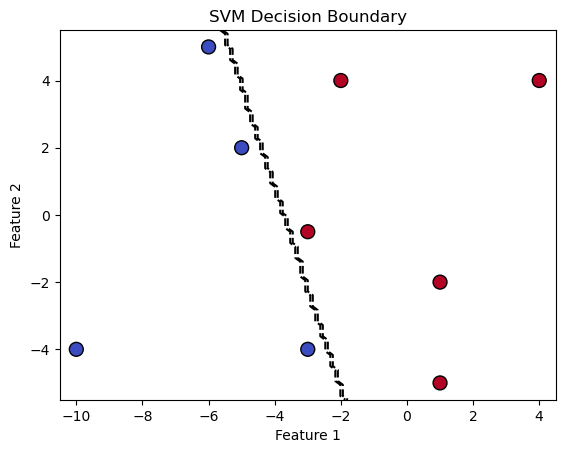

In [126]:
import matplotlib.pyplot as plt

def display_SVM(X, y, alphas, b):
    sv = X[alphas > 0]
    sv_y = y[alphas > 0]
    sv_a = alphas[alphas > 0]

    w = np.sum(sv_a.reshape(-1, 1) * sv * sv_y.reshape(-1, 1), axis=0)
    
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # compute the predicted class for each point on the grid
    Z = np.sign(np.dot(grid_points, w) + b)

    # plot the decision boundary and the support vectors
    plt.contour(xx, yy, Z.reshape(xx.shape), colors=['k', 'k', 'k'], linestyles=['--'], levels=[-1, 0, 1])
    plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap='coolwarm', edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Decision Boundary')
    plt.show()
    return

display_SVM(dummy_X, dummy_y, np.array(alphas), b)

In [79]:
test2 = SimplifiedSMO()
sp_alphas, sp_b = test2.optimize_dual(np.array(sp_X_tr), np.array(sp_y_tr), 2, .2, 10)

Passes: 1, Objective function: -563.8569, Feasibility: 0.0000
Passes: 2, Objective function: -3583367.6564, Feasibility: 0.0000
Passes: 3, Objective function: -3583432.3446, Feasibility: 0.0000
Passes: 4, Objective function: -3583446.7100, Feasibility: 0.0000
Passes: 5, Objective function: -3594812.0179, Feasibility: 0.0000
Passes: 6, Objective function: -3595178.8691, Feasibility: 0.0000
Passes: 7, Objective function: -3595188.6800, Feasibility: 0.0000
Passes: 8, Objective function: -3595237.4882, Feasibility: -0.0000
Passes: 9, Objective function: -3611993.4419, Feasibility: -0.0000
Passes: 10, Objective function: -3618701.5191, Feasibility: -0.0000
Passes: 11, Objective function: -3618710.4304, Feasibility: -0.0000
Passes: 12, Objective function: -3618722.7010, Feasibility: 0.0000
Passes: 13, Objective function: -3618755.5941, Feasibility: 0.0000
Passes: 14, Objective function: -3802481.7142, Feasibility: 0.0000
Passes: 15, Objective function: -3802496.2614, Feasibility: 0.0000
Pass

Passes: 122, Objective function: -30753296.6298, Feasibility: -0.0000
Passes: 123, Objective function: -30753566.8670, Feasibility: -0.0000
Passes: 124, Objective function: -31511691.6901, Feasibility: -0.0000
Passes: 125, Objective function: -31511691.6901, Feasibility: -0.0000
Passes: 126, Objective function: -31598424.7181, Feasibility: -0.0000
Passes: 127, Objective function: -31604381.9140, Feasibility: 0.0000
Passes: 128, Objective function: -31604431.2630, Feasibility: 0.0000
Passes: 129, Objective function: -31604431.2630, Feasibility: 0.0000
Passes: 130, Objective function: -31604445.7542, Feasibility: -0.0000
Passes: 131, Objective function: -31608380.6379, Feasibility: 0.0000
Passes: 132, Objective function: -31610778.2313, Feasibility: 0.0000
Passes: 133, Objective function: -31610577.1191, Feasibility: 0.0000
Passes: 134, Objective function: -31610678.1633, Feasibility: -0.0000
Passes: 135, Objective function: -31610907.8043, Feasibility: -0.0000
Passes: 136, Objective fun

Passes: 248, Objective function: -41141988.7764, Feasibility: 0.0000
Passes: 249, Objective function: -41142423.5854, Feasibility: 0.0000
Passes: 250, Objective function: -41142475.0671, Feasibility: -0.0000
Passes: 251, Objective function: -41142530.2987, Feasibility: 0.0000
Passes: 252, Objective function: -41142949.7740, Feasibility: 0.0000
Passes: 253, Objective function: -41142949.7740, Feasibility: 0.0000
Passes: 254, Objective function: -41142968.9565, Feasibility: -0.0000
Passes: 255, Objective function: -41142968.0571, Feasibility: -0.0000
Passes: 256, Objective function: -41143193.8884, Feasibility: -0.0000
Passes: 257, Objective function: -41143195.7257, Feasibility: -0.0000
Passes: 258, Objective function: -41143205.2741, Feasibility: 0.0000
Passes: 259, Objective function: -41143313.8501, Feasibility: -0.0000
Passes: 260, Objective function: -41146161.2533, Feasibility: -0.0000
Passes: 261, Objective function: -41146109.1985, Feasibility: -0.0000
Passes: 262, Objective fun

Passes: 373, Objective function: -44883558.1844, Feasibility: -0.0000
Passes: 374, Objective function: -44883559.4682, Feasibility: -0.0000
Passes: 375, Objective function: -44882830.7558, Feasibility: -0.0000
Passes: 376, Objective function: -44882621.8946, Feasibility: -0.0000
Passes: 377, Objective function: -44882659.9962, Feasibility: -0.0000
Passes: 378, Objective function: -44885714.2327, Feasibility: -0.0000
Passes: 379, Objective function: -44885707.8627, Feasibility: -0.0000
Passes: 380, Objective function: -44885680.5465, Feasibility: 0.0000
Passes: 381, Objective function: -44891725.2851, Feasibility: -0.0000
Passes: 382, Objective function: -44891720.0336, Feasibility: -0.0000
Passes: 383, Objective function: -44891724.9150, Feasibility: -0.0000
Passes: 384, Objective function: -44891858.1613, Feasibility: -0.0000
Passes: 385, Objective function: -44892607.7588, Feasibility: -0.0000
Passes: 386, Objective function: -44892612.0270, Feasibility: -0.0000
Passes: 387, Objectiv

Passes: 493, Objective function: -48727324.7759, Feasibility: -0.0000
Passes: 494, Objective function: -48728300.7283, Feasibility: 0.0000
Passes: 495, Objective function: -48728342.8863, Feasibility: 0.0000
Passes: 496, Objective function: -48743042.3758, Feasibility: 0.0000
Passes: 497, Objective function: -48743024.0208, Feasibility: 0.0000
Passes: 498, Objective function: -48743017.2212, Feasibility: 0.0000
Passes: 499, Objective function: -48743010.5261, Feasibility: 0.0000
Passes: 500, Objective function: -48743081.1327, Feasibility: 0.0000
Passes: 501, Objective function: -48746797.4907, Feasibility: 0.0000
Passes: 502, Objective function: -48752469.7854, Feasibility: 0.0000
Passes: 503, Objective function: -48752504.2811, Feasibility: 0.0000
Passes: 504, Objective function: -48752504.8696, Feasibility: 0.0000
Passes: 505, Objective function: -48751651.3912, Feasibility: 0.0000
Passes: 506, Objective function: -48755021.0135, Feasibility: 0.0000
Passes: 507, Objective function: 

Passes: 613, Objective function: -49004639.7813, Feasibility: 0.0000
Passes: 614, Objective function: -49004639.7813, Feasibility: 0.0000
Passes: 615, Objective function: -49004642.2326, Feasibility: 0.0000
Passes: 616, Objective function: -49004434.4536, Feasibility: 0.0000
Passes: 617, Objective function: -49006275.5682, Feasibility: 0.0000
Passes: 618, Objective function: -49006290.3976, Feasibility: 0.0000
Passes: 619, Objective function: -101804006.6309, Feasibility: 0.0000
Passes: 620, Objective function: -101786799.3367, Feasibility: 0.0000
Passes: 621, Objective function: -101786799.3367, Feasibility: 0.0000
Passes: 622, Objective function: -101791233.8601, Feasibility: 0.0000
Passes: 623, Objective function: -101790568.5277, Feasibility: 0.0000
Passes: 624, Objective function: -101914251.6240, Feasibility: 0.0000
Passes: 625, Objective function: -101914313.8938, Feasibility: 0.0000
Passes: 626, Objective function: -101914329.8148, Feasibility: 0.0000
Passes: 627, Objective fun

Passes: 731, Objective function: -105334294.1329, Feasibility: 0.0000
Passes: 732, Objective function: -105334295.9727, Feasibility: 0.0000
Passes: 733, Objective function: -105334148.7347, Feasibility: 0.0000
Passes: 734, Objective function: -105334148.7347, Feasibility: 0.0000
Passes: 735, Objective function: -105337307.4126, Feasibility: 0.0000
Passes: 736, Objective function: -105335065.3615, Feasibility: 0.0000
Passes: 737, Objective function: -105335068.8707, Feasibility: 0.0000
Passes: 738, Objective function: -105338143.0777, Feasibility: 0.0000
Passes: 739, Objective function: -105338278.1898, Feasibility: 0.0000
Passes: 740, Objective function: -105338308.0939, Feasibility: 0.0000
Passes: 741, Objective function: -105338308.0939, Feasibility: 0.0000
Passes: 742, Objective function: -105338308.1921, Feasibility: 0.0000
Passes: 743, Objective function: -105338336.3603, Feasibility: 0.0000
Passes: 744, Objective function: -105338355.0108, Feasibility: 0.0000
Passes: 745, Objecti

Passes: 854, Objective function: -105655682.4977, Feasibility: 0.0000
Passes: 855, Objective function: -105657378.3160, Feasibility: 0.0000
Passes: 856, Objective function: -105656484.3609, Feasibility: 0.0000
Passes: 857, Objective function: -105654439.7920, Feasibility: 0.0000
Passes: 858, Objective function: -105655599.6763, Feasibility: 0.0000
Passes: 859, Objective function: -105655538.0620, Feasibility: 0.0000
Passes: 860, Objective function: -105660551.8282, Feasibility: 0.0000
Passes: 861, Objective function: -105659897.6517, Feasibility: 0.0000
Passes: 862, Objective function: -105664179.4296, Feasibility: 0.0000
Passes: 863, Objective function: -105664489.8479, Feasibility: 0.0000
Passes: 864, Objective function: -105664494.3754, Feasibility: 0.0000
Passes: 865, Objective function: -105664496.5094, Feasibility: 0.0000
Passes: 866, Objective function: -105675055.6774, Feasibility: 0.0000
Passes: 867, Objective function: -105674803.4849, Feasibility: 0.0000
Passes: 868, Objecti

Passes: 974, Objective function: -107061359.1976, Feasibility: -0.0000
Passes: 975, Objective function: -107061453.3617, Feasibility: -0.0000
Passes: 976, Objective function: -108148617.5535, Feasibility: -0.0000
Passes: 977, Objective function: -108148489.3903, Feasibility: -0.0000
Passes: 978, Objective function: -108149199.3486, Feasibility: -0.0000
Passes: 979, Objective function: -108149286.1504, Feasibility: -0.0000
Passes: 980, Objective function: -108146651.9109, Feasibility: -0.0000
Passes: 981, Objective function: -108146557.5678, Feasibility: -0.0000
Passes: 982, Objective function: -108140918.5599, Feasibility: -0.0000
Passes: 983, Objective function: -108141832.3206, Feasibility: -0.0000
Passes: 984, Objective function: -108144316.0183, Feasibility: -0.0000
Passes: 985, Objective function: -108144033.5206, Feasibility: -0.0000
Passes: 986, Objective function: -108144043.4678, Feasibility: -0.0000
Passes: 987, Objective function: -108136046.1734, Feasibility: -0.0000
Passes

Passes: 1091, Objective function: -117064973.1176, Feasibility: -0.0000
Passes: 1092, Objective function: -117063936.2143, Feasibility: -0.0000
Passes: 1093, Objective function: -117063540.2469, Feasibility: -0.0000
Passes: 1094, Objective function: -117063546.2490, Feasibility: -0.0000
Passes: 1095, Objective function: -117060001.4415, Feasibility: -0.0000
Passes: 1096, Objective function: -117397573.2273, Feasibility: -0.0000
Passes: 1097, Objective function: -117397541.5223, Feasibility: -0.0000
Passes: 1098, Objective function: -117419803.6300, Feasibility: -0.0000
Passes: 1099, Objective function: -117419567.5700, Feasibility: -0.0000
Passes: 1100, Objective function: -117419364.1689, Feasibility: -0.0000
Passes: 1101, Objective function: -117425784.9894, Feasibility: -0.0000
Passes: 1102, Objective function: -117423431.5912, Feasibility: -0.0000
Passes: 1103, Objective function: -117424982.7056, Feasibility: -0.0000
Passes: 1104, Objective function: -117425321.1074, Feasibility: 

Passes: 1206, Objective function: -121848709.4446, Feasibility: -0.0000
Passes: 1207, Objective function: -121848755.6838, Feasibility: 0.0000
Passes: 1208, Objective function: -121848730.1278, Feasibility: -0.0000
Passes: 1209, Objective function: -121847119.9715, Feasibility: -0.0000
Passes: 1210, Objective function: -121847155.1936, Feasibility: -0.0000
Passes: 1211, Objective function: -121847156.7878, Feasibility: -0.0000
Passes: 1212, Objective function: -121994893.2004, Feasibility: -0.0000
Passes: 1213, Objective function: -121994890.0051, Feasibility: -0.0000
Passes: 1214, Objective function: -121997857.0004, Feasibility: -0.0000
Passes: 1215, Objective function: -121997087.1778, Feasibility: -0.0000
Passes: 1216, Objective function: -121997411.8603, Feasibility: -0.0000
Passes: 1217, Objective function: -121997755.1781, Feasibility: -0.0000
Passes: 1218, Objective function: -122000875.2897, Feasibility: 0.0000
Passes: 1219, Objective function: -122001182.4114, Feasibility: 0.

Passes: 1325, Objective function: -126344626.1439, Feasibility: -0.0000
Passes: 1326, Objective function: -126370317.2564, Feasibility: -0.0000
Passes: 1327, Objective function: -126365915.3083, Feasibility: 0.0000
Passes: 1328, Objective function: -126273854.9832, Feasibility: 0.0000
Passes: 1329, Objective function: -126275069.1510, Feasibility: 0.0000
Passes: 1330, Objective function: -126275074.8838, Feasibility: -0.0000
Passes: 1331, Objective function: -126274856.0369, Feasibility: -0.0000
Passes: 1332, Objective function: -126275038.9137, Feasibility: -0.0000
Passes: 1333, Objective function: -126275051.4426, Feasibility: -0.0000
Passes: 1334, Objective function: -126275037.0808, Feasibility: -0.0000
Passes: 1335, Objective function: -126274771.5824, Feasibility: -0.0000
Passes: 1336, Objective function: -126297305.3647, Feasibility: -0.0000
Passes: 1337, Objective function: -126312341.0545, Feasibility: -0.0000
Passes: 1338, Objective function: -126312179.4862, Feasibility: -0.

Passes: 1444, Objective function: -128179460.0947, Feasibility: -0.0000
Passes: 1445, Objective function: -128177727.5702, Feasibility: -0.0000
Passes: 1446, Objective function: -128177731.8519, Feasibility: -0.0000
Passes: 1447, Objective function: -128167761.4682, Feasibility: 0.0000
Passes: 1448, Objective function: -128166932.9945, Feasibility: 0.0000
Passes: 1449, Objective function: -128262642.5030, Feasibility: 0.0000
Passes: 1450, Objective function: -128262604.3883, Feasibility: -0.0000
Passes: 1451, Objective function: -128262100.5802, Feasibility: -0.0000
Passes: 1452, Objective function: -128291624.8803, Feasibility: -0.0000
Passes: 1453, Objective function: -128290301.7904, Feasibility: -0.0000
Passes: 1454, Objective function: -128292454.4219, Feasibility: -0.0000
Passes: 1455, Objective function: -128291871.7898, Feasibility: -0.0000
Passes: 1456, Objective function: -128291870.0940, Feasibility: -0.0000
Passes: 1457, Objective function: -128291863.6772, Feasibility: -0.

Passes: 1563, Objective function: -130300417.4256, Feasibility: 0.0000
Passes: 1564, Objective function: -130299864.3892, Feasibility: 0.0000
Passes: 1565, Objective function: -130299562.1809, Feasibility: 0.0000
Passes: 1566, Objective function: -130296567.8680, Feasibility: 0.0000
Passes: 1567, Objective function: -130303323.6112, Feasibility: 0.0000
Passes: 1568, Objective function: -130305770.9463, Feasibility: 0.0000
Passes: 1569, Objective function: -130305977.3313, Feasibility: 0.0000
Passes: 1570, Objective function: -130304758.2715, Feasibility: 0.0000
Passes: 1571, Objective function: -130307066.4588, Feasibility: 0.0000
Passes: 1572, Objective function: -130308588.3989, Feasibility: 0.0000
Passes: 1573, Objective function: -130308584.8556, Feasibility: 0.0000
Passes: 1574, Objective function: -130308560.6590, Feasibility: 0.0000
Passes: 1575, Objective function: -130320465.3599, Feasibility: 0.0000
Passes: 1576, Objective function: -130320425.3176, Feasibility: 0.0000
Passes

Passes: 1679, Objective function: -131202209.7818, Feasibility: 0.0000
Passes: 1680, Objective function: -131206370.5911, Feasibility: 0.0000
Passes: 1681, Objective function: -131207309.0342, Feasibility: 0.0000
Passes: 1682, Objective function: -131208734.3803, Feasibility: 0.0000
Passes: 1683, Objective function: -131208828.2005, Feasibility: 0.0000
Passes: 1684, Objective function: -131208828.2005, Feasibility: 0.0000
Passes: 1685, Objective function: -131209494.9656, Feasibility: 0.0000
Passes: 1686, Objective function: -131477511.9082, Feasibility: 0.0000
Passes: 1687, Objective function: -131477524.6513, Feasibility: 0.0000
Passes: 1688, Objective function: -131477479.6970, Feasibility: 0.0000
Passes: 1689, Objective function: -131477528.6330, Feasibility: 0.0000
Passes: 1690, Objective function: -131477533.7910, Feasibility: 0.0000
Passes: 1691, Objective function: -131477913.5004, Feasibility: 0.0000
Passes: 1692, Objective function: -131477706.9863, Feasibility: 0.0000
Passes

Passes: 1797, Objective function: -145831724.0231, Feasibility: -0.0000
Passes: 1798, Objective function: -145871928.5074, Feasibility: -0.0000
Passes: 1799, Objective function: -145879045.3506, Feasibility: -0.0000
Passes: 1800, Objective function: -145879074.8916, Feasibility: -0.0000
Passes: 1801, Objective function: -145888463.8279, Feasibility: -0.0000
Passes: 1802, Objective function: -145888463.8279, Feasibility: -0.0000
Passes: 1803, Objective function: -145893500.4267, Feasibility: 0.0000
Passes: 1804, Objective function: -145895803.0448, Feasibility: 0.0000
Passes: 1805, Objective function: -145894462.9906, Feasibility: -0.0000
Passes: 1806, Objective function: -145884442.2613, Feasibility: -0.0000
Passes: 1807, Objective function: -145884499.3204, Feasibility: 0.0000
Passes: 1808, Objective function: -145886307.2040, Feasibility: -0.0000
Passes: 1809, Objective function: -145886307.2040, Feasibility: -0.0000
Passes: 1810, Objective function: -145886937.7749, Feasibility: -0.

Passes: 1918, Objective function: -149359696.7070, Feasibility: 0.0000
Passes: 1919, Objective function: -149360076.1408, Feasibility: 0.0000
Passes: 1920, Objective function: -149377775.3785, Feasibility: 0.0000
Passes: 1921, Objective function: -149377675.2704, Feasibility: 0.0000
Passes: 1922, Objective function: -149377628.3379, Feasibility: 0.0000
Passes: 1923, Objective function: -149377793.4554, Feasibility: 0.0000
Passes: 1924, Objective function: -149377559.4567, Feasibility: 0.0000
Passes: 1925, Objective function: -149384122.0672, Feasibility: 0.0000
Passes: 1926, Objective function: -149395954.7283, Feasibility: 0.0000
Passes: 1927, Objective function: -149396595.4762, Feasibility: 0.0000
Passes: 1928, Objective function: -149422486.4427, Feasibility: 0.0000
Passes: 1929, Objective function: -149420946.7500, Feasibility: 0.0000
Passes: 1930, Objective function: -149421229.7803, Feasibility: 0.0000
Passes: 1931, Objective function: -149422771.9067, Feasibility: 0.0000
Passes

Passes: 2037, Objective function: -166270206.4413, Feasibility: 0.0000
Passes: 2038, Objective function: -166269663.2107, Feasibility: -0.0000
Passes: 2039, Objective function: -166270114.5624, Feasibility: -0.0000
Passes: 2040, Objective function: -166270937.4084, Feasibility: 0.0000
Passes: 2041, Objective function: -166271542.0677, Feasibility: 0.0000
Passes: 2042, Objective function: -166275755.1998, Feasibility: -0.0000
Passes: 2043, Objective function: -166276171.5998, Feasibility: -0.0000
Passes: 2044, Objective function: -166276958.2854, Feasibility: -0.0000
Passes: 2045, Objective function: -166277139.5232, Feasibility: -0.0000
Passes: 2046, Objective function: -166399398.5691, Feasibility: -0.0000
Passes: 2047, Objective function: -166399398.5691, Feasibility: 0.0000
Passes: 2048, Objective function: -166398598.5483, Feasibility: 0.0000
Passes: 2049, Objective function: -166398648.6600, Feasibility: 0.0000
Passes: 2050, Objective function: -166398742.0858, Feasibility: 0.0000

Passes: 2156, Objective function: -173241096.5624, Feasibility: 0.0000
Passes: 2157, Objective function: -173240491.8448, Feasibility: 0.0000
Passes: 2158, Objective function: -173240036.9921, Feasibility: 0.0000
Passes: 2159, Objective function: -173241119.9594, Feasibility: 0.0000
Passes: 2160, Objective function: -173239873.2393, Feasibility: 0.0000
Passes: 2161, Objective function: -173241103.2923, Feasibility: 0.0000
Passes: 2162, Objective function: -173241739.8860, Feasibility: 0.0000
Passes: 2163, Objective function: -173243026.5105, Feasibility: 0.0000
Passes: 2164, Objective function: -173243224.8144, Feasibility: 0.0000
Passes: 2165, Objective function: -173284956.9719, Feasibility: 0.0000
Passes: 2166, Objective function: -173280479.0129, Feasibility: 0.0000
Passes: 2167, Objective function: -173284633.5876, Feasibility: 0.0000
Passes: 2168, Objective function: -173282807.1931, Feasibility: 0.0000
Passes: 2169, Objective function: -173282895.6425, Feasibility: 0.0000
Passes

Passes: 2272, Objective function: -175556927.3326, Feasibility: 0.0000
Passes: 2273, Objective function: -175557108.4995, Feasibility: 0.0000
Passes: 2274, Objective function: -175557155.8737, Feasibility: 0.0000
Passes: 2275, Objective function: -175578008.2938, Feasibility: 0.0000
Passes: 2276, Objective function: -175578260.5629, Feasibility: 0.0000
Passes: 2277, Objective function: -175578378.5554, Feasibility: 0.0000
Passes: 2278, Objective function: -175578360.8921, Feasibility: 0.0000
Passes: 2279, Objective function: -175578387.2407, Feasibility: 0.0000
Passes: 2280, Objective function: -175578273.6931, Feasibility: 0.0000
Passes: 2281, Objective function: -175584672.6653, Feasibility: 0.0000
Passes: 2282, Objective function: -175612986.5742, Feasibility: 0.0000
Passes: 2283, Objective function: -175614176.0264, Feasibility: 0.0000
Passes: 2284, Objective function: -175634324.9114, Feasibility: 0.0000
Passes: 2285, Objective function: -175623852.5247, Feasibility: 0.0000
Passes

Passes: 2393, Objective function: -196278887.1394, Feasibility: 0.0000
Passes: 2394, Objective function: -196279018.5030, Feasibility: 0.0000
Passes: 2395, Objective function: -196278653.3364, Feasibility: 0.0000
Passes: 2396, Objective function: -196322076.8240, Feasibility: 0.0000
Passes: 2397, Objective function: -196322391.2915, Feasibility: 0.0000
Passes: 2398, Objective function: -196322391.2915, Feasibility: 0.0000
Passes: 2399, Objective function: -196323602.7712, Feasibility: 0.0000
Passes: 2400, Objective function: -196313557.2151, Feasibility: 0.0000
Passes: 2401, Objective function: -196313997.1329, Feasibility: 0.0000
Passes: 2402, Objective function: -196314367.0727, Feasibility: 0.0000
Passes: 2403, Objective function: -196314629.5391, Feasibility: 0.0000
Passes: 2404, Objective function: -196315796.8781, Feasibility: 0.0000
Passes: 2405, Objective function: -199815792.4448, Feasibility: 0.0000
Passes: 2406, Objective function: -199813123.7151, Feasibility: 0.0000
Passes

Passes: 2511, Objective function: -258201558.3615, Feasibility: 0.0000
Passes: 2512, Objective function: -258201768.1566, Feasibility: 0.0000
Passes: 2513, Objective function: -258201768.1566, Feasibility: 0.0000
Passes: 2514, Objective function: -258205332.9185, Feasibility: 0.0000
Passes: 2515, Objective function: -258204282.1835, Feasibility: 0.0000
Passes: 2516, Objective function: -258204686.7011, Feasibility: 0.0000
Passes: 2517, Objective function: -258620660.0870, Feasibility: 0.0000
Passes: 2518, Objective function: -258620808.1662, Feasibility: 0.0000
Passes: 2519, Objective function: -258660699.6268, Feasibility: 0.0000
Passes: 2520, Objective function: -258676541.3988, Feasibility: 0.0000
Passes: 2521, Objective function: -258676449.6043, Feasibility: 0.0000
Passes: 2522, Objective function: -258757759.2725, Feasibility: 0.0000
Passes: 2523, Objective function: -258757997.1855, Feasibility: 0.0000
Passes: 2524, Objective function: -258752607.1528, Feasibility: 0.0000
Passes

Passes: 2628, Objective function: -262750693.4501, Feasibility: 0.0000
Passes: 2629, Objective function: -262801727.3636, Feasibility: 0.0000
Passes: 2630, Objective function: -262803468.2043, Feasibility: 0.0000
Passes: 2631, Objective function: -262817127.9857, Feasibility: 0.0000
Passes: 2632, Objective function: -262814976.6541, Feasibility: 0.0000
Passes: 2633, Objective function: -262820960.6165, Feasibility: 0.0000
Passes: 2634, Objective function: -262820076.0587, Feasibility: 0.0000
Passes: 2635, Objective function: -262819607.8525, Feasibility: 0.0000
Passes: 2636, Objective function: -262821158.3327, Feasibility: 0.0000
Passes: 2637, Objective function: -262820021.0441, Feasibility: 0.0000
Passes: 2638, Objective function: -262820196.4030, Feasibility: 0.0000
Passes: 2639, Objective function: -262820124.0737, Feasibility: 0.0000
Passes: 2640, Objective function: -262826412.5399, Feasibility: 0.0000
Passes: 2641, Objective function: -262826867.0420, Feasibility: 0.0000
Passes

Passes: 2748, Objective function: -261482870.6770, Feasibility: -0.0000
Passes: 2749, Objective function: -261485272.7487, Feasibility: -0.0000
Passes: 2750, Objective function: -261673501.2844, Feasibility: -0.0000
Passes: 2751, Objective function: -261673717.6992, Feasibility: -0.0000
Passes: 2752, Objective function: -261674495.9850, Feasibility: -0.0000
Passes: 2753, Objective function: -261674158.5720, Feasibility: -0.0000
Passes: 2754, Objective function: -261673635.7062, Feasibility: -0.0000
Passes: 2755, Objective function: -261673721.2220, Feasibility: -0.0000
Passes: 2756, Objective function: -261668661.5602, Feasibility: -0.0000
Passes: 2757, Objective function: -266831597.5892, Feasibility: -0.0000
Passes: 2758, Objective function: -266833730.4028, Feasibility: -0.0000
Passes: 2759, Objective function: -266833416.5947, Feasibility: -0.0000
Passes: 2760, Objective function: -266835132.1312, Feasibility: -0.0000
Passes: 2761, Objective function: -266824514.0836, Feasibility: 

Passes: 2863, Objective function: -273623721.4892, Feasibility: -0.0000
Passes: 2864, Objective function: -273623289.1532, Feasibility: -0.0000
Passes: 2865, Objective function: -273628961.2882, Feasibility: -0.0000
Passes: 2866, Objective function: -273630391.8486, Feasibility: -0.0000
Passes: 2867, Objective function: -273622042.3945, Feasibility: -0.0000
Passes: 2868, Objective function: -273622119.9047, Feasibility: -0.0000
Passes: 2869, Objective function: -273622035.8671, Feasibility: -0.0000
Passes: 2870, Objective function: -273621767.9679, Feasibility: -0.0000
Passes: 2871, Objective function: -273621762.0363, Feasibility: -0.0000
Passes: 2872, Objective function: -273622666.8532, Feasibility: -0.0000
Passes: 2873, Objective function: -273622825.3701, Feasibility: -0.0000
Passes: 2874, Objective function: -273621453.1000, Feasibility: -0.0000
Passes: 2875, Objective function: -273622718.2017, Feasibility: -0.0000
Passes: 2876, Objective function: -273623050.9375, Feasibility: 

Passes: 2979, Objective function: -283549399.4764, Feasibility: 0.0000
Passes: 2980, Objective function: -283550053.1619, Feasibility: -0.0000
Passes: 2981, Objective function: -283687823.3200, Feasibility: -0.0000
Passes: 2982, Objective function: -283689379.5497, Feasibility: -0.0000
Passes: 2983, Objective function: -283689427.0842, Feasibility: 0.0000
Passes: 2984, Objective function: -283602557.7888, Feasibility: -0.0000
Passes: 2985, Objective function: -283602597.6806, Feasibility: 0.0000
Passes: 2986, Objective function: -283601751.7544, Feasibility: 0.0000
Passes: 2987, Objective function: -283601676.3852, Feasibility: -0.0000
Passes: 2988, Objective function: -283603066.5732, Feasibility: 0.0000
Passes: 2989, Objective function: -283605662.3862, Feasibility: 0.0000
Passes: 2990, Objective function: -283605663.5339, Feasibility: -0.0000
Passes: 2991, Objective function: -283605851.5578, Feasibility: -0.0000
Passes: 2992, Objective function: -283619920.9002, Feasibility: -0.000

Passes: 3096, Objective function: -284303893.7883, Feasibility: 0.0000
Passes: 3097, Objective function: -284303623.5854, Feasibility: 0.0000
Passes: 3098, Objective function: -284309765.0024, Feasibility: 0.0000
Passes: 3099, Objective function: -284020066.3229, Feasibility: 0.0000
Passes: 3100, Objective function: -284057925.5670, Feasibility: 0.0000
Passes: 3101, Objective function: -284070086.9031, Feasibility: 0.0000
Passes: 3102, Objective function: -284065278.0402, Feasibility: 0.0000
Passes: 3103, Objective function: -284065326.8463, Feasibility: 0.0000
Passes: 3104, Objective function: -284484878.9200, Feasibility: 0.0000
Passes: 3105, Objective function: -284493588.8858, Feasibility: 0.0000
Passes: 3106, Objective function: -284491181.5166, Feasibility: 0.0000
Passes: 3107, Objective function: -284481680.6781, Feasibility: 0.0000
Passes: 3108, Objective function: -284481647.8236, Feasibility: 0.0000
Passes: 3109, Objective function: -284483337.6607, Feasibility: 0.0000
Passes

Passes: 3218, Objective function: -286423876.9645, Feasibility: 0.0000
Passes: 3219, Objective function: -286427434.2959, Feasibility: 0.0000
Passes: 3220, Objective function: -286422173.4552, Feasibility: 0.0000
Passes: 3221, Objective function: -286358182.0436, Feasibility: 0.0000
Passes: 3222, Objective function: -286358338.7288, Feasibility: 0.0000
Passes: 3223, Objective function: -286368622.4340, Feasibility: 0.0000
Passes: 3224, Objective function: -286368704.6091, Feasibility: 0.0000
Passes: 3225, Objective function: -286369815.9068, Feasibility: 0.0000
Passes: 3226, Objective function: -286369728.1100, Feasibility: 0.0000
Passes: 3227, Objective function: -286369628.0300, Feasibility: 0.0000
Passes: 3228, Objective function: -286397634.1373, Feasibility: 0.0000
Passes: 3229, Objective function: -286402678.6529, Feasibility: 0.0000
Passes: 3230, Objective function: -286412376.2219, Feasibility: 0.0000
Passes: 3231, Objective function: -286411928.6541, Feasibility: 0.0000
Passes

Passes: 3334, Objective function: -294242331.1347, Feasibility: -0.0000
Passes: 3335, Objective function: -294243215.1001, Feasibility: -0.0000
Passes: 3336, Objective function: -297430124.4486, Feasibility: -0.0000
Passes: 3337, Objective function: -297437404.3602, Feasibility: -0.0000
Passes: 3338, Objective function: -297805150.8161, Feasibility: -0.0000
Passes: 3339, Objective function: -297871736.8867, Feasibility: -0.0000
Passes: 3340, Objective function: -297871759.7164, Feasibility: -0.0000
Passes: 3341, Objective function: -297871766.8626, Feasibility: -0.0000
Passes: 3342, Objective function: -297914519.3608, Feasibility: -0.0000
Passes: 3343, Objective function: -297914532.5194, Feasibility: -0.0000
Passes: 3344, Objective function: -297915108.0757, Feasibility: -0.0000
Passes: 3345, Objective function: -297942819.2211, Feasibility: -0.0000
Passes: 3346, Objective function: -297938374.3477, Feasibility: -0.0000
Passes: 3347, Objective function: -297938460.1604, Feasibility: 

Passes: 3451, Objective function: -297584930.8458, Feasibility: 0.0000
Passes: 3452, Objective function: -297584703.4439, Feasibility: 0.0000
Passes: 3453, Objective function: -297576084.1775, Feasibility: 0.0000
Passes: 3454, Objective function: -297572644.9163, Feasibility: 0.0000
Passes: 3455, Objective function: -297614677.9227, Feasibility: 0.0000
Passes: 3456, Objective function: -297614693.8709, Feasibility: 0.0000
Passes: 3457, Objective function: -297621827.9160, Feasibility: 0.0000
Passes: 3458, Objective function: -297625316.1723, Feasibility: 0.0000
Passes: 3459, Objective function: -297635183.5178, Feasibility: 0.0000
Passes: 3460, Objective function: -297634895.6131, Feasibility: 0.0000
Passes: 3461, Objective function: -297681441.0469, Feasibility: 0.0000
Passes: 3462, Objective function: -297680364.3780, Feasibility: 0.0000
Passes: 3463, Objective function: -297708930.0304, Feasibility: -0.0000
Passes: 3464, Objective function: -297708988.4209, Feasibility: 0.0000
Passe

Passes: 3573, Objective function: -292779132.2594, Feasibility: 0.0000
Passes: 3574, Objective function: -292779307.1006, Feasibility: 0.0000
Passes: 3575, Objective function: -292786030.5082, Feasibility: 0.0000
Passes: 3576, Objective function: -292784655.2410, Feasibility: 0.0000
Passes: 3577, Objective function: -292784699.6569, Feasibility: 0.0000
Passes: 3578, Objective function: -292773113.5281, Feasibility: 0.0000
Passes: 3579, Objective function: -292772008.5833, Feasibility: 0.0000
Passes: 3580, Objective function: -292768776.2051, Feasibility: 0.0000
Passes: 3581, Objective function: -292774035.5562, Feasibility: 0.0000
Passes: 3582, Objective function: -292774030.4076, Feasibility: 0.0000
Passes: 3583, Objective function: -292773994.7688, Feasibility: 0.0000
Passes: 3584, Objective function: -292889337.2262, Feasibility: 0.0000
Passes: 3585, Objective function: -292833620.6756, Feasibility: 0.0000
Passes: 3586, Objective function: -292903240.1309, Feasibility: 0.0000
Passes

Passes: 3689, Objective function: -301153336.5887, Feasibility: 0.0000
Passes: 3690, Objective function: -301154224.5055, Feasibility: 0.0000
Passes: 3691, Objective function: -301155568.7509, Feasibility: 0.0000
Passes: 3692, Objective function: -301155569.2006, Feasibility: 0.0000
Passes: 3693, Objective function: -301161274.9396, Feasibility: 0.0000
Passes: 3694, Objective function: -301161666.3499, Feasibility: 0.0000
Passes: 3695, Objective function: -301161760.1787, Feasibility: 0.0000
Passes: 3696, Objective function: -301161645.6671, Feasibility: 0.0000
Passes: 3697, Objective function: -301161082.7962, Feasibility: 0.0000
Passes: 3698, Objective function: -301161134.8727, Feasibility: 0.0000
Passes: 3699, Objective function: -301160364.3856, Feasibility: 0.0000
Passes: 3700, Objective function: -301160621.0172, Feasibility: 0.0000
Passes: 3701, Objective function: -301160211.7923, Feasibility: 0.0000
Passes: 3702, Objective function: -301158259.3167, Feasibility: 0.0000
Passes

Passes: 3806, Objective function: -304469780.3574, Feasibility: 0.0000
Passes: 3807, Objective function: -304518336.2115, Feasibility: 0.0000
Passes: 3808, Objective function: -304518687.1867, Feasibility: 0.0000
Passes: 3809, Objective function: -304522592.0251, Feasibility: 0.0000
Passes: 3810, Objective function: -304522796.7406, Feasibility: 0.0000
Passes: 3811, Objective function: -304523085.1817, Feasibility: 0.0000
Passes: 3812, Objective function: -304523280.6923, Feasibility: 0.0000
Passes: 3813, Objective function: -304524104.9525, Feasibility: 0.0000
Passes: 3814, Objective function: -304524063.3729, Feasibility: 0.0000
Passes: 3815, Objective function: -304524133.1411, Feasibility: 0.0000
Passes: 3816, Objective function: -304524243.9266, Feasibility: 0.0000
Passes: 3817, Objective function: -304524537.1017, Feasibility: 0.0000
Passes: 3818, Objective function: -304528058.5947, Feasibility: 0.0000
Passes: 3819, Objective function: -304530704.6697, Feasibility: 0.0000
Passes

Passes: 3930, Objective function: -306557625.7380, Feasibility: -0.0000
Passes: 3931, Objective function: -306558099.9220, Feasibility: -0.0000
Passes: 3932, Objective function: -306559391.4875, Feasibility: -0.0000
Passes: 3933, Objective function: -306557970.2045, Feasibility: -0.0000
Passes: 3934, Objective function: -306551064.8085, Feasibility: -0.0000
Passes: 3935, Objective function: -306553515.6073, Feasibility: -0.0000
Passes: 3936, Objective function: -306553793.6538, Feasibility: -0.0000
Passes: 3937, Objective function: -306552476.4575, Feasibility: -0.0000
Passes: 3938, Objective function: -306536124.9115, Feasibility: 0.0000
Passes: 3939, Objective function: -306539849.0579, Feasibility: -0.0000
Passes: 3940, Objective function: -306321733.5993, Feasibility: -0.0000
Passes: 3941, Objective function: -306322054.8222, Feasibility: -0.0000
Passes: 3942, Objective function: -306322645.7856, Feasibility: -0.0000
Passes: 3943, Objective function: -306322655.6684, Feasibility: 0

Passes: 4045, Objective function: -307513686.9442, Feasibility: 0.0000
Passes: 4046, Objective function: -307516208.6550, Feasibility: 0.0000
Passes: 4047, Objective function: -307516912.1923, Feasibility: 0.0000
Passes: 4048, Objective function: -307512885.1063, Feasibility: 0.0000
Passes: 4049, Objective function: -307524635.0285, Feasibility: 0.0000
Passes: 4050, Objective function: -307562370.6793, Feasibility: 0.0000
Passes: 4051, Objective function: -307565175.6442, Feasibility: 0.0000
Passes: 4052, Objective function: -307565177.7282, Feasibility: 0.0000
Passes: 4053, Objective function: -307644919.2706, Feasibility: 0.0000
Passes: 4054, Objective function: -307638039.6432, Feasibility: 0.0000
Passes: 4055, Objective function: -307637099.7775, Feasibility: 0.0000
Passes: 4056, Objective function: -307637683.5398, Feasibility: 0.0000
Passes: 4057, Objective function: -307626104.8342, Feasibility: 0.0000
Passes: 4058, Objective function: -307588018.2951, Feasibility: 0.0000
Passes

Passes: 4165, Objective function: -345140303.7630, Feasibility: 0.0000
Passes: 4166, Objective function: -345154138.3873, Feasibility: -0.0000
Passes: 4167, Objective function: -345160609.5243, Feasibility: -0.0000
Passes: 4168, Objective function: -345160582.5166, Feasibility: -0.0000
Passes: 4169, Objective function: -345160372.8607, Feasibility: -0.0000
Passes: 4170, Objective function: -345239774.8124, Feasibility: -0.0000
Passes: 4171, Objective function: -345257151.6991, Feasibility: -0.0000
Passes: 4172, Objective function: -345260772.7209, Feasibility: -0.0000
Passes: 4173, Objective function: -345260589.5179, Feasibility: -0.0000
Passes: 4174, Objective function: -345269167.6820, Feasibility: -0.0000
Passes: 4175, Objective function: -345269167.6820, Feasibility: -0.0000
Passes: 4176, Objective function: -345277956.9537, Feasibility: -0.0000
Passes: 4177, Objective function: -345284200.3342, Feasibility: -0.0000
Passes: 4178, Objective function: -345285161.2224, Feasibility: -

Passes: 4283, Objective function: -349960737.6813, Feasibility: 0.0000
Passes: 4284, Objective function: -349962161.3041, Feasibility: 0.0000
Passes: 4285, Objective function: -349962285.2324, Feasibility: 0.0000
Passes: 4286, Objective function: -349963485.6399, Feasibility: -0.0000
Passes: 4287, Objective function: -349962722.6246, Feasibility: -0.0000
Passes: 4288, Objective function: -350031745.0947, Feasibility: 0.0000
Passes: 4289, Objective function: -350035277.3750, Feasibility: 0.0000
Passes: 4290, Objective function: -350026937.1726, Feasibility: 0.0000
Passes: 4291, Objective function: -350017444.0622, Feasibility: 0.0000
Passes: 4292, Objective function: -350021241.6436, Feasibility: 0.0000
Passes: 4293, Objective function: -350026249.9898, Feasibility: 0.0000
Passes: 4294, Objective function: -350026255.7794, Feasibility: 0.0000
Passes: 4295, Objective function: -350026364.2386, Feasibility: 0.0000
Passes: 4296, Objective function: -350030837.6819, Feasibility: 0.0000
Pass

Passes: 4403, Objective function: -354381175.9902, Feasibility: 0.0000
Passes: 4404, Objective function: -354364245.4005, Feasibility: 0.0000
Passes: 4405, Objective function: -354426135.3880, Feasibility: 0.0000
Passes: 4406, Objective function: -354425756.7064, Feasibility: 0.0000
Passes: 4407, Objective function: -354425629.8371, Feasibility: 0.0000
Passes: 4408, Objective function: -354424644.9337, Feasibility: 0.0000
Passes: 4409, Objective function: -354418882.9338, Feasibility: 0.0000
Passes: 4410, Objective function: -354420088.3543, Feasibility: 0.0000
Passes: 4411, Objective function: -354420333.5541, Feasibility: 0.0000
Passes: 4412, Objective function: -354426167.7369, Feasibility: 0.0000
Passes: 4413, Objective function: -354427116.7399, Feasibility: 0.0000
Passes: 4414, Objective function: -354426085.6700, Feasibility: 0.0000
Passes: 4415, Objective function: -354426409.0133, Feasibility: 0.0000
Passes: 4416, Objective function: -354429626.1027, Feasibility: 0.0000
Passes

Passes: 4518, Objective function: -368867576.9010, Feasibility: -0.0000
Passes: 4519, Objective function: -368868454.5105, Feasibility: -0.0000
Passes: 4520, Objective function: -368868565.4460, Feasibility: -0.0000
Passes: 4521, Objective function: -368892624.8845, Feasibility: -0.0000
Passes: 4522, Objective function: -368895889.5328, Feasibility: -0.0000
Passes: 4523, Objective function: -368954495.0718, Feasibility: -0.0000
Passes: 4524, Objective function: -368954861.8189, Feasibility: -0.0000
Passes: 4525, Objective function: -368974497.1083, Feasibility: -0.0000
Passes: 4526, Objective function: -368986814.4360, Feasibility: -0.0000
Passes: 4527, Objective function: -368979350.2702, Feasibility: -0.0000
Passes: 4528, Objective function: -368979968.4554, Feasibility: -0.0000
Passes: 4529, Objective function: -368979891.7903, Feasibility: -0.0000
Passes: 4530, Objective function: -368979918.3235, Feasibility: -0.0000
Passes: 4531, Objective function: -369001111.9116, Feasibility: 

Passes: 4636, Objective function: -376328591.6996, Feasibility: 0.0000
Passes: 4637, Objective function: -376330208.5355, Feasibility: 0.0000
Passes: 4638, Objective function: -376335158.6549, Feasibility: 0.0000
Passes: 4639, Objective function: -376334811.8574, Feasibility: 0.0000
Passes: 4640, Objective function: -376334529.3234, Feasibility: -0.0000
Passes: 4641, Objective function: -376335770.7948, Feasibility: -0.0000
Passes: 4642, Objective function: -376335625.6756, Feasibility: -0.0000
Passes: 4643, Objective function: -376335964.4647, Feasibility: 0.0000
Passes: 4644, Objective function: -376335945.3994, Feasibility: 0.0000
Passes: 4645, Objective function: -376346133.0374, Feasibility: 0.0000
Passes: 4646, Objective function: -376390635.5879, Feasibility: 0.0000
Passes: 4647, Objective function: -376390200.7164, Feasibility: 0.0000
Passes: 4648, Objective function: -376610897.0106, Feasibility: 0.0000
Passes: 4649, Objective function: -376610886.4093, Feasibility: 0.0000
Pas

Passes: 4755, Objective function: -381251935.6722, Feasibility: 0.0000
Passes: 4756, Objective function: -381255569.5948, Feasibility: 0.0000
Passes: 4757, Objective function: -381257903.6852, Feasibility: 0.0000
Passes: 4758, Objective function: -381256293.0045, Feasibility: 0.0000
Passes: 4759, Objective function: -381598810.1513, Feasibility: 0.0000
Passes: 4760, Objective function: -381594801.0685, Feasibility: 0.0000
Passes: 4761, Objective function: -381594893.3872, Feasibility: 0.0000
Passes: 4762, Objective function: -381595541.2470, Feasibility: 0.0000
Passes: 4763, Objective function: -381595587.8870, Feasibility: 0.0000
Passes: 4764, Objective function: -381604571.3158, Feasibility: 0.0000
Passes: 4765, Objective function: -381602370.7684, Feasibility: 0.0000
Passes: 4766, Objective function: -381608008.1800, Feasibility: 0.0000
Passes: 4767, Objective function: -381613832.4244, Feasibility: 0.0000
Passes: 4768, Objective function: -381613856.8999, Feasibility: 0.0000
Passes

Passes: 4871, Objective function: -384403151.3142, Feasibility: -0.0000
Passes: 4872, Objective function: -384418491.0174, Feasibility: -0.0000
Passes: 4873, Objective function: -384420771.6662, Feasibility: -0.0000
Passes: 4874, Objective function: -384420440.2139, Feasibility: -0.0000
Passes: 4875, Objective function: -384421123.0252, Feasibility: -0.0000
Passes: 4876, Objective function: -384418782.2399, Feasibility: -0.0000
Passes: 4877, Objective function: -384437164.3186, Feasibility: -0.0000
Passes: 4878, Objective function: -384439909.7847, Feasibility: 0.0000
Passes: 4879, Objective function: -384440653.3558, Feasibility: 0.0000
Passes: 4880, Objective function: -384439035.4196, Feasibility: 0.0000
Passes: 4881, Objective function: -384439649.4849, Feasibility: -0.0000
Passes: 4882, Objective function: -384439660.2655, Feasibility: -0.0000
Passes: 4883, Objective function: -384439287.2237, Feasibility: -0.0000
Passes: 4884, Objective function: -384438697.3846, Feasibility: 0.0

Passes: 4986, Objective function: -388729934.2247, Feasibility: -0.0000
Passes: 4987, Objective function: -388729968.9538, Feasibility: -0.0000
Passes: 4988, Objective function: -388730045.9988, Feasibility: -0.0000
Passes: 4989, Objective function: -388746928.7513, Feasibility: -0.0000
Passes: 4990, Objective function: -388742657.2339, Feasibility: -0.0000
Passes: 4991, Objective function: -388753124.8483, Feasibility: -0.0000
Passes: 4992, Objective function: -388842637.4661, Feasibility: -0.0000
Passes: 4993, Objective function: -388853181.6506, Feasibility: -0.0000
Passes: 4994, Objective function: -388852499.2562, Feasibility: -0.0000
Passes: 4995, Objective function: -388858068.9662, Feasibility: -0.0000
Passes: 4996, Objective function: -388858112.2115, Feasibility: -0.0000
Passes: 4997, Objective function: -388861325.4556, Feasibility: -0.0000
Passes: 4998, Objective function: -388861373.6641, Feasibility: -0.0000
Passes: 4999, Objective function: -388869339.2257, Feasibility: 

Passes: 5105, Objective function: -395054676.4962, Feasibility: -0.0000
Passes: 5106, Objective function: -395056044.9957, Feasibility: -0.0000
Passes: 5107, Objective function: -395056444.4820, Feasibility: -0.0000
Passes: 5108, Objective function: -395205820.9389, Feasibility: -0.0000
Passes: 5109, Objective function: -395202480.5380, Feasibility: -0.0000
Passes: 5110, Objective function: -395202495.3509, Feasibility: -0.0000
Passes: 5111, Objective function: -395202516.8730, Feasibility: -0.0000
Passes: 5112, Objective function: -395202711.2934, Feasibility: -0.0000
Passes: 5113, Objective function: -395204948.8916, Feasibility: -0.0000
Passes: 5114, Objective function: -395211996.7290, Feasibility: -0.0000
Passes: 5115, Objective function: -395215791.5423, Feasibility: -0.0000
Passes: 5116, Objective function: -395194686.2309, Feasibility: -0.0000
Passes: 5117, Objective function: -395191854.8194, Feasibility: -0.0000
Passes: 5118, Objective function: -395193453.3263, Feasibility: 

Passes: 5225, Objective function: -404750723.7445, Feasibility: 0.0000
Passes: 5226, Objective function: -404859118.7273, Feasibility: 0.0000
Passes: 5227, Objective function: -404859282.2896, Feasibility: 0.0000
Passes: 5228, Objective function: -404859301.9675, Feasibility: -0.0000
Passes: 5229, Objective function: -404860491.7924, Feasibility: -0.0000
Passes: 5230, Objective function: -404860394.2405, Feasibility: -0.0000
Passes: 5231, Objective function: -404860883.8238, Feasibility: -0.0000
Passes: 5232, Objective function: -405003727.5715, Feasibility: -0.0000
Passes: 5233, Objective function: -405004018.1437, Feasibility: -0.0000
Passes: 5234, Objective function: -405001497.7931, Feasibility: -0.0000
Passes: 5235, Objective function: -405001599.0408, Feasibility: -0.0000
Passes: 5236, Objective function: -405001622.8499, Feasibility: -0.0000
Passes: 5237, Objective function: -405010945.6168, Feasibility: -0.0000
Passes: 5238, Objective function: -405010852.3380, Feasibility: -0.

Passes: 5342, Objective function: -409015532.8473, Feasibility: 0.0000
Passes: 5343, Objective function: -409010043.8397, Feasibility: 0.0000
Passes: 5344, Objective function: -409121230.1487, Feasibility: 0.0000
Passes: 5345, Objective function: -410802125.4953, Feasibility: 0.0000
Passes: 5346, Objective function: -410851681.2436, Feasibility: 0.0000
Passes: 5347, Objective function: -410850400.0280, Feasibility: 0.0000
Passes: 5348, Objective function: -410850472.4206, Feasibility: 0.0000
Passes: 5349, Objective function: -410850504.2546, Feasibility: 0.0000
Passes: 5350, Objective function: -410850440.7240, Feasibility: 0.0000
Passes: 5351, Objective function: -410894775.7487, Feasibility: 0.0000
Passes: 5352, Objective function: -410885151.2874, Feasibility: 0.0000
Passes: 5353, Objective function: -410884847.0033, Feasibility: 0.0000
Passes: 5354, Objective function: -411146661.1467, Feasibility: 0.0000
Passes: 5355, Objective function: -411146814.8488, Feasibility: 0.0000
Passes

Passes: 5460, Objective function: -456318113.1716, Feasibility: 0.0000
Passes: 5461, Objective function: -456318526.3430, Feasibility: 0.0000
Passes: 5462, Objective function: -456319063.7331, Feasibility: 0.0000
Passes: 5463, Objective function: -456323910.9930, Feasibility: 0.0000
Passes: 5464, Objective function: -456634134.9230, Feasibility: 0.0000
Passes: 5465, Objective function: -456635969.6651, Feasibility: 0.0000
Passes: 5466, Objective function: -456634048.7891, Feasibility: 0.0000
Passes: 5467, Objective function: -456636086.7617, Feasibility: 0.0000
Passes: 5468, Objective function: -456773375.3839, Feasibility: 0.0000
Passes: 5469, Objective function: -456774400.7015, Feasibility: 0.0000
Passes: 5470, Objective function: -456776865.4609, Feasibility: 0.0000
Passes: 5471, Objective function: -456776648.2051, Feasibility: 0.0000
Passes: 5472, Objective function: -456781098.8635, Feasibility: 0.0000
Passes: 5473, Objective function: -456788575.8292, Feasibility: 0.0000
Passes

Passes: 5577, Objective function: -460544917.9086, Feasibility: 0.0000
Passes: 5578, Objective function: -460610305.8593, Feasibility: 0.0000
Passes: 5579, Objective function: -460610297.3731, Feasibility: 0.0000
Passes: 5580, Objective function: -460613627.2273, Feasibility: 0.0000
Passes: 5581, Objective function: -460613970.0766, Feasibility: 0.0000
Passes: 5582, Objective function: -460613751.5911, Feasibility: 0.0000
Passes: 5583, Objective function: -461011608.8610, Feasibility: 0.0000
Passes: 5584, Objective function: -461005951.6889, Feasibility: 0.0000
Passes: 5585, Objective function: -461014843.6040, Feasibility: 0.0000
Passes: 5586, Objective function: -461008932.7079, Feasibility: -0.0000
Passes: 5587, Objective function: -461008535.3813, Feasibility: -0.0000
Passes: 5588, Objective function: -461008555.9050, Feasibility: -0.0000
Passes: 5589, Objective function: -461008100.1790, Feasibility: -0.0000
Passes: 5590, Objective function: -461008154.3718, Feasibility: 0.0000
Pa

Passes: 5694, Objective function: -508817423.0542, Feasibility: 0.0000
Passes: 5695, Objective function: -508817424.2895, Feasibility: 0.0000
Passes: 5696, Objective function: -508819903.7718, Feasibility: 0.0000
Passes: 5697, Objective function: -508820049.3310, Feasibility: 0.0000
Passes: 5698, Objective function: -508819843.8132, Feasibility: 0.0000
Passes: 5699, Objective function: -508820725.7460, Feasibility: 0.0000
Passes: 5700, Objective function: -508820330.9264, Feasibility: 0.0000
Passes: 5701, Objective function: -508820339.6799, Feasibility: 0.0000
Passes: 5702, Objective function: -508817709.6852, Feasibility: 0.0000
Passes: 5703, Objective function: -509099115.8101, Feasibility: 0.0000
Passes: 5704, Objective function: -509121000.0570, Feasibility: 0.0000
Passes: 5705, Objective function: -509120940.4714, Feasibility: 0.0000
Passes: 5706, Objective function: -509134242.0275, Feasibility: 0.0000
Passes: 5707, Objective function: -509133271.7552, Feasibility: 0.0000
Passes

Passes: 5810, Objective function: -537167762.4744, Feasibility: 0.0000
Passes: 5811, Objective function: -537167567.6942, Feasibility: 0.0000
Passes: 5812, Objective function: -537181123.6684, Feasibility: 0.0000
Passes: 5813, Objective function: -537166287.5602, Feasibility: 0.0000
Passes: 5814, Objective function: -537169535.4597, Feasibility: 0.0000
Passes: 5815, Objective function: -537170122.3094, Feasibility: 0.0000
Passes: 5816, Objective function: -537268653.0169, Feasibility: 0.0000
Passes: 5817, Objective function: -537284645.1543, Feasibility: 0.0000
Passes: 5818, Objective function: -537284857.9325, Feasibility: 0.0000
Passes: 5819, Objective function: -537322556.0485, Feasibility: 0.0000
Passes: 5820, Objective function: -537048310.0305, Feasibility: 0.0000
Passes: 5821, Objective function: -537048221.1241, Feasibility: 0.0000
Passes: 5822, Objective function: -537048350.1163, Feasibility: 0.0000
Passes: 5823, Objective function: -537047362.8381, Feasibility: 0.0000
Passes

Passes: 5932, Objective function: -539799610.4043, Feasibility: -0.0000
Passes: 5933, Objective function: -539799227.1885, Feasibility: -0.0000
Passes: 5934, Objective function: -539801487.7092, Feasibility: -0.0000
Passes: 5935, Objective function: -539802482.6685, Feasibility: 0.0000
Passes: 5936, Objective function: -539801973.2463, Feasibility: 0.0000
Passes: 5937, Objective function: -539799519.3290, Feasibility: -0.0000
Passes: 5938, Objective function: -539799523.7904, Feasibility: -0.0000
Passes: 5939, Objective function: -539820420.1105, Feasibility: -0.0000
Passes: 5940, Objective function: -539818401.6265, Feasibility: -0.0000
Passes: 5941, Objective function: -539818747.7813, Feasibility: -0.0000
Passes: 5942, Objective function: -539819271.0017, Feasibility: -0.0000
Passes: 5943, Objective function: -539819244.5942, Feasibility: -0.0000
Passes: 5944, Objective function: -539828534.4513, Feasibility: -0.0000
Passes: 5945, Objective function: -539930954.9688, Feasibility: 0.

Passes: 6053, Objective function: -552406685.3323, Feasibility: -0.0000
Passes: 6054, Objective function: -552407164.7403, Feasibility: -0.0000
Passes: 6055, Objective function: -552458705.3727, Feasibility: -0.0000
Passes: 6056, Objective function: -552495340.6304, Feasibility: -0.0000
Passes: 6057, Objective function: -552496000.2122, Feasibility: -0.0000
Passes: 6058, Objective function: -552497761.1830, Feasibility: -0.0000
Passes: 6059, Objective function: -552519170.0386, Feasibility: -0.0000
Passes: 6060, Objective function: -552519162.5850, Feasibility: -0.0000
Passes: 6061, Objective function: -552522596.4763, Feasibility: -0.0000
Passes: 6062, Objective function: -552521814.2825, Feasibility: -0.0000
Passes: 6063, Objective function: -552526490.1384, Feasibility: -0.0000
Passes: 6064, Objective function: -552527517.3998, Feasibility: -0.0000
Passes: 6065, Objective function: -552527541.8944, Feasibility: -0.0000
Passes: 6066, Objective function: -552532109.9151, Feasibility: 

Passes: 6169, Objective function: -557319570.9011, Feasibility: -0.0000
Passes: 6170, Objective function: -557319522.6067, Feasibility: -0.0000
Passes: 6171, Objective function: -557319402.7952, Feasibility: -0.0000
Passes: 6172, Objective function: -557318740.9118, Feasibility: -0.0000
Passes: 6173, Objective function: -557432098.2369, Feasibility: -0.0000
Passes: 6174, Objective function: -557730050.9058, Feasibility: -0.0000
Passes: 6175, Objective function: -557626559.0525, Feasibility: -0.0000
Passes: 6176, Objective function: -557703941.9272, Feasibility: -0.0000
Passes: 6177, Objective function: -557754802.9675, Feasibility: -0.0000
Passes: 6178, Objective function: -557753548.3546, Feasibility: -0.0000
Passes: 6179, Objective function: -557753552.0777, Feasibility: -0.0000
Passes: 6180, Objective function: -557750547.9664, Feasibility: -0.0000
Passes: 6181, Objective function: -557846597.2382, Feasibility: -0.0000
Passes: 6182, Objective function: -557846760.4831, Feasibility: 

Passes: 6288, Objective function: -559623464.0803, Feasibility: -0.0000
Passes: 6289, Objective function: -559575582.6551, Feasibility: -0.0000
Passes: 6290, Objective function: -559575492.1391, Feasibility: -0.0000
Passes: 6291, Objective function: -559575700.6122, Feasibility: 0.0000
Passes: 6292, Objective function: -559576217.8779, Feasibility: -0.0000
Passes: 6293, Objective function: -559575900.6875, Feasibility: -0.0000
Passes: 6294, Objective function: -559576156.9277, Feasibility: 0.0000
Passes: 6295, Objective function: -559587136.4871, Feasibility: 0.0000
Passes: 6296, Objective function: -559587402.5128, Feasibility: -0.0000
Passes: 6297, Objective function: -559591430.9232, Feasibility: -0.0000
Passes: 6298, Objective function: -559596614.8569, Feasibility: -0.0000
Passes: 6299, Objective function: -559596571.4701, Feasibility: -0.0000
Passes: 6300, Objective function: -559595662.1300, Feasibility: -0.0000
Passes: 6301, Objective function: -559595617.1492, Feasibility: -0.

Passes: 6404, Objective function: -570320350.6213, Feasibility: -0.0000
Passes: 6405, Objective function: -570320220.7585, Feasibility: -0.0000
Passes: 6406, Objective function: -570312726.0859, Feasibility: -0.0000
Passes: 6407, Objective function: -570312903.8719, Feasibility: -0.0000
Passes: 6408, Objective function: -570318118.1507, Feasibility: -0.0000
Passes: 6409, Objective function: -570355160.6486, Feasibility: -0.0000
Passes: 6410, Objective function: -570356003.9872, Feasibility: -0.0000
Passes: 6411, Objective function: -570355958.6532, Feasibility: -0.0000
Passes: 6412, Objective function: -570353582.6856, Feasibility: -0.0000
Passes: 6413, Objective function: -570350552.9120, Feasibility: -0.0000
Passes: 6414, Objective function: -570350726.1176, Feasibility: -0.0000
Passes: 6415, Objective function: -570364209.9892, Feasibility: 0.0000
Passes: 6416, Objective function: -570361224.1708, Feasibility: 0.0000
Passes: 6417, Objective function: -570361272.7173, Feasibility: 0.

Passes: 6525, Objective function: -573026088.8715, Feasibility: -0.0000
Passes: 6526, Objective function: -573028369.8035, Feasibility: -0.0000
Passes: 6527, Objective function: -573024050.3637, Feasibility: -0.0000
Passes: 6528, Objective function: -573024856.9135, Feasibility: -0.0000
Passes: 6529, Objective function: -573025768.6429, Feasibility: -0.0000
Passes: 6530, Objective function: -573026500.9455, Feasibility: -0.0000
Passes: 6531, Objective function: -573026793.4281, Feasibility: -0.0000
Passes: 6532, Objective function: -573025239.2480, Feasibility: -0.0000
Passes: 6533, Objective function: -575037089.2164, Feasibility: -0.0000
Passes: 6534, Objective function: -575037092.6270, Feasibility: -0.0000
Passes: 6535, Objective function: -575041586.9107, Feasibility: -0.0000
Passes: 6536, Objective function: -575270700.8820, Feasibility: -0.0000
Passes: 6537, Objective function: -575269820.6845, Feasibility: -0.0000
Passes: 6538, Objective function: -575275545.2589, Feasibility: 

Passes: 6641, Objective function: -576643487.1308, Feasibility: -0.0000
Passes: 6642, Objective function: -576560786.5454, Feasibility: -0.0000
Passes: 6643, Objective function: -576558689.2414, Feasibility: -0.0000
Passes: 6644, Objective function: -576561409.9231, Feasibility: 0.0000
Passes: 6645, Objective function: -576561792.1396, Feasibility: -0.0000
Passes: 6646, Objective function: -576561807.5987, Feasibility: 0.0000
Passes: 6647, Objective function: -576562876.1860, Feasibility: -0.0000
Passes: 6648, Objective function: -576564047.3918, Feasibility: -0.0000
Passes: 6649, Objective function: -576564491.4191, Feasibility: -0.0000
Passes: 6650, Objective function: -576572768.6531, Feasibility: -0.0000
Passes: 6651, Objective function: -576569346.9407, Feasibility: -0.0000
Passes: 6652, Objective function: -576563056.1448, Feasibility: -0.0000
Passes: 6653, Objective function: -576558154.6670, Feasibility: -0.0000
Passes: 6654, Objective function: -576558274.0261, Feasibility: -0

Passes: 6756, Objective function: -591647157.5291, Feasibility: -0.0000
Passes: 6757, Objective function: -594324011.3295, Feasibility: -0.0000
Passes: 6758, Objective function: -594325859.1451, Feasibility: -0.0000
Passes: 6759, Objective function: -594347059.4976, Feasibility: -0.0000
Passes: 6760, Objective function: -594356354.0998, Feasibility: -0.0000
Passes: 6761, Objective function: -594477689.8613, Feasibility: -0.0000
Passes: 6762, Objective function: -594480422.5813, Feasibility: -0.0000
Passes: 6763, Objective function: -594470919.4524, Feasibility: -0.0000
Passes: 6764, Objective function: -594470426.4455, Feasibility: -0.0000
Passes: 6765, Objective function: -594470505.7715, Feasibility: -0.0000
Passes: 6766, Objective function: -594481860.7969, Feasibility: -0.0000
Passes: 6767, Objective function: -594481927.4976, Feasibility: -0.0000
Passes: 6768, Objective function: -594492255.6488, Feasibility: -0.0000
Passes: 6769, Objective function: -594501500.5956, Feasibility: 

Passes: 6877, Objective function: -602098939.5884, Feasibility: -0.0000
Passes: 6878, Objective function: -602099329.5959, Feasibility: -0.0000
Passes: 6879, Objective function: -602099633.9599, Feasibility: -0.0000
Passes: 6880, Objective function: -602101265.7228, Feasibility: -0.0000
Passes: 6881, Objective function: -602101142.6677, Feasibility: -0.0000
Passes: 6882, Objective function: -602100843.5575, Feasibility: -0.0000
Passes: 6883, Objective function: -602101997.2887, Feasibility: -0.0000
Passes: 6884, Objective function: -602102476.6405, Feasibility: -0.0000
Passes: 6885, Objective function: -602030018.2208, Feasibility: -0.0000
Passes: 6886, Objective function: -602030022.0769, Feasibility: -0.0000
Passes: 6887, Objective function: -602132373.1240, Feasibility: -0.0000
Passes: 6888, Objective function: -602139063.1082, Feasibility: -0.0000
Passes: 6889, Objective function: -602139188.7453, Feasibility: -0.0000
Passes: 6890, Objective function: -602139188.9078, Feasibility: 

Passes: 6994, Objective function: -658762910.9202, Feasibility: -0.0000
Passes: 6995, Objective function: -658723381.8524, Feasibility: -0.0000
Passes: 6996, Objective function: -658722353.1693, Feasibility: -0.0000
Passes: 6997, Objective function: -658723754.7179, Feasibility: -0.0000
Passes: 6998, Objective function: -658726356.0188, Feasibility: -0.0000
Passes: 6999, Objective function: -658724921.0933, Feasibility: -0.0000
Passes: 7000, Objective function: -658724260.9196, Feasibility: -0.0000
Passes: 7001, Objective function: -658724425.5061, Feasibility: -0.0000
Passes: 7002, Objective function: -658740213.8678, Feasibility: -0.0000
Passes: 7003, Objective function: -658745595.7472, Feasibility: -0.0000
Passes: 7004, Objective function: -658746012.6529, Feasibility: -0.0000
Passes: 7005, Objective function: -658746036.5618, Feasibility: -0.0000
Passes: 7006, Objective function: -658745805.8354, Feasibility: -0.0000
Passes: 7007, Objective function: -658745830.9153, Feasibility: 

Passes: 7110, Objective function: -666361748.1417, Feasibility: -0.0000
Passes: 7111, Objective function: -666798285.6684, Feasibility: -0.0000
Passes: 7112, Objective function: -666798285.6684, Feasibility: -0.0000
Passes: 7113, Objective function: -666799828.4836, Feasibility: -0.0000
Passes: 7114, Objective function: -666798961.8985, Feasibility: -0.0000
Passes: 7115, Objective function: -666787993.8669, Feasibility: -0.0000
Passes: 7116, Objective function: -666781757.9298, Feasibility: -0.0000
Passes: 7117, Objective function: -666765050.6286, Feasibility: -0.0000
Passes: 7118, Objective function: -666575299.9506, Feasibility: -0.0000
Passes: 7119, Objective function: -666643890.8281, Feasibility: -0.0000
Passes: 7120, Objective function: -666626580.3669, Feasibility: -0.0000
Passes: 7121, Objective function: -666628388.6600, Feasibility: -0.0000
Passes: 7122, Objective function: -666627600.1902, Feasibility: -0.0000
Passes: 7123, Objective function: -666625048.2652, Feasibility: 

Passes: 7233, Objective function: -699667693.1189, Feasibility: 0.0000
Passes: 7234, Objective function: -699669466.5193, Feasibility: 0.0000
Passes: 7235, Objective function: -700161811.6419, Feasibility: 0.0000
Passes: 7236, Objective function: -700161613.8710, Feasibility: 0.0000
Passes: 7237, Objective function: -700162066.3763, Feasibility: 0.0000
Passes: 7238, Objective function: -700161532.3172, Feasibility: 0.0000
Passes: 7239, Objective function: -700148699.3546, Feasibility: 0.0000
Passes: 7240, Objective function: -700147685.8125, Feasibility: 0.0000
Passes: 7241, Objective function: -700140238.2092, Feasibility: 0.0000
Passes: 7242, Objective function: -700145605.2551, Feasibility: 0.0000
Passes: 7243, Objective function: -700144921.7602, Feasibility: 0.0000
Passes: 7244, Objective function: -711711864.8693, Feasibility: 0.0000
Passes: 7245, Objective function: -711711864.8693, Feasibility: 0.0000
Passes: 7246, Objective function: -711711902.1095, Feasibility: 0.0000
Passes

Passes: 7348, Objective function: -733955619.6305, Feasibility: -0.0000
Passes: 7349, Objective function: -733954773.6433, Feasibility: -0.0000
Passes: 7350, Objective function: -733954222.7681, Feasibility: -0.0000
Passes: 7351, Objective function: -733951439.1832, Feasibility: -0.0000
Passes: 7352, Objective function: -733966664.2448, Feasibility: -0.0000
Passes: 7353, Objective function: -733967327.2518, Feasibility: -0.0000
Passes: 7354, Objective function: -733961394.2383, Feasibility: -0.0000
Passes: 7355, Objective function: -733980176.8296, Feasibility: -0.0000
Passes: 7356, Objective function: -734634669.6648, Feasibility: -0.0000
Passes: 7357, Objective function: -734633256.6038, Feasibility: -0.0000
Passes: 7358, Objective function: -734631884.3475, Feasibility: -0.0000
Passes: 7359, Objective function: -734643419.7031, Feasibility: -0.0000
Passes: 7360, Objective function: -734643657.9251, Feasibility: -0.0000
Passes: 7361, Objective function: -738895605.8481, Feasibility: 

Passes: 7463, Objective function: -744298602.3353, Feasibility: 0.0000
Passes: 7464, Objective function: -744300404.1286, Feasibility: -0.0000
Passes: 7465, Objective function: -744298779.5049, Feasibility: 0.0000
Passes: 7466, Objective function: -744298814.0326, Feasibility: 0.0000
Passes: 7467, Objective function: -744298338.6607, Feasibility: 0.0000
Passes: 7468, Objective function: -744295508.9111, Feasibility: -0.0000
Passes: 7469, Objective function: -744300437.9719, Feasibility: -0.0000
Passes: 7470, Objective function: -744050844.0596, Feasibility: -0.0000
Passes: 7471, Objective function: -744051213.1713, Feasibility: -0.0000
Passes: 7472, Objective function: -744050912.9926, Feasibility: -0.0000
Passes: 7473, Objective function: -744050955.3051, Feasibility: -0.0000
Passes: 7474, Objective function: -744051676.4531, Feasibility: -0.0000
Passes: 7475, Objective function: -744052207.1297, Feasibility: -0.0000
Passes: 7476, Objective function: -744052207.1297, Feasibility: -0.0

Passes: 7578, Objective function: -770535335.2787, Feasibility: -0.0000
Passes: 7579, Objective function: -770532883.6019, Feasibility: -0.0000
Passes: 7580, Objective function: -770527851.0327, Feasibility: -0.0000
Passes: 7581, Objective function: -770528524.1298, Feasibility: -0.0000
Passes: 7582, Objective function: -770531375.2197, Feasibility: -0.0000
Passes: 7583, Objective function: -770533054.2399, Feasibility: -0.0000
Passes: 7584, Objective function: -771372436.0685, Feasibility: -0.0000
Passes: 7585, Objective function: -771378075.4115, Feasibility: -0.0000
Passes: 7586, Objective function: -771378084.7829, Feasibility: -0.0000
Passes: 7587, Objective function: -771377301.6824, Feasibility: -0.0000
Passes: 7588, Objective function: -771459328.3547, Feasibility: -0.0000
Passes: 7589, Objective function: -771457451.0129, Feasibility: -0.0000
Passes: 7590, Objective function: -771592838.4769, Feasibility: -0.0000
Passes: 7591, Objective function: -771590116.0052, Feasibility: 

Passes: 7697, Objective function: -776816485.2269, Feasibility: -0.0000
Passes: 7698, Objective function: -776815902.4691, Feasibility: -0.0000
Passes: 7699, Objective function: -776845499.4017, Feasibility: 0.0000
Passes: 7700, Objective function: -776855888.0814, Feasibility: -0.0000
Passes: 7701, Objective function: -776855918.4755, Feasibility: -0.0000
Passes: 7702, Objective function: -776862196.1311, Feasibility: -0.0000
Passes: 7703, Objective function: -776978040.0993, Feasibility: -0.0000
Passes: 7704, Objective function: -776978942.2356, Feasibility: -0.0000
Passes: 7705, Objective function: -776974259.3337, Feasibility: -0.0000
Passes: 7706, Objective function: -776974715.3017, Feasibility: -0.0000
Passes: 7707, Objective function: -776996230.8011, Feasibility: -0.0000
Passes: 7708, Objective function: -777000534.0317, Feasibility: -0.0000
Passes: 7709, Objective function: -777000776.1730, Feasibility: -0.0000
Passes: 7710, Objective function: -777216854.6447, Feasibility: -

Passes: 7816, Objective function: -781324198.9730, Feasibility: -0.0000
Passes: 7817, Objective function: -781326056.5238, Feasibility: -0.0000
Passes: 7818, Objective function: -781319224.8660, Feasibility: -0.0000
Passes: 7819, Objective function: -781319219.2972, Feasibility: -0.0000
Passes: 7820, Objective function: -781318645.5537, Feasibility: -0.0000
Passes: 7821, Objective function: -781325978.7134, Feasibility: -0.0000
Passes: 7822, Objective function: -781326102.2913, Feasibility: -0.0000
Passes: 7823, Objective function: -781320899.5834, Feasibility: -0.0000
Passes: 7824, Objective function: -781333547.6410, Feasibility: -0.0000
Passes: 7825, Objective function: -781343535.3936, Feasibility: -0.0000
Passes: 7826, Objective function: -781346894.2223, Feasibility: -0.0000
Passes: 7827, Objective function: -781346126.2351, Feasibility: -0.0000
Passes: 7828, Objective function: -781345926.1821, Feasibility: -0.0000
Passes: 7829, Objective function: -781341489.3301, Feasibility: 

Passes: 7933, Objective function: -791406403.9821, Feasibility: -0.0000
Passes: 7934, Objective function: -791406819.8541, Feasibility: -0.0000
Passes: 7935, Objective function: -791409731.4993, Feasibility: -0.0000
Passes: 7936, Objective function: -791417536.9327, Feasibility: -0.0000
Passes: 7937, Objective function: -791417097.5194, Feasibility: -0.0000
Passes: 7938, Objective function: -791417533.5177, Feasibility: -0.0000
Passes: 7939, Objective function: -791417048.7371, Feasibility: -0.0000
Passes: 7940, Objective function: -791561175.9629, Feasibility: -0.0000
Passes: 7941, Objective function: -791557657.7237, Feasibility: 0.0000
Passes: 7942, Objective function: -791557558.5733, Feasibility: -0.0000
Passes: 7943, Objective function: -791557201.9618, Feasibility: -0.0000
Passes: 7944, Objective function: -791558440.9955, Feasibility: -0.0000
Passes: 7945, Objective function: -791592666.3814, Feasibility: -0.0000
Passes: 7946, Objective function: -791592696.4735, Feasibility: -

Passes: 8052, Objective function: -812674125.4589, Feasibility: -0.0000
Passes: 8053, Objective function: -812667956.9938, Feasibility: -0.0000
Passes: 8054, Objective function: -812852346.5263, Feasibility: -0.0000
Passes: 8055, Objective function: -812852460.4572, Feasibility: -0.0000
Passes: 8056, Objective function: -812833601.5007, Feasibility: -0.0000
Passes: 8057, Objective function: -812833689.1057, Feasibility: -0.0000
Passes: 8058, Objective function: -812831607.4101, Feasibility: -0.0000
Passes: 8059, Objective function: -812821376.0462, Feasibility: -0.0000
Passes: 8060, Objective function: -812811534.3347, Feasibility: -0.0000
Passes: 8061, Objective function: -812804929.6827, Feasibility: -0.0000
Passes: 8062, Objective function: -812812202.1889, Feasibility: -0.0000
Passes: 8063, Objective function: -812814272.2375, Feasibility: -0.0000
Passes: 8064, Objective function: -812815473.9793, Feasibility: -0.0000
Passes: 8065, Objective function: -812817479.2053, Feasibility: 

Passes: 8171, Objective function: -823010242.2454, Feasibility: -0.0000
Passes: 8172, Objective function: -823008786.2408, Feasibility: -0.0000
Passes: 8173, Objective function: -823008795.1810, Feasibility: -0.0000
Passes: 8174, Objective function: -822982024.9438, Feasibility: -0.0000
Passes: 8175, Objective function: -823396569.6853, Feasibility: -0.0000
Passes: 8176, Objective function: -823394675.3300, Feasibility: -0.0000
Passes: 8177, Objective function: -823399276.6660, Feasibility: -0.0000
Passes: 8178, Objective function: -823397165.1318, Feasibility: -0.0000
Passes: 8179, Objective function: -823406057.0332, Feasibility: -0.0000
Passes: 8180, Objective function: -823454559.6835, Feasibility: -0.0000
Passes: 8181, Objective function: -823668425.1142, Feasibility: -0.0000
Passes: 8182, Objective function: -823686409.4352, Feasibility: -0.0000
Passes: 8183, Objective function: -823686266.9280, Feasibility: -0.0000
Passes: 8184, Objective function: -823685796.0393, Feasibility: 

Passes: 8291, Objective function: -833055715.3807, Feasibility: -0.0000
Passes: 8292, Objective function: -833055388.0484, Feasibility: -0.0000
Passes: 8293, Objective function: -833115466.7375, Feasibility: -0.0000
Passes: 8294, Objective function: -833115590.1640, Feasibility: -0.0000
Passes: 8295, Objective function: -833288595.7313, Feasibility: -0.0000
Passes: 8296, Objective function: -833288750.1989, Feasibility: -0.0000
Passes: 8297, Objective function: -833288878.1510, Feasibility: -0.0000
Passes: 8298, Objective function: -833288387.7273, Feasibility: -0.0000
Passes: 8299, Objective function: -833290801.1110, Feasibility: -0.0000
Passes: 8300, Objective function: -833290910.9584, Feasibility: -0.0000
Passes: 8301, Objective function: -833296736.0136, Feasibility: -0.0000
Passes: 8302, Objective function: -833344208.8385, Feasibility: -0.0000
Passes: 8303, Objective function: -833344161.3185, Feasibility: -0.0000
Passes: 8304, Objective function: -833344156.5188, Feasibility: 

Passes: 8413, Objective function: -849033856.0596, Feasibility: -0.0000
Passes: 8414, Objective function: -849048844.9387, Feasibility: -0.0000
Passes: 8415, Objective function: -849273926.8055, Feasibility: -0.0000
Passes: 8416, Objective function: -849252768.7119, Feasibility: -0.0000
Passes: 8417, Objective function: -849263400.3494, Feasibility: -0.0000
Passes: 8418, Objective function: -849263347.0837, Feasibility: -0.0000
Passes: 8419, Objective function: -849259655.0366, Feasibility: -0.0000
Passes: 8420, Objective function: -849259865.6064, Feasibility: -0.0000
Passes: 8421, Objective function: -849261609.7387, Feasibility: -0.0000
Passes: 8422, Objective function: -849261986.7726, Feasibility: -0.0000
Passes: 8423, Objective function: -849262859.8653, Feasibility: -0.0000
Passes: 8424, Objective function: -849269708.3023, Feasibility: -0.0000
Passes: 8425, Objective function: -849276820.3299, Feasibility: -0.0000
Passes: 8426, Objective function: -849278653.7094, Feasibility: 

Passes: 8530, Objective function: -856352161.9357, Feasibility: -0.0000
Passes: 8531, Objective function: -856378135.6565, Feasibility: -0.0000
Passes: 8532, Objective function: -856412388.4020, Feasibility: -0.0000
Passes: 8533, Objective function: -856377374.9283, Feasibility: -0.0000
Passes: 8534, Objective function: -856376262.8559, Feasibility: 0.0000
Passes: 8535, Objective function: -856376092.9982, Feasibility: -0.0000
Passes: 8536, Objective function: -856445691.6025, Feasibility: -0.0000
Passes: 8537, Objective function: -856473631.8779, Feasibility: -0.0000
Passes: 8538, Objective function: -856490863.1189, Feasibility: -0.0000
Passes: 8539, Objective function: -856489583.7178, Feasibility: -0.0000
Passes: 8540, Objective function: -856507887.7273, Feasibility: 0.0000
Passes: 8541, Objective function: -856508517.6306, Feasibility: -0.0000
Passes: 8542, Objective function: -856510418.7826, Feasibility: 0.0000
Passes: 8543, Objective function: -856530816.5083, Feasibility: -0.

Passes: 8650, Objective function: -859067573.9191, Feasibility: -0.0000
Passes: 8651, Objective function: -859068188.3680, Feasibility: -0.0000
Passes: 8652, Objective function: -859077892.9838, Feasibility: -0.0000
Passes: 8653, Objective function: -859074817.8683, Feasibility: -0.0000
Passes: 8654, Objective function: -859086382.7777, Feasibility: -0.0000
Passes: 8655, Objective function: -859106151.3698, Feasibility: -0.0000
Passes: 8656, Objective function: -859103584.6214, Feasibility: -0.0000
Passes: 8657, Objective function: -859113821.1396, Feasibility: -0.0000
Passes: 8658, Objective function: -859114972.1305, Feasibility: -0.0000
Passes: 8659, Objective function: -859288719.4218, Feasibility: -0.0000
Passes: 8660, Objective function: -859706558.6707, Feasibility: -0.0000
Passes: 8661, Objective function: -860144764.6553, Feasibility: -0.0000
Passes: 8662, Objective function: -860144766.3125, Feasibility: -0.0000
Passes: 8663, Objective function: -860145590.0324, Feasibility: 

Passes: 8764, Objective function: -905716695.3498, Feasibility: -0.0000
Passes: 8765, Objective function: -905661920.8759, Feasibility: -0.0000
Passes: 8766, Objective function: -905679560.3199, Feasibility: -0.0000
Passes: 8767, Objective function: -905742608.0364, Feasibility: 0.0000
Passes: 8768, Objective function: -905742063.7534, Feasibility: 0.0000
Passes: 8769, Objective function: -905741735.2593, Feasibility: 0.0000
Passes: 8770, Objective function: -905735314.2759, Feasibility: 0.0000
Passes: 8771, Objective function: -905737097.8518, Feasibility: 0.0000
Passes: 8772, Objective function: -905737232.3653, Feasibility: -0.0000
Passes: 8773, Objective function: -905736176.7860, Feasibility: -0.0000
Passes: 8774, Objective function: -905769535.7308, Feasibility: -0.0000
Passes: 8775, Objective function: -905769337.0064, Feasibility: -0.0000
Passes: 8776, Objective function: -905870226.7480, Feasibility: -0.0000
Passes: 8777, Objective function: -905874827.2147, Feasibility: -0.00

Passes: 8885, Objective function: -911138624.1095, Feasibility: -0.0000
Passes: 8886, Objective function: -911229944.0643, Feasibility: -0.0000
Passes: 8887, Objective function: -911350035.5383, Feasibility: 0.0000
Passes: 8888, Objective function: -911339535.0622, Feasibility: 0.0000
Passes: 8889, Objective function: -911340267.1189, Feasibility: 0.0000
Passes: 8890, Objective function: -911339569.8036, Feasibility: 0.0000
Passes: 8891, Objective function: -911509298.9002, Feasibility: 0.0000
Passes: 8892, Objective function: -911497594.5007, Feasibility: 0.0000
Passes: 8893, Objective function: -911497594.5007, Feasibility: 0.0000
Passes: 8894, Objective function: -911497636.4220, Feasibility: 0.0000
Passes: 8895, Objective function: -911494553.1748, Feasibility: 0.0000
Passes: 8896, Objective function: -911503678.3656, Feasibility: 0.0000
Passes: 8897, Objective function: -911504386.9445, Feasibility: 0.0000
Passes: 8898, Objective function: -911504613.8225, Feasibility: 0.0000
Pass

Passes: 9004, Objective function: -935873154.4962, Feasibility: 0.0000
Passes: 9005, Objective function: -935884227.5043, Feasibility: -0.0000
Passes: 9006, Objective function: -935880413.4621, Feasibility: -0.0000
Passes: 9007, Objective function: -935367762.3981, Feasibility: -0.0000
Passes: 9008, Objective function: -935368634.1877, Feasibility: -0.0000
Passes: 9009, Objective function: -935572316.2431, Feasibility: -0.0000
Passes: 9010, Objective function: -935583245.8031, Feasibility: -0.0000
Passes: 9011, Objective function: -935592634.3951, Feasibility: -0.0000
Passes: 9012, Objective function: -935530538.5868, Feasibility: -0.0000
Passes: 9013, Objective function: -941061248.8796, Feasibility: 0.0000
Passes: 9014, Objective function: -941002821.8155, Feasibility: -0.0000
Passes: 9015, Objective function: -941002274.6710, Feasibility: -0.0000
Passes: 9016, Objective function: -940996941.9302, Feasibility: -0.0000
Passes: 9017, Objective function: -940997538.7998, Feasibility: -0

Passes: 9118, Objective function: -944891120.1952, Feasibility: -0.0000
Passes: 9119, Objective function: -944896021.6763, Feasibility: -0.0000
Passes: 9120, Objective function: -944894234.5786, Feasibility: -0.0000
Passes: 9121, Objective function: -944894234.5786, Feasibility: -0.0000
Passes: 9122, Objective function: -944894284.8960, Feasibility: -0.0000
Passes: 9123, Objective function: -944958894.6907, Feasibility: -0.0000
Passes: 9124, Objective function: -944946201.3309, Feasibility: -0.0000
Passes: 9125, Objective function: -944946780.3562, Feasibility: -0.0000
Passes: 9126, Objective function: -944946780.3562, Feasibility: -0.0000
Passes: 9127, Objective function: -944946668.2243, Feasibility: -0.0000
Passes: 9128, Objective function: -945056472.2174, Feasibility: -0.0000
Passes: 9129, Objective function: -945132701.6171, Feasibility: -0.0000
Passes: 9130, Objective function: -945132215.8088, Feasibility: -0.0000
Passes: 9131, Objective function: -945133112.6494, Feasibility: 

Passes: 9235, Objective function: -956443937.5572, Feasibility: -0.0000
Passes: 9236, Objective function: -956443511.0539, Feasibility: -0.0000
Passes: 9237, Objective function: -956464938.5753, Feasibility: -0.0000
Passes: 9238, Objective function: -956464942.7033, Feasibility: -0.0000
Passes: 9239, Objective function: -956466029.1713, Feasibility: -0.0000
Passes: 9240, Objective function: -956470077.4911, Feasibility: -0.0000
Passes: 9241, Objective function: -956557111.7248, Feasibility: -0.0000
Passes: 9242, Objective function: -956562752.0547, Feasibility: -0.0000
Passes: 9243, Objective function: -956562177.5773, Feasibility: -0.0000
Passes: 9244, Objective function: -956561985.1569, Feasibility: -0.0000
Passes: 9245, Objective function: -956562025.4312, Feasibility: -0.0000
Passes: 9246, Objective function: -956562940.1620, Feasibility: -0.0000
Passes: 9247, Objective function: -956556195.9283, Feasibility: -0.0000
Passes: 9248, Objective function: -956556955.4417, Feasibility: 

Passes: 9352, Objective function: -958454126.2131, Feasibility: 0.0000
Passes: 9353, Objective function: -958431916.5085, Feasibility: -0.0000
Passes: 9354, Objective function: -958433564.8889, Feasibility: 0.0000
Passes: 9355, Objective function: -958484465.3658, Feasibility: -0.0000
Passes: 9356, Objective function: -958485643.0184, Feasibility: -0.0000
Passes: 9357, Objective function: -958485687.8632, Feasibility: -0.0000
Passes: 9358, Objective function: -958522708.5261, Feasibility: -0.0000
Passes: 9359, Objective function: -958522729.1834, Feasibility: -0.0000
Passes: 9360, Objective function: -958522687.6670, Feasibility: -0.0000
Passes: 9361, Objective function: -958705266.3474, Feasibility: -0.0000
Passes: 9362, Objective function: -958707308.4812, Feasibility: -0.0000
Passes: 9363, Objective function: -958703997.0413, Feasibility: -0.0000
Passes: 9364, Objective function: -958712324.0843, Feasibility: -0.0000
Passes: 9365, Objective function: -958715490.4473, Feasibility: -0

Passes: 9474, Objective function: -961959477.6575, Feasibility: -0.0000
Passes: 9475, Objective function: -961963631.7094, Feasibility: -0.0000
Passes: 9476, Objective function: -961961708.5057, Feasibility: -0.0000
Passes: 9477, Objective function: -961962193.2030, Feasibility: -0.0000
Passes: 9478, Objective function: -961961785.9020, Feasibility: -0.0000
Passes: 9479, Objective function: -961961802.8087, Feasibility: -0.0000
Passes: 9480, Objective function: -961965141.1037, Feasibility: -0.0000
Passes: 9481, Objective function: -961965199.0200, Feasibility: -0.0000
Passes: 9482, Objective function: -985079080.5885, Feasibility: -0.0000
Passes: 9483, Objective function: -985086123.8970, Feasibility: 0.0000
Passes: 9484, Objective function: -985128280.8165, Feasibility: 0.0000
Passes: 9485, Objective function: -985248311.5987, Feasibility: 0.0000
Passes: 9486, Objective function: -985248876.2831, Feasibility: 0.0000
Passes: 9487, Objective function: -985242750.1428, Feasibility: 0.00

Passes: 9592, Objective function: -986688601.5603, Feasibility: -0.0000
Passes: 9593, Objective function: -986659655.3292, Feasibility: -0.0000
Passes: 9594, Objective function: -986687242.4132, Feasibility: -0.0000
Passes: 9595, Objective function: -986709739.2693, Feasibility: -0.0000
Passes: 9596, Objective function: -986709672.3478, Feasibility: -0.0000
Passes: 9597, Objective function: -986708793.4496, Feasibility: 0.0000
Passes: 9598, Objective function: -986708625.5288, Feasibility: 0.0000
Passes: 9599, Objective function: -986738254.5837, Feasibility: -0.0000
Passes: 9600, Objective function: -986737692.5953, Feasibility: -0.0000
Passes: 9601, Objective function: -986738608.2294, Feasibility: -0.0000
Passes: 9602, Objective function: -987982962.8943, Feasibility: -0.0000
Passes: 9603, Objective function: -987985304.3299, Feasibility: -0.0000
Passes: 9604, Objective function: -987981915.0473, Feasibility: -0.0000
Passes: 9605, Objective function: -987970260.4021, Feasibility: -0

Passes: 9710, Objective function: -994996066.8035, Feasibility: -0.0000
Passes: 9711, Objective function: -994995194.5587, Feasibility: -0.0000
Passes: 9712, Objective function: -994995469.0430, Feasibility: -0.0000
Passes: 9713, Objective function: -994997594.0263, Feasibility: -0.0000
Passes: 9714, Objective function: -994998949.1309, Feasibility: -0.0000
Passes: 9715, Objective function: -995003030.1576, Feasibility: -0.0000
Passes: 9716, Objective function: -995042809.8678, Feasibility: -0.0000
Passes: 9717, Objective function: -995097606.6611, Feasibility: -0.0000
Passes: 9718, Objective function: -995089313.6418, Feasibility: -0.0000
Passes: 9719, Objective function: -995078140.6726, Feasibility: -0.0000
Passes: 9720, Objective function: -995086629.5035, Feasibility: -0.0000
Passes: 9721, Objective function: -995086613.8850, Feasibility: -0.0000
Passes: 9722, Objective function: -995087749.9498, Feasibility: -0.0000
Passes: 9723, Objective function: -995135245.0665, Feasibility: 

Passes: 9825, Objective function: -1004300535.4075, Feasibility: -0.0000
Passes: 9826, Objective function: -1004623220.9668, Feasibility: -0.0000
Passes: 9827, Objective function: -1004623255.9513, Feasibility: -0.0000
Passes: 9828, Objective function: -1004695988.2696, Feasibility: -0.0000
Passes: 9829, Objective function: -1004693918.0424, Feasibility: -0.0000
Passes: 9830, Objective function: -1004692826.9787, Feasibility: -0.0000
Passes: 9831, Objective function: -1008090418.9095, Feasibility: -0.0000
Passes: 9832, Objective function: -1008083815.5598, Feasibility: -0.0000
Passes: 9833, Objective function: -1009204103.0877, Feasibility: -0.0000
Passes: 9834, Objective function: -1009200706.2895, Feasibility: -0.0000
Passes: 9835, Objective function: -1009200751.9180, Feasibility: -0.0000
Passes: 9836, Objective function: -1009201338.2441, Feasibility: -0.0000
Passes: 9837, Objective function: -1009202454.7164, Feasibility: -0.0000
Passes: 9838, Objective function: -1009202245.0907,

Passes: 9942, Objective function: -1023951743.7979, Feasibility: 0.0000
Passes: 9943, Objective function: -1023995818.2667, Feasibility: -0.0000
Passes: 9944, Objective function: -1024000165.7997, Feasibility: -0.0000
Passes: 9945, Objective function: -1023892927.2473, Feasibility: -0.0000
Passes: 9946, Objective function: -1024366888.0575, Feasibility: -0.0000
Passes: 9947, Objective function: -1024389729.8399, Feasibility: -0.0000
Passes: 9948, Objective function: -1024388671.4102, Feasibility: -0.0000
Passes: 9949, Objective function: -1024383805.8762, Feasibility: -0.0000
Passes: 9950, Objective function: -1024383807.5688, Feasibility: -0.0000
Passes: 9951, Objective function: -1024384266.1227, Feasibility: -0.0000
Passes: 9952, Objective function: -1024382651.6579, Feasibility: -0.0000
Passes: 9953, Objective function: -1024384289.9767, Feasibility: -0.0000
Passes: 9954, Objective function: -1024440512.5635, Feasibility: -0.0000
Passes: 9955, Objective function: -1025527529.9541, 

Passes: 10057, Objective function: -1031769897.5205, Feasibility: -0.0000
Passes: 10058, Objective function: -1031771004.4950, Feasibility: -0.0000
Passes: 10059, Objective function: -1031808235.8980, Feasibility: -0.0000
Passes: 10060, Objective function: -1031811761.8929, Feasibility: -0.0000
Passes: 10061, Objective function: -1031811549.7099, Feasibility: -0.0000
Passes: 10062, Objective function: -1031811937.9954, Feasibility: 0.0000
Passes: 10063, Objective function: -1031824811.8171, Feasibility: 0.0000
Passes: 10064, Objective function: -1031825689.7463, Feasibility: 0.0000
Passes: 10065, Objective function: -1031820149.2301, Feasibility: 0.0000
Passes: 10066, Objective function: -1031901349.0930, Feasibility: 0.0000
Passes: 10067, Objective function: -1031927632.7451, Feasibility: 0.0000
Passes: 10068, Objective function: -1031952589.4667, Feasibility: 0.0000
Passes: 10069, Objective function: -1031952594.9838, Feasibility: 0.0000
Passes: 10070, Objective function: -1031949152

Passes: 10169, Objective function: -1057813237.6869, Feasibility: -0.0000
Passes: 10170, Objective function: -1057818672.9680, Feasibility: -0.0000
Passes: 10171, Objective function: -1057943978.4916, Feasibility: -0.0000
Passes: 10172, Objective function: -1057951770.9959, Feasibility: -0.0000
Passes: 10173, Objective function: -1057951152.6666, Feasibility: -0.0000
Passes: 10174, Objective function: -1057950611.8460, Feasibility: -0.0000
Passes: 10175, Objective function: -1057951962.7042, Feasibility: -0.0000
Passes: 10176, Objective function: -1057951824.8685, Feasibility: -0.0000
Passes: 10177, Objective function: -1057952320.3640, Feasibility: -0.0000
Passes: 10178, Objective function: -1058675132.1239, Feasibility: -0.0000
Passes: 10179, Objective function: -1058742769.8346, Feasibility: -0.0000
Passes: 10180, Objective function: -1058743018.8231, Feasibility: -0.0000
Passes: 10181, Objective function: -1058742980.0644, Feasibility: -0.0000
Passes: 10182, Objective function: -10

Passes: 10281, Objective function: -1063988254.3457, Feasibility: -0.0000
Passes: 10282, Objective function: -1063988121.1484, Feasibility: -0.0000
Passes: 10283, Objective function: -1063995846.9226, Feasibility: -0.0000
Passes: 10284, Objective function: -1064159992.9798, Feasibility: -0.0000
Passes: 10285, Objective function: -1066187961.5708, Feasibility: -0.0000
Passes: 10286, Objective function: -1066180452.2528, Feasibility: -0.0000
Passes: 10287, Objective function: -1066105737.9446, Feasibility: -0.0000
Passes: 10288, Objective function: -1066109249.7941, Feasibility: -0.0000
Passes: 10289, Objective function: -1066110102.7761, Feasibility: -0.0000
Passes: 10290, Objective function: -1066286284.9126, Feasibility: -0.0000
Passes: 10291, Objective function: -1066286167.4671, Feasibility: -0.0000
Passes: 10292, Objective function: -1066118011.8085, Feasibility: -0.0000
Passes: 10293, Objective function: -1066119539.8674, Feasibility: -0.0000
Passes: 10294, Objective function: -10

Passes: 10396, Objective function: -1077539402.2018, Feasibility: -0.0000
Passes: 10397, Objective function: -1077642429.4267, Feasibility: -0.0000
Passes: 10398, Objective function: -1077643033.3373, Feasibility: -0.0000
Passes: 10399, Objective function: -1077660070.9102, Feasibility: -0.0000
Passes: 10400, Objective function: -1077667222.4841, Feasibility: -0.0000
Passes: 10401, Objective function: -1077693261.6604, Feasibility: -0.0000
Passes: 10402, Objective function: -1077693028.0638, Feasibility: -0.0000
Passes: 10403, Objective function: -1077699127.2746, Feasibility: -0.0000
Passes: 10404, Objective function: -1077718990.0412, Feasibility: -0.0000
Passes: 10405, Objective function: -1077707395.1561, Feasibility: -0.0000
Passes: 10406, Objective function: -1077732868.2044, Feasibility: -0.0000
Passes: 10407, Objective function: -1077673489.6988, Feasibility: -0.0000
Passes: 10408, Objective function: -1077677113.6157, Feasibility: -0.0000
Passes: 10409, Objective function: -10

Passes: 10511, Objective function: -1091460522.9332, Feasibility: 0.0000
Passes: 10512, Objective function: -1091461840.9277, Feasibility: 0.0000
Passes: 10513, Objective function: -1091461951.2480, Feasibility: 0.0000
Passes: 10514, Objective function: -1091462681.3381, Feasibility: -0.0000
Passes: 10515, Objective function: -1091464296.1857, Feasibility: -0.0000
Passes: 10516, Objective function: -1091464199.4520, Feasibility: -0.0000
Passes: 10517, Objective function: -1091464848.9308, Feasibility: -0.0000
Passes: 10518, Objective function: -1091749060.0016, Feasibility: -0.0000
Passes: 10519, Objective function: -1091749034.5736, Feasibility: -0.0000
Passes: 10520, Objective function: -1091766897.3849, Feasibility: -0.0000
Passes: 10521, Objective function: -1091763039.3628, Feasibility: -0.0000
Passes: 10522, Objective function: -1091763252.8040, Feasibility: -0.0000
Passes: 10523, Objective function: -1091763138.0231, Feasibility: -0.0000
Passes: 10524, Objective function: -10917

Passes: 10627, Objective function: -1108635985.3940, Feasibility: -0.0000
Passes: 10628, Objective function: -1108636056.4330, Feasibility: -0.0000
Passes: 10629, Objective function: -1108635778.0396, Feasibility: -0.0000
Passes: 10630, Objective function: -1108635476.1578, Feasibility: -0.0000
Passes: 10631, Objective function: -1108636179.2425, Feasibility: -0.0000
Passes: 10632, Objective function: -1109028581.3555, Feasibility: -0.0000
Passes: 10633, Objective function: -1109028742.2862, Feasibility: -0.0000
Passes: 10634, Objective function: -1111398099.7912, Feasibility: -0.0000
Passes: 10635, Objective function: -1111398295.3074, Feasibility: -0.0000
Passes: 10636, Objective function: -1111406851.4239, Feasibility: -0.0000
Passes: 10637, Objective function: -1110401864.5663, Feasibility: -0.0000
Passes: 10638, Objective function: -1110414538.7063, Feasibility: -0.0000
Passes: 10639, Objective function: -1110429157.5218, Feasibility: -0.0000
Passes: 10640, Objective function: -11

Passes: 10738, Objective function: -1110544333.3600, Feasibility: -0.0000
Passes: 10739, Objective function: -1110544525.3791, Feasibility: -0.0000
Passes: 10740, Objective function: -1110552018.0991, Feasibility: -0.0000
Passes: 10741, Objective function: -1110551342.7769, Feasibility: -0.0000
Passes: 10742, Objective function: -1112401649.8188, Feasibility: -0.0000
Passes: 10743, Objective function: -1112399021.8827, Feasibility: -0.0000
Passes: 10744, Objective function: -1112407523.6769, Feasibility: -0.0000
Passes: 10745, Objective function: -1112407401.3298, Feasibility: -0.0000
Passes: 10746, Objective function: -1112404898.0947, Feasibility: -0.0000
Passes: 10747, Objective function: -1112405342.4687, Feasibility: -0.0000
Passes: 10748, Objective function: -1112406105.5992, Feasibility: -0.0000
Passes: 10749, Objective function: -1112444770.9551, Feasibility: -0.0000
Passes: 10750, Objective function: -1112443071.9798, Feasibility: -0.0000
Passes: 10751, Objective function: -11

Passes: 10853, Objective function: -1116996499.4922, Feasibility: -0.0000
Passes: 10854, Objective function: -1116996030.5744, Feasibility: -0.0000
Passes: 10855, Objective function: -1116990653.4265, Feasibility: -0.0000
Passes: 10856, Objective function: -1117081315.1311, Feasibility: -0.0000
Passes: 10857, Objective function: -1117165182.7285, Feasibility: -0.0000
Passes: 10858, Objective function: -1117155142.1270, Feasibility: -0.0000
Passes: 10859, Objective function: -1117155525.3147, Feasibility: -0.0000
Passes: 10860, Objective function: -1117154012.2666, Feasibility: -0.0000
Passes: 10861, Objective function: -1117153299.2165, Feasibility: -0.0000
Passes: 10862, Objective function: -1117157209.8392, Feasibility: -0.0000
Passes: 10863, Objective function: -1117163661.1396, Feasibility: -0.0000
Passes: 10864, Objective function: -1117164262.4065, Feasibility: -0.0000
Passes: 10865, Objective function: -1117224877.6819, Feasibility: -0.0000
Passes: 10866, Objective function: -11

Passes: 10966, Objective function: -1120880940.0109, Feasibility: -0.0000
Passes: 10967, Objective function: -1120869076.0434, Feasibility: -0.0000
Passes: 10968, Objective function: -1120866749.7787, Feasibility: -0.0000
Passes: 10969, Objective function: -1120869322.1434, Feasibility: -0.0000
Passes: 10970, Objective function: -1120864434.6749, Feasibility: -0.0000
Passes: 10971, Objective function: -1120880466.2209, Feasibility: -0.0000
Passes: 10972, Objective function: -1121048322.0449, Feasibility: -0.0000
Passes: 10973, Objective function: -1121030972.7688, Feasibility: -0.0000
Passes: 10974, Objective function: -1121382527.9550, Feasibility: -0.0000
Passes: 10975, Objective function: -1121382609.0855, Feasibility: -0.0000
Passes: 10976, Objective function: -1121392384.4282, Feasibility: -0.0000
Passes: 10977, Objective function: -1121392922.9829, Feasibility: -0.0000
Passes: 10978, Objective function: -1121442799.4851, Feasibility: -0.0000
Passes: 10979, Objective function: -11

Passes: 11080, Objective function: -1171300291.1277, Feasibility: -0.0000
Passes: 11081, Objective function: -1171305041.6475, Feasibility: -0.0000
Passes: 11082, Objective function: -1171338401.1177, Feasibility: -0.0000
Passes: 11083, Objective function: -1171334072.7145, Feasibility: -0.0000
Passes: 11084, Objective function: -1171417754.4643, Feasibility: -0.0000
Passes: 11085, Objective function: -1171573912.4485, Feasibility: -0.0000
Passes: 11086, Objective function: -1171574397.4502, Feasibility: -0.0000
Passes: 11087, Objective function: -1171574817.1293, Feasibility: -0.0000
Passes: 11088, Objective function: -1171572865.2000, Feasibility: -0.0000
Passes: 11089, Objective function: -1171642428.0808, Feasibility: -0.0000
Passes: 11090, Objective function: -1171683626.4288, Feasibility: -0.0000
Passes: 11091, Objective function: -1171684230.7349, Feasibility: -0.0000
Passes: 11092, Objective function: -1171680371.6188, Feasibility: -0.0000
Passes: 11093, Objective function: -11

Passes: 11191, Objective function: -1178926814.2625, Feasibility: -0.0000
Passes: 11192, Objective function: -1178945563.5267, Feasibility: -0.0000
Passes: 11193, Objective function: -1179388065.4035, Feasibility: -0.0000
Passes: 11194, Objective function: -1179395039.9133, Feasibility: -0.0000
Passes: 11195, Objective function: -1179395030.6874, Feasibility: -0.0000
Passes: 11196, Objective function: -1179398566.8611, Feasibility: -0.0000
Passes: 11197, Objective function: -1179398955.3885, Feasibility: -0.0000
Passes: 11198, Objective function: -1179399046.6162, Feasibility: -0.0000
Passes: 11199, Objective function: -1179446825.9339, Feasibility: -0.0000
Passes: 11200, Objective function: -1179449586.1008, Feasibility: -0.0000
Passes: 11201, Objective function: -1179441980.1401, Feasibility: -0.0000
Passes: 11202, Objective function: -1179438816.2026, Feasibility: -0.0000
Passes: 11203, Objective function: -1179439271.3506, Feasibility: -0.0000
Passes: 11204, Objective function: -11

Passes: 11305, Objective function: -1195516343.4291, Feasibility: -0.0000
Passes: 11306, Objective function: -1195516338.3989, Feasibility: -0.0000
Passes: 11307, Objective function: -1195517859.1821, Feasibility: -0.0000
Passes: 11308, Objective function: -1195528829.2681, Feasibility: -0.0000
Passes: 11309, Objective function: -1195528910.6874, Feasibility: -0.0000
Passes: 11310, Objective function: -1195537990.8811, Feasibility: -0.0000
Passes: 11311, Objective function: -1195538413.0938, Feasibility: -0.0000
Passes: 11312, Objective function: -1195560050.2609, Feasibility: -0.0000
Passes: 11313, Objective function: -1195563780.0437, Feasibility: -0.0000
Passes: 11314, Objective function: -1195578631.2141, Feasibility: -0.0000
Passes: 11315, Objective function: -1195578831.1119, Feasibility: -0.0000
Passes: 11316, Objective function: -1195578776.3710, Feasibility: -0.0000
Passes: 11317, Objective function: -1195610954.5869, Feasibility: -0.0000
Passes: 11318, Objective function: -11

Passes: 11420, Objective function: -1244474231.1929, Feasibility: -0.0000
Passes: 11421, Objective function: -1244469817.0603, Feasibility: -0.0000
Passes: 11422, Objective function: -1244471223.7469, Feasibility: -0.0000
Passes: 11423, Objective function: -1244478714.7466, Feasibility: -0.0000
Passes: 11424, Objective function: -1244478991.8283, Feasibility: -0.0000
Passes: 11425, Objective function: -1244483430.0259, Feasibility: -0.0000
Passes: 11426, Objective function: -1244487323.9666, Feasibility: -0.0000
Passes: 11427, Objective function: -1244490614.5317, Feasibility: -0.0000
Passes: 11428, Objective function: -1245474305.3878, Feasibility: -0.0000
Passes: 11429, Objective function: -1245476815.5836, Feasibility: -0.0000
Passes: 11430, Objective function: -1247355491.1697, Feasibility: -0.0000
Passes: 11431, Objective function: -1247376774.7142, Feasibility: -0.0000
Passes: 11432, Objective function: -1247417236.2298, Feasibility: -0.0000
Passes: 11433, Objective function: -12

Passes: 11540, Objective function: -1271181260.5020, Feasibility: -0.0000
Passes: 11541, Objective function: -1271180589.2492, Feasibility: -0.0000
Passes: 11542, Objective function: -1271180583.3260, Feasibility: -0.0000
Passes: 11543, Objective function: -1271394762.7852, Feasibility: -0.0000
Passes: 11544, Objective function: -1271405703.8087, Feasibility: -0.0000
Passes: 11545, Objective function: -1271467039.3144, Feasibility: -0.0000
Passes: 11546, Objective function: -1271467587.5939, Feasibility: -0.0000
Passes: 11547, Objective function: -1271673186.7190, Feasibility: -0.0000
Passes: 11548, Objective function: -1271657258.4968, Feasibility: -0.0000
Passes: 11549, Objective function: -1271655607.1452, Feasibility: -0.0000
Passes: 11550, Objective function: -1271655231.2830, Feasibility: -0.0000
Passes: 11551, Objective function: -1271672995.6165, Feasibility: -0.0000
Passes: 11552, Objective function: -1271672900.7256, Feasibility: -0.0000
Passes: 11553, Objective function: -12

Passes: 11656, Objective function: -1274563256.8715, Feasibility: 0.0000
Passes: 11657, Objective function: -1274564375.6846, Feasibility: 0.0000
Passes: 11658, Objective function: -1274564365.9137, Feasibility: -0.0000
Passes: 11659, Objective function: -1274558232.4836, Feasibility: -0.0000
Passes: 11660, Objective function: -1274558075.2527, Feasibility: -0.0000
Passes: 11661, Objective function: -1274552730.4657, Feasibility: -0.0000
Passes: 11662, Objective function: -1274545965.5001, Feasibility: 0.0000
Passes: 11663, Objective function: -1274784312.9538, Feasibility: 0.0000
Passes: 11664, Objective function: -1274826131.1560, Feasibility: -0.0000
Passes: 11665, Objective function: -1274823720.0592, Feasibility: -0.0000
Passes: 11666, Objective function: -1274833686.4034, Feasibility: -0.0000
Passes: 11667, Objective function: -1274834239.4885, Feasibility: -0.0000
Passes: 11668, Objective function: -1274845843.7856, Feasibility: 0.0000
Passes: 11669, Objective function: -1274845

Passes: 11771, Objective function: -1295589356.1797, Feasibility: -0.0000
Passes: 11772, Objective function: -1295586083.8212, Feasibility: -0.0000
Passes: 11773, Objective function: -1295656759.3087, Feasibility: -0.0000
Passes: 11774, Objective function: -1295657107.9669, Feasibility: -0.0000
Passes: 11775, Objective function: -1295679184.3792, Feasibility: -0.0000
Passes: 11776, Objective function: -1295680271.2420, Feasibility: -0.0000
Passes: 11777, Objective function: -1295680281.4811, Feasibility: -0.0000
Passes: 11778, Objective function: -1295694416.0454, Feasibility: 0.0000
Passes: 11779, Objective function: -1295701922.8911, Feasibility: 0.0000
Passes: 11780, Objective function: -1295701391.9326, Feasibility: 0.0000
Passes: 11781, Objective function: -1295699759.3834, Feasibility: 0.0000
Passes: 11782, Objective function: -1295709176.7974, Feasibility: -0.0000
Passes: 11783, Objective function: -1295713025.7227, Feasibility: -0.0000
Passes: 11784, Objective function: -129572

Passes: 11884, Objective function: -1300354452.3973, Feasibility: -0.0000
Passes: 11885, Objective function: -1300358258.7071, Feasibility: -0.0000
Passes: 11886, Objective function: -1300357368.6117, Feasibility: -0.0000
Passes: 11887, Objective function: -1303003530.1559, Feasibility: -0.0000
Passes: 11888, Objective function: -1303003923.8394, Feasibility: -0.0000
Passes: 11889, Objective function: -1302999416.5881, Feasibility: -0.0000
Passes: 11890, Objective function: -1303017388.3347, Feasibility: -0.0000
Passes: 11891, Objective function: -1303092940.8495, Feasibility: -0.0000
Passes: 11892, Objective function: -1303093133.4042, Feasibility: -0.0000
Passes: 11893, Objective function: -1302633359.5133, Feasibility: -0.0000
Passes: 11894, Objective function: -1302625833.2221, Feasibility: -0.0000
Passes: 11895, Objective function: -1302624319.6116, Feasibility: -0.0000
Passes: 11896, Objective function: -1302623466.2818, Feasibility: -0.0000
Passes: 11897, Objective function: -13

Passes: 11997, Objective function: -1369874892.5788, Feasibility: -0.0000
Passes: 11998, Objective function: -1369876614.7789, Feasibility: -0.0000
Passes: 11999, Objective function: -1369875542.5091, Feasibility: -0.0000
Passes: 12000, Objective function: -1369875623.6162, Feasibility: -0.0000
Passes: 12001, Objective function: -1370015794.2293, Feasibility: -0.0000
Passes: 12002, Objective function: -1369981359.1231, Feasibility: -0.0000
Passes: 12003, Objective function: -1370012756.1168, Feasibility: -0.0000
Passes: 12004, Objective function: -1370014889.7974, Feasibility: -0.0000
Passes: 12005, Objective function: -1370019108.6942, Feasibility: -0.0000
Passes: 12006, Objective function: -1370021337.6292, Feasibility: -0.0000
Passes: 12007, Objective function: -1370023399.7856, Feasibility: -0.0000
Passes: 12008, Objective function: -1370044730.7362, Feasibility: -0.0000
Passes: 12009, Objective function: -1370042891.6572, Feasibility: -0.0000
Passes: 12010, Objective function: -13

Passes: 12110, Objective function: -1388043696.8743, Feasibility: 0.0000
Passes: 12111, Objective function: -1388043746.4225, Feasibility: 0.0000
Passes: 12112, Objective function: -1388043859.3710, Feasibility: 0.0000
Passes: 12113, Objective function: -1388045631.3495, Feasibility: 0.0000
Passes: 12114, Objective function: -1388045918.7497, Feasibility: 0.0000
Passes: 12115, Objective function: -1388050308.5129, Feasibility: 0.0000
Passes: 12116, Objective function: -1388150353.9812, Feasibility: 0.0000
Passes: 12117, Objective function: -1388150353.9812, Feasibility: 0.0000
Passes: 12118, Objective function: -1388145263.4137, Feasibility: 0.0000
Passes: 12119, Objective function: -1388146160.9739, Feasibility: -0.0000
Passes: 12120, Objective function: -1388147683.7388, Feasibility: 0.0000
Passes: 12121, Objective function: -1388131947.4101, Feasibility: 0.0000
Passes: 12122, Objective function: -1388131985.7769, Feasibility: 0.0000
Passes: 12123, Objective function: -1388131683.254

Passes: 12223, Objective function: -1437318862.8408, Feasibility: 0.0000
Passes: 12224, Objective function: -1437318810.4829, Feasibility: -0.0000
Passes: 12225, Objective function: -1437318644.1053, Feasibility: 0.0000
Passes: 12226, Objective function: -1437380115.4822, Feasibility: 0.0000
Passes: 12227, Objective function: -1437378721.2693, Feasibility: 0.0000
Passes: 12228, Objective function: -1437368880.1951, Feasibility: -0.0000
Passes: 12229, Objective function: -1437368984.7468, Feasibility: -0.0000
Passes: 12230, Objective function: -1437369191.4860, Feasibility: -0.0000
Passes: 12231, Objective function: -1437369432.5711, Feasibility: -0.0000
Passes: 12232, Objective function: -1437370291.0990, Feasibility: 0.0000
Passes: 12233, Objective function: -1437372493.2045, Feasibility: -0.0000
Passes: 12234, Objective function: -1437376437.8196, Feasibility: -0.0000
Passes: 12235, Objective function: -1437376329.0742, Feasibility: -0.0000
Passes: 12236, Objective function: -1437374

Passes: 12342, Objective function: -1449511563.9163, Feasibility: 0.0000
Passes: 12343, Objective function: -1449540631.1724, Feasibility: 0.0000
Passes: 12344, Objective function: -1449540722.6716, Feasibility: 0.0000
Passes: 12345, Objective function: -1449541953.6872, Feasibility: -0.0000
Passes: 12346, Objective function: -1449541620.5675, Feasibility: 0.0000
Passes: 12347, Objective function: -1449526205.8429, Feasibility: 0.0000
Passes: 12348, Objective function: -1449548714.1528, Feasibility: 0.0000
Passes: 12349, Objective function: -1449548720.9852, Feasibility: -0.0000
Passes: 12350, Objective function: -1449549446.7149, Feasibility: -0.0000
Passes: 12351, Objective function: -1449564421.2270, Feasibility: 0.0000
Passes: 12352, Objective function: -1449564438.7305, Feasibility: 0.0000
Passes: 12353, Objective function: -1449569346.5286, Feasibility: 0.0000
Passes: 12354, Objective function: -1449564837.7725, Feasibility: -0.0000
Passes: 12355, Objective function: -1449576309.

Passes: 12459, Objective function: -1482656473.3334, Feasibility: -0.0000
Passes: 12460, Objective function: -1482656402.0696, Feasibility: -0.0000
Passes: 12461, Objective function: -1482649225.5556, Feasibility: -0.0000
Passes: 12462, Objective function: -1482589130.8170, Feasibility: -0.0000
Passes: 12463, Objective function: -1482589167.8805, Feasibility: -0.0000
Passes: 12464, Objective function: -1482589388.2789, Feasibility: -0.0000
Passes: 12465, Objective function: -1482590539.8377, Feasibility: -0.0000
Passes: 12466, Objective function: -1482590863.1137, Feasibility: -0.0000
Passes: 12467, Objective function: -1482633553.9827, Feasibility: -0.0000
Passes: 12468, Objective function: -1482634504.2617, Feasibility: -0.0000
Passes: 12469, Objective function: -1482638513.5570, Feasibility: -0.0000
Passes: 12470, Objective function: -1482661953.2113, Feasibility: -0.0000
Passes: 12471, Objective function: -1482915051.8524, Feasibility: -0.0000
Passes: 12472, Objective function: -14

Passes: 12578, Objective function: -1489980777.4390, Feasibility: -0.0000
Passes: 12579, Objective function: -1489982305.7394, Feasibility: -0.0000
Passes: 12580, Objective function: -1489979631.7167, Feasibility: -0.0000
Passes: 12581, Objective function: -1489979008.3136, Feasibility: -0.0000
Passes: 12582, Objective function: -1489978997.3495, Feasibility: -0.0000
Passes: 12583, Objective function: -1489978249.6861, Feasibility: -0.0000
Passes: 12584, Objective function: -1489982872.3114, Feasibility: -0.0000
Passes: 12585, Objective function: -1489970837.5576, Feasibility: -0.0000
Passes: 12586, Objective function: -1489971237.0068, Feasibility: -0.0000
Passes: 12587, Objective function: -1490031348.4132, Feasibility: -0.0000
Passes: 12588, Objective function: -1490045279.1290, Feasibility: -0.0000
Passes: 12589, Objective function: -1490063976.0961, Feasibility: -0.0000
Passes: 12590, Objective function: -1490063042.8669, Feasibility: -0.0000
Passes: 12591, Objective function: -14

Passes: 12695, Objective function: -1498270145.8741, Feasibility: -0.0000
Passes: 12696, Objective function: -1498270016.3341, Feasibility: -0.0000
Passes: 12697, Objective function: -1498270157.7769, Feasibility: -0.0000
Passes: 12698, Objective function: -1498242700.5984, Feasibility: -0.0000
Passes: 12699, Objective function: -1498244044.4029, Feasibility: -0.0000
Passes: 12700, Objective function: -1498238802.7534, Feasibility: -0.0000
Passes: 12701, Objective function: -1498235181.4098, Feasibility: -0.0000
Passes: 12702, Objective function: -1498235809.7354, Feasibility: -0.0000
Passes: 12703, Objective function: -1498229378.7433, Feasibility: -0.0000
Passes: 12704, Objective function: -1498792415.8445, Feasibility: -0.0000
Passes: 12705, Objective function: -1498873972.2822, Feasibility: -0.0000
Passes: 12706, Objective function: -1498864715.7956, Feasibility: -0.0000
Passes: 12707, Objective function: -1498862590.3330, Feasibility: -0.0000
Passes: 12708, Objective function: -14

Passes: 12811, Objective function: -1521143856.8495, Feasibility: -0.0000
Passes: 12812, Objective function: -1521143903.3907, Feasibility: -0.0000
Passes: 12813, Objective function: -1521302076.3635, Feasibility: -0.0000
Passes: 12814, Objective function: -1521463689.0309, Feasibility: -0.0000
Passes: 12815, Objective function: -1521474112.7458, Feasibility: -0.0000
Passes: 12816, Objective function: -1521478797.6360, Feasibility: -0.0000
Passes: 12817, Objective function: -1521473655.0413, Feasibility: -0.0000
Passes: 12818, Objective function: -1521485385.3668, Feasibility: -0.0000
Passes: 12819, Objective function: -1521485863.3564, Feasibility: -0.0000
Passes: 12820, Objective function: -1521481993.6570, Feasibility: -0.0000
Passes: 12821, Objective function: -1521478935.8082, Feasibility: -0.0000
Passes: 12822, Objective function: -1521478637.9043, Feasibility: -0.0000
Passes: 12823, Objective function: -1521463452.1678, Feasibility: -0.0000
Passes: 12824, Objective function: -15

Passes: 12927, Objective function: -1528266407.6797, Feasibility: -0.0000
Passes: 12928, Objective function: -1528267526.3400, Feasibility: -0.0000
Passes: 12929, Objective function: -1528266127.9959, Feasibility: -0.0000
Passes: 12930, Objective function: -1528266130.4362, Feasibility: -0.0000
Passes: 12931, Objective function: -1528266024.1166, Feasibility: -0.0000
Passes: 12932, Objective function: -1528265667.5907, Feasibility: -0.0000
Passes: 12933, Objective function: -1528265670.8185, Feasibility: -0.0000
Passes: 12934, Objective function: -1528391163.2337, Feasibility: -0.0000
Passes: 12935, Objective function: -1528391321.3941, Feasibility: -0.0000
Passes: 12936, Objective function: -1528398253.1699, Feasibility: -0.0000
Passes: 12937, Objective function: -1528534110.5266, Feasibility: -0.0000
Passes: 12938, Objective function: -1529067780.2261, Feasibility: -0.0000
Passes: 12939, Objective function: -1529091722.6859, Feasibility: -0.0000
Passes: 12940, Objective function: -15

Passes: 13047, Objective function: -1632778136.6955, Feasibility: -0.0000
Passes: 13048, Objective function: -1632779875.1602, Feasibility: -0.0000
Passes: 13049, Objective function: -1632804829.1112, Feasibility: -0.0000
Passes: 13050, Objective function: -1632804847.9951, Feasibility: 0.0000
Passes: 13051, Objective function: -1632729496.4228, Feasibility: 0.0000
Passes: 13052, Objective function: -1632729419.5896, Feasibility: 0.0000
Passes: 13053, Objective function: -1632727904.3668, Feasibility: 0.0000
Passes: 13054, Objective function: -1632721789.4029, Feasibility: -0.0000
Passes: 13055, Objective function: -1632748229.2028, Feasibility: -0.0000
Passes: 13056, Objective function: -1632802491.9462, Feasibility: -0.0000
Passes: 13057, Objective function: -1632824834.0857, Feasibility: -0.0000
Passes: 13058, Objective function: -1632823601.9054, Feasibility: -0.0000
Passes: 13059, Objective function: -1632823600.8660, Feasibility: -0.0000
Passes: 13060, Objective function: -163282

Passes: 13163, Objective function: -1648290852.8426, Feasibility: -0.0000
Passes: 13164, Objective function: -1648293181.5142, Feasibility: -0.0000
Passes: 13165, Objective function: -1648293066.4447, Feasibility: -0.0000
Passes: 13166, Objective function: -1662820532.9735, Feasibility: -0.0000
Passes: 13167, Objective function: -1663150545.4971, Feasibility: -0.0000
Passes: 13168, Objective function: -1665097120.5379, Feasibility: -0.0000
Passes: 13169, Objective function: -1665114272.0042, Feasibility: -0.0000
Passes: 13170, Objective function: -1665117544.1880, Feasibility: -0.0000
Passes: 13171, Objective function: -1665530794.3627, Feasibility: -0.0000
Passes: 13172, Objective function: -1665530899.0458, Feasibility: -0.0000
Passes: 13173, Objective function: -1665529178.1004, Feasibility: -0.0000
Passes: 13174, Objective function: -1665529192.2606, Feasibility: -0.0000
Passes: 13175, Objective function: -1665529783.0564, Feasibility: -0.0000
Passes: 13176, Objective function: -16

Passes: 13279, Objective function: -1687806622.0961, Feasibility: -0.0000
Passes: 13280, Objective function: -1687813484.5859, Feasibility: -0.0000
Passes: 13281, Objective function: -1687808827.2040, Feasibility: -0.0000
Passes: 13282, Objective function: -1687814546.3476, Feasibility: -0.0000
Passes: 13283, Objective function: -1687816088.2491, Feasibility: -0.0000
Passes: 13284, Objective function: -1687816416.5131, Feasibility: -0.0000
Passes: 13285, Objective function: -1687803510.0461, Feasibility: -0.0000
Passes: 13286, Objective function: -1687803670.8875, Feasibility: -0.0000
Passes: 13287, Objective function: -1694032529.7090, Feasibility: -0.0000
Passes: 13288, Objective function: -1694011227.3424, Feasibility: -0.0000
Passes: 13289, Objective function: -1693966819.7073, Feasibility: -0.0000
Passes: 13290, Objective function: -1693971560.3994, Feasibility: -0.0000
Passes: 13291, Objective function: -1693973375.5310, Feasibility: -0.0000
Passes: 13292, Objective function: -16

Passes: 13393, Objective function: -1712219552.1032, Feasibility: -0.0000
Passes: 13394, Objective function: -1712233196.4708, Feasibility: -0.0000
Passes: 13395, Objective function: -1712237107.6938, Feasibility: -0.0000
Passes: 13396, Objective function: -1712237193.1754, Feasibility: -0.0000
Passes: 13397, Objective function: -1712228993.9604, Feasibility: -0.0000
Passes: 13398, Objective function: -1712473594.2474, Feasibility: -0.0000
Passes: 13399, Objective function: -1712471528.2381, Feasibility: -0.0000
Passes: 13400, Objective function: -1712509864.4694, Feasibility: -0.0000
Passes: 13401, Objective function: -1712538726.5018, Feasibility: -0.0000
Passes: 13402, Objective function: -1712538941.6432, Feasibility: -0.0000
Passes: 13403, Objective function: -1712542639.2823, Feasibility: 0.0000
Passes: 13404, Objective function: -1712542617.0675, Feasibility: 0.0000
Passes: 13405, Objective function: -1712543840.3040, Feasibility: 0.0000
Passes: 13406, Objective function: -17125

Passes: 13515, Objective function: -1739926518.1632, Feasibility: -0.0000
Passes: 13516, Objective function: -1739967109.5647, Feasibility: -0.0000
Passes: 13517, Objective function: -1739974553.2698, Feasibility: -0.0000
Passes: 13518, Objective function: -1739974544.5092, Feasibility: -0.0000
Passes: 13519, Objective function: -1739981690.8995, Feasibility: -0.0000
Passes: 13520, Objective function: -1739982540.5055, Feasibility: -0.0000
Passes: 13521, Objective function: -1739988531.8850, Feasibility: -0.0000
Passes: 13522, Objective function: -1739987784.7685, Feasibility: -0.0000
Passes: 13523, Objective function: -1739980832.0295, Feasibility: -0.0000
Passes: 13524, Objective function: -1740013630.0053, Feasibility: -0.0000
Passes: 13525, Objective function: -1740012662.3634, Feasibility: -0.0000
Passes: 13526, Objective function: -1740013192.7702, Feasibility: -0.0000
Passes: 13527, Objective function: -1740050110.0753, Feasibility: -0.0000
Passes: 13528, Objective function: -17

Passes: 13633, Objective function: -1752861415.0901, Feasibility: 0.0000
Passes: 13634, Objective function: -1753057176.2238, Feasibility: 0.0000
Passes: 13635, Objective function: -1753045854.8877, Feasibility: 0.0000
Passes: 13636, Objective function: -1753051952.4893, Feasibility: 0.0000
Passes: 13637, Objective function: -1753051261.2081, Feasibility: 0.0000
Passes: 13638, Objective function: -1753051524.9574, Feasibility: 0.0000
Passes: 13639, Objective function: -1753068689.5742, Feasibility: 0.0000
Passes: 13640, Objective function: -1753089340.6705, Feasibility: 0.0000
Passes: 13641, Objective function: -1753169436.7732, Feasibility: 0.0000
Passes: 13642, Objective function: -1753132585.0049, Feasibility: 0.0000
Passes: 13643, Objective function: -1753132582.3239, Feasibility: 0.0000
Passes: 13644, Objective function: -1753132851.4196, Feasibility: 0.0000
Passes: 13645, Objective function: -1753121218.8000, Feasibility: 0.0000
Passes: 13646, Objective function: -1753117904.1954

Passes: 13752, Objective function: -1768850011.6583, Feasibility: 0.0000
Passes: 13753, Objective function: -1768846670.7164, Feasibility: 0.0000
Passes: 13754, Objective function: -1768862081.4201, Feasibility: -0.0000
Passes: 13755, Objective function: -1768864185.1758, Feasibility: -0.0000
Passes: 13756, Objective function: -1768864384.8128, Feasibility: -0.0000
Passes: 13757, Objective function: -1768859242.2302, Feasibility: -0.0000
Passes: 13758, Objective function: -1768858946.6704, Feasibility: -0.0000
Passes: 13759, Objective function: -1768861787.3448, Feasibility: -0.0000
Passes: 13760, Objective function: -1768993432.2955, Feasibility: -0.0000
Passes: 13761, Objective function: -1769002894.3980, Feasibility: -0.0000
Passes: 13762, Objective function: -1769002803.0102, Feasibility: -0.0000
Passes: 13763, Objective function: -1769005534.6041, Feasibility: 0.0000
Passes: 13764, Objective function: -1769045473.5411, Feasibility: -0.0000
Passes: 13765, Objective function: -17690

Passes: 13871, Objective function: -1778757766.6903, Feasibility: -0.0000
Passes: 13872, Objective function: -1779216172.8958, Feasibility: -0.0000
Passes: 13873, Objective function: -1778217678.7526, Feasibility: 0.0000
Passes: 13874, Objective function: -1778205181.1485, Feasibility: 0.0000
Passes: 13875, Objective function: -1778261723.5851, Feasibility: 0.0000
Passes: 13876, Objective function: -1778361539.1393, Feasibility: -0.0000
Passes: 13877, Objective function: -1778371226.2933, Feasibility: -0.0000
Passes: 13878, Objective function: -1778372246.9584, Feasibility: -0.0000
Passes: 13879, Objective function: -1778374357.5228, Feasibility: -0.0000
Passes: 13880, Objective function: -1778374989.1625, Feasibility: -0.0000
Passes: 13881, Objective function: -1778373876.1207, Feasibility: -0.0000
Passes: 13882, Objective function: -1778360449.2457, Feasibility: -0.0000
Passes: 13883, Objective function: -1778364625.2999, Feasibility: -0.0000
Passes: 13884, Objective function: -17783

Passes: 13985, Objective function: -1905235199.0538, Feasibility: -0.0000
Passes: 13986, Objective function: -1906874114.7308, Feasibility: -0.0000
Passes: 13987, Objective function: -1906872234.4608, Feasibility: -0.0000
Passes: 13988, Objective function: -1906874015.8360, Feasibility: -0.0000
Passes: 13989, Objective function: -1906874404.5788, Feasibility: -0.0000
Passes: 13990, Objective function: -1906875019.6638, Feasibility: 0.0000
Passes: 13991, Objective function: -1906889997.1992, Feasibility: -0.0000
Passes: 13992, Objective function: -1906890266.0380, Feasibility: -0.0000
Passes: 13993, Objective function: -1906892668.7478, Feasibility: -0.0000
Passes: 13994, Objective function: -1906909552.2413, Feasibility: -0.0000
Passes: 13995, Objective function: -1906935584.2889, Feasibility: -0.0000
Passes: 13996, Objective function: -1906962286.1988, Feasibility: 0.0000
Passes: 13997, Objective function: -1906972460.4675, Feasibility: 0.0000
Passes: 13998, Objective function: -19071

Passes: 14108, Objective function: -1938745825.7827, Feasibility: -0.0000
Passes: 14109, Objective function: -1938746031.2547, Feasibility: -0.0000
Passes: 14110, Objective function: -1938954757.9430, Feasibility: -0.0000
Passes: 14111, Objective function: -1938935993.6492, Feasibility: -0.0000
Passes: 14112, Objective function: -1938937127.9304, Feasibility: -0.0000
Passes: 14113, Objective function: -1938981980.4829, Feasibility: 0.0000
Passes: 14114, Objective function: -1938982424.3841, Feasibility: 0.0000
Passes: 14115, Objective function: -1938987349.5004, Feasibility: 0.0000
Passes: 14116, Objective function: -1938989293.9251, Feasibility: -0.0000
Passes: 14117, Objective function: -1938988496.8098, Feasibility: 0.0000
Passes: 14118, Objective function: -1938996484.7701, Feasibility: 0.0000
Passes: 14119, Objective function: -1938992836.9647, Feasibility: 0.0000
Passes: 14120, Objective function: -1939030522.8379, Feasibility: 0.0000
Passes: 14121, Objective function: -193903049

Passes: 14225, Objective function: -1967244412.4509, Feasibility: -0.0000
Passes: 14226, Objective function: -1967254215.2891, Feasibility: -0.0000
Passes: 14227, Objective function: -1967261388.0378, Feasibility: -0.0000
Passes: 14228, Objective function: -1967271543.6960, Feasibility: -0.0000
Passes: 14229, Objective function: -1967326201.0592, Feasibility: -0.0000
Passes: 14230, Objective function: -1967320753.1820, Feasibility: -0.0000
Passes: 14231, Objective function: -1967325095.7016, Feasibility: -0.0000
Passes: 14232, Objective function: -1967334080.7944, Feasibility: -0.0000
Passes: 14233, Objective function: -1967419066.2022, Feasibility: -0.0000
Passes: 14234, Objective function: -1967419056.5392, Feasibility: -0.0000
Passes: 14235, Objective function: -1967410788.2389, Feasibility: -0.0000
Passes: 14236, Objective function: -1967410779.6339, Feasibility: -0.0000
Passes: 14237, Objective function: -1968351678.1489, Feasibility: -0.0000
Passes: 14238, Objective function: -19

Passes: 14337, Objective function: -1984000878.1718, Feasibility: 0.0000
Passes: 14338, Objective function: -1983999369.3662, Feasibility: 0.0000
Passes: 14339, Objective function: -1983996015.2048, Feasibility: 0.0000
Passes: 14340, Objective function: -1984127106.7057, Feasibility: 0.0000
Passes: 14341, Objective function: -1984127047.6572, Feasibility: -0.0000
Passes: 14342, Objective function: -1984121223.0654, Feasibility: -0.0000
Passes: 14343, Objective function: -1984121307.8791, Feasibility: 0.0000
Passes: 14344, Objective function: -1984122344.9650, Feasibility: 0.0000
Passes: 14345, Objective function: -1984131304.5842, Feasibility: 0.0000
Passes: 14346, Objective function: -1984140839.7653, Feasibility: 0.0000
Passes: 14347, Objective function: -1984140695.1933, Feasibility: 0.0000
Passes: 14348, Objective function: -1984198749.7808, Feasibility: -0.0000
Passes: 14349, Objective function: -1984231682.9914, Feasibility: -0.0000
Passes: 14350, Objective function: -1984247355.

Passes: 14449, Objective function: -1991476804.6011, Feasibility: 0.0000
Passes: 14450, Objective function: -1991515882.1294, Feasibility: 0.0000
Passes: 14451, Objective function: -1991514079.3466, Feasibility: -0.0000
Passes: 14452, Objective function: -1991469444.7312, Feasibility: -0.0000
Passes: 14453, Objective function: -1991530719.4901, Feasibility: 0.0000
Passes: 14454, Objective function: -1992869286.1324, Feasibility: 0.0000
Passes: 14455, Objective function: -1992894222.6935, Feasibility: 0.0000
Passes: 14456, Objective function: -1992892624.2964, Feasibility: 0.0000
Passes: 14457, Objective function: -1993822544.4446, Feasibility: 0.0000
Passes: 14458, Objective function: -1993733280.3834, Feasibility: -0.0000
Passes: 14459, Objective function: -1993742020.8867, Feasibility: -0.0000
Passes: 14460, Objective function: -1993734349.5848, Feasibility: -0.0000
Passes: 14461, Objective function: -1993815876.6685, Feasibility: -0.0000
Passes: 14462, Objective function: -199381605

Passes: 14568, Objective function: -2009054915.7982, Feasibility: -0.0000
Passes: 14569, Objective function: -2009056340.7779, Feasibility: 0.0000
Passes: 14570, Objective function: -2009054278.5351, Feasibility: 0.0000
Passes: 14571, Objective function: -2009053574.0363, Feasibility: 0.0000
Passes: 14572, Objective function: -2009033857.0951, Feasibility: 0.0000
Passes: 14573, Objective function: -2009042049.1035, Feasibility: -0.0000
Passes: 14574, Objective function: -2009041585.3242, Feasibility: -0.0000
Passes: 14575, Objective function: -2010636157.6965, Feasibility: -0.0000
Passes: 14576, Objective function: -2010550930.3072, Feasibility: -0.0000
Passes: 14577, Objective function: -2010550980.4173, Feasibility: 0.0000
Passes: 14578, Objective function: -2010553773.6542, Feasibility: -0.0000
Passes: 14579, Objective function: -2010558384.7207, Feasibility: -0.0000
Passes: 14580, Objective function: -2010557235.9003, Feasibility: -0.0000
Passes: 14581, Objective function: -2010577

Passes: 14687, Objective function: -2020865541.4590, Feasibility: -0.0000
Passes: 14688, Objective function: -2020846805.9857, Feasibility: 0.0000
Passes: 14689, Objective function: -2020830904.9634, Feasibility: 0.0000
Passes: 14690, Objective function: -2020845335.0286, Feasibility: 0.0000
Passes: 14691, Objective function: -2020963315.3738, Feasibility: 0.0000
Passes: 14692, Objective function: -2020957739.3222, Feasibility: -0.0000
Passes: 14693, Objective function: -2020957253.4264, Feasibility: -0.0000
Passes: 14694, Objective function: -2020957697.5789, Feasibility: 0.0000
Passes: 14695, Objective function: -2020953122.9377, Feasibility: 0.0000
Passes: 14696, Objective function: -2021061320.7837, Feasibility: 0.0000
Passes: 14697, Objective function: -2021054668.2015, Feasibility: 0.0000
Passes: 14698, Objective function: -2021061172.2957, Feasibility: 0.0000
Passes: 14699, Objective function: -2021086993.7254, Feasibility: 0.0000
Passes: 14700, Objective function: -2021086178.5

Passes: 14804, Objective function: -2025506852.0082, Feasibility: -0.0000
Passes: 14805, Objective function: -2025507620.5981, Feasibility: -0.0000
Passes: 14806, Objective function: -2025507293.3868, Feasibility: -0.0000
Passes: 14807, Objective function: -2025510760.2638, Feasibility: -0.0000
Passes: 14808, Objective function: -2038414138.2316, Feasibility: -0.0000
Passes: 14809, Objective function: -2038966717.4406, Feasibility: -0.0000
Passes: 14810, Objective function: -2038970196.1470, Feasibility: -0.0000
Passes: 14811, Objective function: -2038970695.6508, Feasibility: -0.0000
Passes: 14812, Objective function: -2038973153.7942, Feasibility: -0.0000
Passes: 14813, Objective function: -2038740615.3133, Feasibility: -0.0000
Passes: 14814, Objective function: -2038742777.8363, Feasibility: -0.0000
Passes: 14815, Objective function: -2038742835.1693, Feasibility: -0.0000
Passes: 14816, Objective function: -2039085478.3825, Feasibility: -0.0000
Passes: 14817, Objective function: -20

Passes: 14926, Objective function: -2097495395.1993, Feasibility: -0.0000
Passes: 14927, Objective function: -2097492528.5450, Feasibility: -0.0000
Passes: 14928, Objective function: -2097508112.0881, Feasibility: -0.0000
Passes: 14929, Objective function: -2097504691.3331, Feasibility: -0.0000
Passes: 14930, Objective function: -2097504816.7619, Feasibility: -0.0000
Passes: 14931, Objective function: -2097561458.8669, Feasibility: -0.0000
Passes: 14932, Objective function: -2097561481.9128, Feasibility: -0.0000
Passes: 14933, Objective function: -2097561609.5898, Feasibility: -0.0000
Passes: 14934, Objective function: -2097561609.5898, Feasibility: -0.0000
Passes: 14935, Objective function: -2097834669.8689, Feasibility: 0.0000
Passes: 14936, Objective function: -2097660701.8720, Feasibility: -0.0000
Passes: 14937, Objective function: -2097660562.8192, Feasibility: -0.0000
Passes: 14938, Objective function: -2097664597.4251, Feasibility: 0.0000
Passes: 14939, Objective function: -2097

Passes: 15044, Objective function: -2113660513.1486, Feasibility: -0.0000
Passes: 15045, Objective function: -2113652019.1816, Feasibility: -0.0000
Passes: 15046, Objective function: -2113761336.7277, Feasibility: -0.0000
Passes: 15047, Objective function: -2113762860.3572, Feasibility: -0.0000
Passes: 15048, Objective function: -2113762861.9427, Feasibility: -0.0000
Passes: 15049, Objective function: -2113775615.9984, Feasibility: -0.0000
Passes: 15050, Objective function: -2113787494.9703, Feasibility: -0.0000
Passes: 15051, Objective function: -2113781272.2215, Feasibility: -0.0000
Passes: 15052, Objective function: -2113790349.8856, Feasibility: -0.0000
Passes: 15053, Objective function: -2113790880.1466, Feasibility: -0.0000
Passes: 15054, Objective function: -2113802798.2487, Feasibility: -0.0000
Passes: 15055, Objective function: -2113802313.9283, Feasibility: -0.0000
Passes: 15056, Objective function: -2113802872.0562, Feasibility: -0.0000
Passes: 15057, Objective function: -21

Passes: 15164, Objective function: -2296051503.1977, Feasibility: -0.0000
Passes: 15165, Objective function: -2296032544.2509, Feasibility: -0.0000
Passes: 15166, Objective function: -2296032504.6394, Feasibility: -0.0000
Passes: 15167, Objective function: -2296085763.5643, Feasibility: -0.0000
Passes: 15168, Objective function: -2296085872.8409, Feasibility: -0.0000
Passes: 15169, Objective function: -2296163968.4901, Feasibility: -0.0000
Passes: 15170, Objective function: -2296293584.0987, Feasibility: -0.0000
Passes: 15171, Objective function: -2296282534.7019, Feasibility: -0.0000
Passes: 15172, Objective function: -2296284568.3284, Feasibility: -0.0000
Passes: 15173, Objective function: -2296287135.8157, Feasibility: -0.0000
Passes: 15174, Objective function: -2296287126.5732, Feasibility: -0.0000
Passes: 15175, Objective function: -2296287203.6233, Feasibility: -0.0000
Passes: 15176, Objective function: -2296282532.4709, Feasibility: -0.0000
Passes: 15177, Objective function: -22

Passes: 15281, Objective function: -2323582210.6459, Feasibility: -0.0000
Passes: 15282, Objective function: -2323581166.8600, Feasibility: -0.0000
Passes: 15283, Objective function: -2323581210.5085, Feasibility: -0.0000
Passes: 15284, Objective function: -2323584569.4343, Feasibility: -0.0000
Passes: 15285, Objective function: -2323585712.2120, Feasibility: -0.0000
Passes: 15286, Objective function: -2323587125.5021, Feasibility: -0.0000
Passes: 15287, Objective function: -2323650587.0102, Feasibility: -0.0000
Passes: 15288, Objective function: -2323648116.0879, Feasibility: -0.0000
Passes: 15289, Objective function: -2323647941.2318, Feasibility: -0.0000
Passes: 15290, Objective function: -2323651529.7377, Feasibility: -0.0000
Passes: 15291, Objective function: -2323655199.5041, Feasibility: -0.0000
Passes: 15292, Objective function: -2323654933.3044, Feasibility: -0.0000
Passes: 15293, Objective function: -2323883331.3355, Feasibility: -0.0000
Passes: 15294, Objective function: -23

Passes: 15396, Objective function: -2391935813.5623, Feasibility: -0.0000
Passes: 15397, Objective function: -2391935339.6844, Feasibility: -0.0000
Passes: 15398, Objective function: -2391985234.8741, Feasibility: -0.0000
Passes: 15399, Objective function: -2391978546.0632, Feasibility: -0.0000
Passes: 15400, Objective function: -2392100977.1113, Feasibility: -0.0000
Passes: 15401, Objective function: -2392007803.2501, Feasibility: -0.0000
Passes: 15402, Objective function: -2392011896.3359, Feasibility: -0.0000
Passes: 15403, Objective function: -2392011998.2883, Feasibility: -0.0000
Passes: 15404, Objective function: -2392799353.3747, Feasibility: -0.0000
Passes: 15405, Objective function: -2392799637.4027, Feasibility: -0.0000
Passes: 15406, Objective function: -2392809729.6451, Feasibility: -0.0000
Passes: 15407, Objective function: -2392808763.1650, Feasibility: -0.0000
Passes: 15408, Objective function: -2392808705.4326, Feasibility: -0.0000
Passes: 15409, Objective function: -23

Passes: 15512, Objective function: -2403007377.4128, Feasibility: -0.0000
Passes: 15513, Objective function: -2403007895.2371, Feasibility: -0.0000
Passes: 15514, Objective function: -2402976595.3868, Feasibility: -0.0000
Passes: 15515, Objective function: -2405476483.5596, Feasibility: -0.0000
Passes: 15516, Objective function: -2405480253.0320, Feasibility: -0.0000
Passes: 15517, Objective function: -2405494418.8131, Feasibility: -0.0000
Passes: 15518, Objective function: -2405325852.1799, Feasibility: -0.0000
Passes: 15519, Objective function: -2405260138.0881, Feasibility: -0.0000
Passes: 15520, Objective function: -2405273599.0169, Feasibility: -0.0000
Passes: 15521, Objective function: -2405269489.6572, Feasibility: -0.0000
Passes: 15522, Objective function: -2405254587.3932, Feasibility: -0.0000
Passes: 15523, Objective function: -2405259162.2183, Feasibility: -0.0000
Passes: 15524, Objective function: -2408972953.1062, Feasibility: -0.0000
Passes: 15525, Objective function: -24

Passes: 15623, Objective function: -2535500134.5433, Feasibility: -0.0000
Passes: 15624, Objective function: -2535498197.3683, Feasibility: -0.0000
Passes: 15625, Objective function: -2535525703.1246, Feasibility: -0.0000
Passes: 15626, Objective function: -2535526184.8159, Feasibility: -0.0000
Passes: 15627, Objective function: -2535523212.7042, Feasibility: -0.0000
Passes: 15628, Objective function: -2535516487.9140, Feasibility: -0.0000
Passes: 15629, Objective function: -2535521163.8256, Feasibility: -0.0000
Passes: 15630, Objective function: -2535530902.7882, Feasibility: -0.0000
Passes: 15631, Objective function: -2535537180.1012, Feasibility: -0.0000
Passes: 15632, Objective function: -2535550419.8402, Feasibility: -0.0000
Passes: 15633, Objective function: -2535551010.4654, Feasibility: -0.0000
Passes: 15634, Objective function: -2535510695.1153, Feasibility: -0.0000
Passes: 15635, Objective function: -2535510696.5891, Feasibility: -0.0000
Passes: 15636, Objective function: -25

Passes: 15742, Objective function: -2538072449.4367, Feasibility: 0.0000
Passes: 15743, Objective function: -2538072532.1882, Feasibility: -0.0000
Passes: 15744, Objective function: -2538069917.4366, Feasibility: -0.0000
Passes: 15745, Objective function: -2538069283.7841, Feasibility: -0.0000
Passes: 15746, Objective function: -2538090523.9008, Feasibility: -0.0000
Passes: 15747, Objective function: -2538089128.0353, Feasibility: -0.0000
Passes: 15748, Objective function: -2538090122.2511, Feasibility: -0.0000
Passes: 15749, Objective function: -2538090183.4118, Feasibility: -0.0000
Passes: 15750, Objective function: -2538069948.0814, Feasibility: 0.0000
Passes: 15751, Objective function: -2538073676.2086, Feasibility: 0.0000
Passes: 15752, Objective function: -2538070608.0371, Feasibility: 0.0000
Passes: 15753, Objective function: -2538513329.7507, Feasibility: 0.0000
Passes: 15754, Objective function: -2538523653.9267, Feasibility: -0.0000
Passes: 15755, Objective function: -2538565

Passes: 15855, Objective function: -2554431586.2880, Feasibility: -0.0000
Passes: 15856, Objective function: -2554016642.9511, Feasibility: -0.0000
Passes: 15857, Objective function: -2554015266.7921, Feasibility: -0.0000
Passes: 15858, Objective function: -2554015266.7921, Feasibility: -0.0000
Passes: 15859, Objective function: -2553944656.9426, Feasibility: -0.0000
Passes: 15860, Objective function: -2553944656.9426, Feasibility: -0.0000
Passes: 15861, Objective function: -2553938730.3438, Feasibility: -0.0000
Passes: 15862, Objective function: -2554096014.6929, Feasibility: -0.0000
Passes: 15863, Objective function: -2554088064.0519, Feasibility: -0.0000
Passes: 15864, Objective function: -2554094224.4025, Feasibility: -0.0000
Passes: 15865, Objective function: -2554240973.3029, Feasibility: -0.0000
Passes: 15866, Objective function: -2554279560.8267, Feasibility: -0.0000
Passes: 15867, Objective function: -2554277062.8118, Feasibility: -0.0000
Passes: 15868, Objective function: -25

Passes: 15966, Objective function: -2571558070.9643, Feasibility: -0.0000
Passes: 15967, Objective function: -2571558796.1588, Feasibility: -0.0000
Passes: 15968, Objective function: -2571558476.6418, Feasibility: -0.0000
Passes: 15969, Objective function: -2571558111.8018, Feasibility: -0.0000
Passes: 15970, Objective function: -2571560111.3280, Feasibility: -0.0000
Passes: 15971, Objective function: -2571562923.8945, Feasibility: -0.0000
Passes: 15972, Objective function: -2571747335.2356, Feasibility: -0.0000
Passes: 15973, Objective function: -2571721021.2713, Feasibility: -0.0000
Passes: 15974, Objective function: -2571720132.1951, Feasibility: -0.0000
Passes: 15975, Objective function: -2571725122.3639, Feasibility: -0.0000
Passes: 15976, Objective function: -2571725058.5802, Feasibility: -0.0000
Passes: 15977, Objective function: -2571730210.3586, Feasibility: -0.0000
Passes: 15978, Objective function: -2571730437.6087, Feasibility: -0.0000
Passes: 15979, Objective function: -25

Passes: 16081, Objective function: -2772680549.2267, Feasibility: 0.0000
Passes: 16082, Objective function: -2772672792.5153, Feasibility: 0.0000
Passes: 16083, Objective function: -2772671453.9551, Feasibility: 0.0000
Passes: 16084, Objective function: -2772673677.9827, Feasibility: 0.0000
Passes: 16085, Objective function: -2772827595.0276, Feasibility: 0.0000
Passes: 16086, Objective function: -2772827661.3365, Feasibility: 0.0000
Passes: 16087, Objective function: -2772840569.1775, Feasibility: 0.0000
Passes: 16088, Objective function: -2772842518.4054, Feasibility: 0.0000
Passes: 16089, Objective function: -2772860163.4110, Feasibility: 0.0000
Passes: 16090, Objective function: -2772859869.0755, Feasibility: 0.0000
Passes: 16091, Objective function: -2772860604.3863, Feasibility: 0.0000
Passes: 16092, Objective function: -2776108891.7492, Feasibility: 0.0000
Passes: 16093, Objective function: -2776109411.4455, Feasibility: 0.0000
Passes: 16094, Objective function: -2776109298.1650

Passes: 16193, Objective function: -2784148330.2869, Feasibility: -0.0000
Passes: 16194, Objective function: -2784486416.8532, Feasibility: -0.0000
Passes: 16195, Objective function: -2784486814.7891, Feasibility: -0.0000
Passes: 16196, Objective function: -2785179333.6262, Feasibility: -0.0000
Passes: 16197, Objective function: -2785177703.0657, Feasibility: -0.0000
Passes: 16198, Objective function: -2785229398.9662, Feasibility: 0.0000
Passes: 16199, Objective function: -2785250008.0312, Feasibility: 0.0000
Passes: 16200, Objective function: -2785256668.2783, Feasibility: -0.0000
Passes: 16201, Objective function: -2785256668.2783, Feasibility: -0.0000
Passes: 16202, Objective function: -2785256579.0327, Feasibility: -0.0000
Passes: 16203, Objective function: -2785256619.4925, Feasibility: -0.0000
Passes: 16204, Objective function: -2785261012.8595, Feasibility: -0.0000
Passes: 16205, Objective function: -2785264844.5903, Feasibility: -0.0000
Passes: 16206, Objective function: -2784

Passes: 16310, Objective function: -2907147755.6685, Feasibility: -0.0000
Passes: 16311, Objective function: -2915833570.7267, Feasibility: -0.0000
Passes: 16312, Objective function: -2915740486.5053, Feasibility: -0.0000
Passes: 16313, Objective function: -2915771637.2568, Feasibility: -0.0000
Passes: 16314, Objective function: -2915760756.7788, Feasibility: -0.0000
Passes: 16315, Objective function: -2915759560.5960, Feasibility: -0.0000
Passes: 16316, Objective function: -2915763483.5123, Feasibility: -0.0000
Passes: 16317, Objective function: -2915763544.9400, Feasibility: -0.0000
Passes: 16318, Objective function: -2915894204.5990, Feasibility: -0.0000
Passes: 16319, Objective function: -2925240024.2999, Feasibility: -0.0000
Passes: 16320, Objective function: -2925191027.3832, Feasibility: -0.0000
Passes: 16321, Objective function: -2925190983.3702, Feasibility: -0.0000
Passes: 16322, Objective function: -2925248444.7706, Feasibility: -0.0000
Passes: 16323, Objective function: -29

Passes: 16423, Objective function: -2931407307.4936, Feasibility: -0.0000
Passes: 16424, Objective function: -2931426696.7496, Feasibility: -0.0000
Passes: 16425, Objective function: -2931431717.2893, Feasibility: -0.0000
Passes: 16426, Objective function: -2931437812.0407, Feasibility: -0.0000
Passes: 16427, Objective function: -2931437422.7741, Feasibility: -0.0000
Passes: 16428, Objective function: -2931458845.3268, Feasibility: -0.0000
Passes: 16429, Objective function: -2932054928.2096, Feasibility: -0.0000
Passes: 16430, Objective function: -2932058966.3877, Feasibility: -0.0000
Passes: 16431, Objective function: -2932257289.7794, Feasibility: -0.0000
Passes: 16432, Objective function: -2932251365.3430, Feasibility: -0.0000
Passes: 16433, Objective function: -2932275441.8921, Feasibility: -0.0000
Passes: 16434, Objective function: -2933390953.4724, Feasibility: -0.0000
Passes: 16435, Objective function: -2933400824.2840, Feasibility: -0.0000
Passes: 16436, Objective function: -29

Passes: 16544, Objective function: -2939411676.0957, Feasibility: -0.0000
Passes: 16545, Objective function: -2939412204.6064, Feasibility: -0.0000
Passes: 16546, Objective function: -2939409086.1943, Feasibility: -0.0000
Passes: 16547, Objective function: -2939409088.2732, Feasibility: -0.0000
Passes: 16548, Objective function: -2939462115.3923, Feasibility: -0.0000
Passes: 16549, Objective function: -2939467090.9406, Feasibility: -0.0000
Passes: 16550, Objective function: -2939470222.3267, Feasibility: -0.0000
Passes: 16551, Objective function: -2939471206.9037, Feasibility: -0.0000
Passes: 16552, Objective function: -2939475606.5435, Feasibility: -0.0000
Passes: 16553, Objective function: -2939860463.8316, Feasibility: 0.0000
Passes: 16554, Objective function: -2939894254.9450, Feasibility: 0.0000
Passes: 16555, Objective function: -2939894611.9004, Feasibility: -0.0000
Passes: 16556, Objective function: -2939899796.4402, Feasibility: 0.0000
Passes: 16557, Objective function: -29399

Passes: 16661, Objective function: -3018022478.5737, Feasibility: -0.0000
Passes: 16662, Objective function: -3018024343.5866, Feasibility: -0.0000
Passes: 16663, Objective function: -3018015814.9831, Feasibility: -0.0000
Passes: 16664, Objective function: -3018094462.6249, Feasibility: -0.0000
Passes: 16665, Objective function: -3019134948.4465, Feasibility: -0.0000
Passes: 16666, Objective function: -3019103332.3153, Feasibility: -0.0000
Passes: 16667, Objective function: -3019112740.5123, Feasibility: -0.0000
Passes: 16668, Objective function: -3019110289.0126, Feasibility: -0.0000
Passes: 16669, Objective function: -3019110398.5393, Feasibility: -0.0000
Passes: 16670, Objective function: -3019288537.7730, Feasibility: -0.0000
Passes: 16671, Objective function: -3019285627.5929, Feasibility: -0.0000
Passes: 16672, Objective function: -3019258668.0752, Feasibility: -0.0000
Passes: 16673, Objective function: -3019262989.6930, Feasibility: -0.0000
Passes: 16674, Objective function: -30

Passes: 16780, Objective function: -3068596146.7079, Feasibility: -0.0000
Passes: 16781, Objective function: -3068595570.6854, Feasibility: -0.0000
Passes: 16782, Objective function: -3068594339.0702, Feasibility: -0.0000
Passes: 16783, Objective function: -3068543905.8941, Feasibility: -0.0000
Passes: 16784, Objective function: -3068535070.8509, Feasibility: -0.0000
Passes: 16785, Objective function: -3068552064.5021, Feasibility: -0.0000
Passes: 16786, Objective function: -3068552294.6400, Feasibility: -0.0000
Passes: 16787, Objective function: -3068553056.7452, Feasibility: -0.0000
Passes: 16788, Objective function: -3068571996.2895, Feasibility: -0.0000
Passes: 16789, Objective function: -3068612530.9854, Feasibility: -0.0000
Passes: 16790, Objective function: -3068613460.0921, Feasibility: -0.0000
Passes: 16791, Objective function: -3068628811.3492, Feasibility: -0.0000
Passes: 16792, Objective function: -3068628743.7282, Feasibility: -0.0000
Passes: 16793, Objective function: -30

Passes: 16896, Objective function: -3117350372.5757, Feasibility: 0.0000
Passes: 16897, Objective function: -3119267355.9561, Feasibility: 0.0000
Passes: 16898, Objective function: -3119390277.6861, Feasibility: 0.0000
Passes: 16899, Objective function: -3119414386.8339, Feasibility: 0.0000
Passes: 16900, Objective function: -3119414261.2588, Feasibility: -0.0000
Passes: 16901, Objective function: -3119288908.2736, Feasibility: 0.0000
Passes: 16902, Objective function: -3119291955.5480, Feasibility: 0.0000
Passes: 16903, Objective function: -3119285043.7187, Feasibility: 0.0000
Passes: 16904, Objective function: -3119278595.3613, Feasibility: 0.0000
Passes: 16905, Objective function: -3119320862.8952, Feasibility: 0.0000
Passes: 16906, Objective function: -3119324914.3218, Feasibility: 0.0000
Passes: 16907, Objective function: -3119324899.0624, Feasibility: 0.0000
Passes: 16908, Objective function: -3119337375.8411, Feasibility: 0.0000
Passes: 16909, Objective function: -3119338562.844

Passes: 17010, Objective function: -3125309469.7237, Feasibility: 0.0000
Passes: 17011, Objective function: -3125309580.4654, Feasibility: 0.0000
Passes: 17012, Objective function: -3125309693.9766, Feasibility: 0.0000
Passes: 17013, Objective function: -3125294932.7550, Feasibility: 0.0000
Passes: 17014, Objective function: -3125292400.2921, Feasibility: 0.0000
Passes: 17015, Objective function: -3125305842.6025, Feasibility: -0.0000
Passes: 17016, Objective function: -3125302235.3557, Feasibility: -0.0000
Passes: 17017, Objective function: -3125301999.1801, Feasibility: 0.0000
Passes: 17018, Objective function: -3125304873.7389, Feasibility: 0.0000
Passes: 17019, Objective function: -3125345508.7448, Feasibility: 0.0000
Passes: 17020, Objective function: -3125345631.3261, Feasibility: 0.0000
Passes: 17021, Objective function: -3125345728.0433, Feasibility: 0.0000
Passes: 17022, Objective function: -3125354511.6919, Feasibility: -0.0000
Passes: 17023, Objective function: -3125244998.7

Passes: 17127, Objective function: -3131517178.6242, Feasibility: -0.0000
Passes: 17128, Objective function: -3131517275.1798, Feasibility: 0.0000
Passes: 17129, Objective function: -3131522882.5894, Feasibility: 0.0000
Passes: 17130, Objective function: -3131613353.2515, Feasibility: 0.0000
Passes: 17131, Objective function: -3131615542.2355, Feasibility: 0.0000
Passes: 17132, Objective function: -3131611380.2748, Feasibility: 0.0000
Passes: 17133, Objective function: -3131611085.5428, Feasibility: 0.0000
Passes: 17134, Objective function: -3131695678.2067, Feasibility: 0.0000
Passes: 17135, Objective function: -3131668256.2386, Feasibility: 0.0000
Passes: 17136, Objective function: -3131775620.7828, Feasibility: 0.0000
Passes: 17137, Objective function: -3131759979.0894, Feasibility: -0.0000
Passes: 17138, Objective function: -3131754776.1893, Feasibility: 0.0000
Passes: 17139, Objective function: -3131756149.5959, Feasibility: 0.0000
Passes: 17140, Objective function: -3131759048.39

Passes: 17249, Objective function: -3172808241.2692, Feasibility: -0.0000
Passes: 17250, Objective function: -3172802932.7042, Feasibility: -0.0000
Passes: 17251, Objective function: -3172806422.5741, Feasibility: -0.0000
Passes: 17252, Objective function: -3172805997.2114, Feasibility: -0.0000
Passes: 17253, Objective function: -3172805392.0591, Feasibility: -0.0000
Passes: 17254, Objective function: -3172538391.4417, Feasibility: -0.0000
Passes: 17255, Objective function: -3172595890.2668, Feasibility: -0.0000
Passes: 17256, Objective function: -3173346154.1516, Feasibility: -0.0000
Passes: 17257, Objective function: -3173233594.8854, Feasibility: -0.0000
Passes: 17258, Objective function: -3173177552.1944, Feasibility: -0.0000
Passes: 17259, Objective function: -3173058327.8371, Feasibility: -0.0000
Passes: 17260, Objective function: -3173052868.4317, Feasibility: -0.0000
Passes: 17261, Objective function: -3173050880.3236, Feasibility: -0.0000
Passes: 17262, Objective function: -31

Passes: 17363, Objective function: -3276928255.1681, Feasibility: -0.0000
Passes: 17364, Objective function: -3276925234.6557, Feasibility: -0.0000
Passes: 17365, Objective function: -3276918901.0934, Feasibility: -0.0000
Passes: 17366, Objective function: -3276920371.0042, Feasibility: -0.0000
Passes: 17367, Objective function: -3276888855.2879, Feasibility: -0.0000
Passes: 17368, Objective function: -3276243252.4451, Feasibility: -0.0000
Passes: 17369, Objective function: -3276259746.6169, Feasibility: -0.0000
Passes: 17370, Objective function: -3276264694.5699, Feasibility: -0.0000
Passes: 17371, Objective function: -3283821658.0107, Feasibility: -0.0000
Passes: 17372, Objective function: -3283827261.3794, Feasibility: -0.0000
Passes: 17373, Objective function: -3283813898.4074, Feasibility: -0.0000
Passes: 17374, Objective function: -3283815460.6090, Feasibility: -0.0000
Passes: 17375, Objective function: -3283714605.0334, Feasibility: -0.0000
Passes: 17376, Objective function: -32

Passes: 17478, Objective function: -3296850973.4590, Feasibility: -0.0000
Passes: 17479, Objective function: -3296862455.0528, Feasibility: -0.0000
Passes: 17480, Objective function: -3297020360.6307, Feasibility: -0.0000
Passes: 17481, Objective function: -3297050820.4494, Feasibility: -0.0000
Passes: 17482, Objective function: -3297101229.5027, Feasibility: -0.0000
Passes: 17483, Objective function: -3297101562.8099, Feasibility: -0.0000
Passes: 17484, Objective function: -3297131116.8612, Feasibility: -0.0000
Passes: 17485, Objective function: -3297131297.0360, Feasibility: -0.0000
Passes: 17486, Objective function: -3297132956.7703, Feasibility: -0.0000
Passes: 17487, Objective function: -3297133539.5491, Feasibility: -0.0000
Passes: 17488, Objective function: -3297157202.7804, Feasibility: -0.0000
Passes: 17489, Objective function: -3297156832.7391, Feasibility: -0.0000
Passes: 17490, Objective function: -3297187222.1573, Feasibility: -0.0000
Passes: 17491, Objective function: -32

Passes: 17598, Objective function: -3347114303.2842, Feasibility: 0.0000
Passes: 17599, Objective function: -3347113263.1370, Feasibility: 0.0000
Passes: 17600, Objective function: -3347115304.0369, Feasibility: 0.0000
Passes: 17601, Objective function: -3347115312.4857, Feasibility: 0.0000
Passes: 17602, Objective function: -3347126992.6926, Feasibility: 0.0000
Passes: 17603, Objective function: -3347134354.0588, Feasibility: 0.0000
Passes: 17604, Objective function: -3347130203.9876, Feasibility: 0.0000
Passes: 17605, Objective function: -3347103412.8551, Feasibility: 0.0000
Passes: 17606, Objective function: -3347301877.0188, Feasibility: 0.0000
Passes: 17607, Objective function: -3347301555.6719, Feasibility: 0.0000
Passes: 17608, Objective function: -3347301595.2603, Feasibility: 0.0000
Passes: 17609, Objective function: -3347306610.5745, Feasibility: -0.0000
Passes: 17610, Objective function: -3347302891.0234, Feasibility: -0.0000
Passes: 17611, Objective function: -3347336388.78

Passes: 17715, Objective function: -3447781470.5685, Feasibility: 0.0000
Passes: 17716, Objective function: -3447796658.9242, Feasibility: -0.0000
Passes: 17717, Objective function: -3447606969.9159, Feasibility: -0.0000
Passes: 17718, Objective function: -3447610891.8670, Feasibility: 0.0000
Passes: 17719, Objective function: -3447610898.5238, Feasibility: 0.0000
Passes: 17720, Objective function: -3447926678.0982, Feasibility: 0.0000
Passes: 17721, Objective function: -3447926711.6163, Feasibility: -0.0000
Passes: 17722, Objective function: -3447952236.0122, Feasibility: 0.0000
Passes: 17723, Objective function: -3447947523.1213, Feasibility: 0.0000
Passes: 17724, Objective function: -3448053987.4408, Feasibility: -0.0000
Passes: 17725, Objective function: -3448097587.2531, Feasibility: -0.0000
Passes: 17726, Objective function: -3448118864.1120, Feasibility: -0.0000
Passes: 17727, Objective function: -3448301972.9723, Feasibility: 0.0000
Passes: 17728, Objective function: -344830708

Passes: 17830, Objective function: -3463272212.2032, Feasibility: -0.0000
Passes: 17831, Objective function: -3463272245.5344, Feasibility: -0.0000
Passes: 17832, Objective function: -3463333950.7146, Feasibility: 0.0000
Passes: 17833, Objective function: -3463288518.7464, Feasibility: 0.0000
Passes: 17834, Objective function: -3463286113.5600, Feasibility: 0.0000
Passes: 17835, Objective function: -3465958315.1553, Feasibility: -0.0000
Passes: 17836, Objective function: -3465992647.1443, Feasibility: -0.0000
Passes: 17837, Objective function: -3466130053.4105, Feasibility: -0.0000
Passes: 17838, Objective function: -3466207878.3303, Feasibility: 0.0000
Passes: 17839, Objective function: -3466198929.6458, Feasibility: 0.0000
Passes: 17840, Objective function: -3466373017.4109, Feasibility: 0.0000
Passes: 17841, Objective function: -3466423159.7108, Feasibility: 0.0000
Passes: 17842, Objective function: -3466423581.9902, Feasibility: -0.0000
Passes: 17843, Objective function: -346636928

Passes: 17943, Objective function: -3479393692.2127, Feasibility: -0.0000
Passes: 17944, Objective function: -3479394532.8353, Feasibility: -0.0000
Passes: 17945, Objective function: -3479469908.7577, Feasibility: -0.0000
Passes: 17946, Objective function: -3479470309.7890, Feasibility: -0.0000
Passes: 17947, Objective function: -3479481142.6672, Feasibility: 0.0000
Passes: 17948, Objective function: -3479460912.8746, Feasibility: 0.0000
Passes: 17949, Objective function: -3479781525.9480, Feasibility: 0.0000
Passes: 17950, Objective function: -3479763704.2907, Feasibility: 0.0000
Passes: 17951, Objective function: -3479764443.0932, Feasibility: 0.0000
Passes: 17952, Objective function: -3479916934.5950, Feasibility: -0.0000
Passes: 17953, Objective function: -3479919931.9936, Feasibility: -0.0000
Passes: 17954, Objective function: -3479923069.2394, Feasibility: -0.0000
Passes: 17955, Objective function: -3479923069.2394, Feasibility: -0.0000
Passes: 17956, Objective function: -3479932

Passes: 18062, Objective function: -3488361294.4814, Feasibility: 0.0000
Passes: 18063, Objective function: -3488308306.4078, Feasibility: 0.0000
Passes: 18064, Objective function: -3488307589.3687, Feasibility: 0.0000
Passes: 18065, Objective function: -3488310465.7349, Feasibility: 0.0000
Passes: 18066, Objective function: -3488327120.7366, Feasibility: 0.0000
Passes: 18067, Objective function: -3488564781.7963, Feasibility: 0.0000
Passes: 18068, Objective function: -3488553460.2464, Feasibility: 0.0000
Passes: 18069, Objective function: -3488649532.8778, Feasibility: 0.0000
Passes: 18070, Objective function: -3488653136.3562, Feasibility: 0.0000
Passes: 18071, Objective function: -3488638364.1257, Feasibility: 0.0000
Passes: 18072, Objective function: -3488638649.4670, Feasibility: 0.0000
Passes: 18073, Objective function: -3488640147.9781, Feasibility: 0.0000
Passes: 18074, Objective function: -3488640576.7051, Feasibility: 0.0000
Passes: 18075, Objective function: -3488907156.3059

Passes: 18179, Objective function: -3491656776.3390, Feasibility: -0.0000
Passes: 18180, Objective function: -3491661066.3874, Feasibility: -0.0000
Passes: 18181, Objective function: -3491619449.8043, Feasibility: -0.0000
Passes: 18182, Objective function: -3491665374.5487, Feasibility: 0.0000
Passes: 18183, Objective function: -3491665443.8257, Feasibility: 0.0000
Passes: 18184, Objective function: -3491697053.3201, Feasibility: -0.0000
Passes: 18185, Objective function: -3491692694.2898, Feasibility: 0.0000
Passes: 18186, Objective function: -3492224394.4216, Feasibility: 0.0000
Passes: 18187, Objective function: -3492223233.1921, Feasibility: 0.0000
Passes: 18188, Objective function: -3492223233.1921, Feasibility: 0.0000
Passes: 18189, Objective function: -3492228133.6513, Feasibility: 0.0000
Passes: 18190, Objective function: -3492480821.9308, Feasibility: 0.0000
Passes: 18191, Objective function: -3492454474.4193, Feasibility: -0.0000
Passes: 18192, Objective function: -3492456520

Passes: 18297, Objective function: -3516452049.2855, Feasibility: -0.0000
Passes: 18298, Objective function: -3516451963.5530, Feasibility: -0.0000
Passes: 18299, Objective function: -3516209657.4170, Feasibility: -0.0000
Passes: 18300, Objective function: -3516209603.6733, Feasibility: -0.0000
Passes: 18301, Objective function: -3516404673.7801, Feasibility: -0.0000
Passes: 18302, Objective function: -3516419143.0904, Feasibility: -0.0000
Passes: 18303, Objective function: -3516419826.1685, Feasibility: -0.0000
Passes: 18304, Objective function: -3516472865.9276, Feasibility: -0.0000
Passes: 18305, Objective function: -3516461224.8797, Feasibility: -0.0000
Passes: 18306, Objective function: -3516480192.8029, Feasibility: -0.0000
Passes: 18307, Objective function: -3516480424.0870, Feasibility: -0.0000
Passes: 18308, Objective function: -3516469658.5165, Feasibility: -0.0000
Passes: 18309, Objective function: -3516473090.3340, Feasibility: -0.0000
Passes: 18310, Objective function: -35

Passes: 18418, Objective function: -3534581607.8010, Feasibility: -0.0000
Passes: 18419, Objective function: -3534654073.2154, Feasibility: -0.0000
Passes: 18420, Objective function: -3534653615.1032, Feasibility: -0.0000
Passes: 18421, Objective function: -3534653627.9378, Feasibility: -0.0000
Passes: 18422, Objective function: -3534655519.3377, Feasibility: -0.0000
Passes: 18423, Objective function: -3534554498.6036, Feasibility: -0.0000
Passes: 18424, Objective function: -3534579326.9449, Feasibility: -0.0000
Passes: 18425, Objective function: -3534541793.7013, Feasibility: -0.0000
Passes: 18426, Objective function: -3534507564.6643, Feasibility: -0.0000
Passes: 18427, Objective function: -3534512857.4831, Feasibility: -0.0000
Passes: 18428, Objective function: -3534514743.8543, Feasibility: -0.0000
Passes: 18429, Objective function: -3534512203.8547, Feasibility: -0.0000
Passes: 18430, Objective function: -3534783734.7595, Feasibility: -0.0000
Passes: 18431, Objective function: -35

Passes: 18535, Objective function: -3539086408.4110, Feasibility: -0.0000
Passes: 18536, Objective function: -3539086430.2551, Feasibility: 0.0000
Passes: 18537, Objective function: -3540019786.8859, Feasibility: -0.0000
Passes: 18538, Objective function: -3540019783.2014, Feasibility: 0.0000
Passes: 18539, Objective function: -3539978882.0207, Feasibility: 0.0000
Passes: 18540, Objective function: -3539980976.1559, Feasibility: 0.0000
Passes: 18541, Objective function: -3539980931.6644, Feasibility: -0.0000
Passes: 18542, Objective function: -3539988462.8647, Feasibility: -0.0000
Passes: 18543, Objective function: -3540038147.4616, Feasibility: 0.0000
Passes: 18544, Objective function: -3540038161.6736, Feasibility: 0.0000
Passes: 18545, Objective function: -3540044321.4341, Feasibility: -0.0000
Passes: 18546, Objective function: -3540153728.2868, Feasibility: -0.0000
Passes: 18547, Objective function: -3540108636.3687, Feasibility: 0.0000
Passes: 18548, Objective function: -354010848

Passes: 18655, Objective function: -3550399019.3758, Feasibility: 0.0000
Passes: 18656, Objective function: -3550398941.6240, Feasibility: 0.0000
Passes: 18657, Objective function: -3550406459.5273, Feasibility: 0.0000
Passes: 18658, Objective function: -3550406488.1558, Feasibility: 0.0000
Passes: 18659, Objective function: -3550610352.8706, Feasibility: -0.0000
Passes: 18660, Objective function: -3550573528.9749, Feasibility: -0.0000
Passes: 18661, Objective function: -3550573524.3621, Feasibility: -0.0000
Passes: 18662, Objective function: -3550573661.5994, Feasibility: -0.0000
Passes: 18663, Objective function: -3550896308.5133, Feasibility: -0.0000
Passes: 18664, Objective function: -3550897203.9743, Feasibility: -0.0000
Passes: 18665, Objective function: -3550897495.5016, Feasibility: -0.0000
Passes: 18666, Objective function: -3550896293.8471, Feasibility: 0.0000
Passes: 18667, Objective function: -3550897142.3354, Feasibility: -0.0000
Passes: 18668, Objective function: -3550898

Passes: 18776, Objective function: -3577486433.1100, Feasibility: 0.0000
Passes: 18777, Objective function: -3577314694.6840, Feasibility: 0.0000
Passes: 18778, Objective function: -3577318689.2994, Feasibility: 0.0000
Passes: 18779, Objective function: -3577320021.1011, Feasibility: 0.0000
Passes: 18780, Objective function: -3577319903.3095, Feasibility: 0.0000
Passes: 18781, Objective function: -3577295859.0392, Feasibility: -0.0000
Passes: 18782, Objective function: -3579816288.6762, Feasibility: -0.0000
Passes: 18783, Objective function: -3579806441.3350, Feasibility: 0.0000
Passes: 18784, Objective function: -3871298964.1048, Feasibility: 0.0000
Passes: 18785, Objective function: -3871293692.1509, Feasibility: 0.0000
Passes: 18786, Objective function: -3871295031.0959, Feasibility: 0.0000
Passes: 18787, Objective function: -3871317623.6782, Feasibility: 0.0000
Passes: 18788, Objective function: -3871315948.6551, Feasibility: 0.0000
Passes: 18789, Objective function: -3871315951.98

Passes: 18893, Objective function: -3896955768.9403, Feasibility: 0.0000
Passes: 18894, Objective function: -3896962631.2489, Feasibility: 0.0000
Passes: 18895, Objective function: -3896963707.7748, Feasibility: -0.0000
Passes: 18896, Objective function: -3896959674.9657, Feasibility: -0.0000
Passes: 18897, Objective function: -3897042045.9433, Feasibility: -0.0000
Passes: 18898, Objective function: -3897084407.7862, Feasibility: -0.0000
Passes: 18899, Objective function: -3897270366.9418, Feasibility: -0.0000
Passes: 18900, Objective function: -3897270373.5952, Feasibility: -0.0000
Passes: 18901, Objective function: -3897269592.9971, Feasibility: -0.0000
Passes: 18902, Objective function: -3897269364.9737, Feasibility: -0.0000
Passes: 18903, Objective function: -3897270281.8517, Feasibility: -0.0000
Passes: 18904, Objective function: -3897313367.7178, Feasibility: -0.0000
Passes: 18905, Objective function: -3897285029.1424, Feasibility: -0.0000
Passes: 18906, Objective function: -3897

Passes: 19013, Objective function: -3914094283.2071, Feasibility: 0.0000
Passes: 19014, Objective function: -3914062011.2302, Feasibility: 0.0000
Passes: 19015, Objective function: -3914062011.2302, Feasibility: 0.0000
Passes: 19016, Objective function: -3914060836.4643, Feasibility: 0.0000
Passes: 19017, Objective function: -3914065276.3901, Feasibility: 0.0000
Passes: 19018, Objective function: -3914066204.6045, Feasibility: 0.0000
Passes: 19019, Objective function: -3914135804.4454, Feasibility: 0.0000
Passes: 19020, Objective function: -3914883477.5704, Feasibility: 0.0000
Passes: 19021, Objective function: -3914884024.4518, Feasibility: 0.0000
Passes: 19022, Objective function: -3914887239.8434, Feasibility: 0.0000
Passes: 19023, Objective function: -3914953314.0788, Feasibility: -0.0000
Passes: 19024, Objective function: -3914888495.5846, Feasibility: -0.0000
Passes: 19025, Objective function: -3914885539.5286, Feasibility: -0.0000
Passes: 19026, Objective function: -3914873787.4

Passes: 19132, Objective function: -3921435879.2564, Feasibility: 0.0000
Passes: 19133, Objective function: -3921435981.3956, Feasibility: -0.0000
Passes: 19134, Objective function: -3921441197.6189, Feasibility: 0.0000
Passes: 19135, Objective function: -3921446135.2671, Feasibility: 0.0000
Passes: 19136, Objective function: -3921446868.0391, Feasibility: 0.0000
Passes: 19137, Objective function: -3921856643.1851, Feasibility: 0.0000
Passes: 19138, Objective function: -3921859208.1335, Feasibility: 0.0000
Passes: 19139, Objective function: -3921859253.4897, Feasibility: 0.0000
Passes: 19140, Objective function: -3921902644.3679, Feasibility: 0.0000
Passes: 19141, Objective function: -3922386075.2322, Feasibility: -0.0000
Passes: 19142, Objective function: -3922773567.1332, Feasibility: 0.0000
Passes: 19143, Objective function: -3922773821.1723, Feasibility: 0.0000
Passes: 19144, Objective function: -3922758388.6720, Feasibility: -0.0000
Passes: 19145, Objective function: -3922754934.2

Passes: 19245, Objective function: -3972869945.9783, Feasibility: -0.0000
Passes: 19246, Objective function: -3972983179.5427, Feasibility: -0.0000
Passes: 19247, Objective function: -3973021575.0787, Feasibility: -0.0000
Passes: 19248, Objective function: -3973022030.6205, Feasibility: -0.0000
Passes: 19249, Objective function: -3973046839.4784, Feasibility: -0.0000
Passes: 19250, Objective function: -3974496527.7966, Feasibility: -0.0000
Passes: 19251, Objective function: -3974495493.1397, Feasibility: -0.0000
Passes: 19252, Objective function: -3974493456.2744, Feasibility: 0.0000
Passes: 19253, Objective function: -3974493434.1564, Feasibility: 0.0000
Passes: 19254, Objective function: -3974495043.5545, Feasibility: -0.0000
Passes: 19255, Objective function: -3981682075.2054, Feasibility: -0.0000
Passes: 19256, Objective function: -3981645994.7649, Feasibility: -0.0000
Passes: 19257, Objective function: -3982032499.0063, Feasibility: -0.0000
Passes: 19258, Objective function: -3982

Passes: 19363, Objective function: -3983948022.7534, Feasibility: 0.0000
Passes: 19364, Objective function: -3983948217.5747, Feasibility: 0.0000
Passes: 19365, Objective function: -3983948658.9369, Feasibility: 0.0000
Passes: 19366, Objective function: -3983946705.2363, Feasibility: 0.0000
Passes: 19367, Objective function: -3983942050.7244, Feasibility: 0.0000
Passes: 19368, Objective function: -3984035847.5937, Feasibility: 0.0000
Passes: 19369, Objective function: -3983955644.3985, Feasibility: 0.0000
Passes: 19370, Objective function: -3983955555.8955, Feasibility: 0.0000
Passes: 19371, Objective function: -3983953636.7618, Feasibility: 0.0000
Passes: 19372, Objective function: -3983950464.1427, Feasibility: 0.0000
Passes: 19373, Objective function: -3983950313.6474, Feasibility: 0.0000
Passes: 19374, Objective function: -3991526771.9733, Feasibility: 0.0000
Passes: 19375, Objective function: -3991219629.1788, Feasibility: 0.0000
Passes: 19376, Objective function: -3991205851.9964

Passes: 19479, Objective function: -3997217538.9912, Feasibility: 0.0000
Passes: 19480, Objective function: -3997551011.3912, Feasibility: 0.0000
Passes: 19481, Objective function: -3998256883.9699, Feasibility: 0.0000
Passes: 19482, Objective function: -3998255548.2633, Feasibility: 0.0000
Passes: 19483, Objective function: -3998097481.8062, Feasibility: 0.0000
Passes: 19484, Objective function: -3998015518.0782, Feasibility: 0.0000
Passes: 19485, Objective function: -3997999949.3691, Feasibility: 0.0000
Passes: 19486, Objective function: -3997974808.3571, Feasibility: 0.0000
Passes: 19487, Objective function: -3997974808.3571, Feasibility: 0.0000
Passes: 19488, Objective function: -3997974712.7532, Feasibility: 0.0000
Passes: 19489, Objective function: -3997974504.9687, Feasibility: 0.0000
Passes: 19490, Objective function: -3997990956.6288, Feasibility: 0.0000
Passes: 19491, Objective function: -3997996713.4288, Feasibility: 0.0000
Passes: 19492, Objective function: -3997989707.5317

Passes: 19593, Objective function: -4134653701.7117, Feasibility: -0.0000
Passes: 19594, Objective function: -4134654282.2472, Feasibility: -0.0000
Passes: 19595, Objective function: -4134763351.4240, Feasibility: -0.0000
Passes: 19596, Objective function: -4134769392.4138, Feasibility: -0.0000
Passes: 19597, Objective function: -4135177725.8595, Feasibility: -0.0000
Passes: 19598, Objective function: -4135167103.5147, Feasibility: -0.0000
Passes: 19599, Objective function: -4135169028.3047, Feasibility: -0.0000
Passes: 19600, Objective function: -4135172084.5057, Feasibility: 0.0000
Passes: 19601, Objective function: -4135198654.2535, Feasibility: 0.0000
Passes: 19602, Objective function: -4135196968.9113, Feasibility: 0.0000
Passes: 19603, Objective function: -4135196976.4256, Feasibility: -0.0000
Passes: 19604, Objective function: -4135198609.3769, Feasibility: 0.0000
Passes: 19605, Objective function: -4135256037.6919, Feasibility: -0.0000
Passes: 19606, Objective function: -413532

Passes: 19710, Objective function: -4172058291.3410, Feasibility: -0.0000
Passes: 19711, Objective function: -4172034257.8370, Feasibility: -0.0000
Passes: 19712, Objective function: -4172035565.3077, Feasibility: -0.0000
Passes: 19713, Objective function: -4172041613.5259, Feasibility: -0.0000
Passes: 19714, Objective function: -4172039894.0397, Feasibility: -0.0000
Passes: 19715, Objective function: -4172039777.8561, Feasibility: -0.0000
Passes: 19716, Objective function: -4172039847.7641, Feasibility: -0.0000
Passes: 19717, Objective function: -4172030972.7502, Feasibility: -0.0000
Passes: 19718, Objective function: -4172056735.5050, Feasibility: -0.0000
Passes: 19719, Objective function: -4172749744.8568, Feasibility: -0.0000
Passes: 19720, Objective function: -4173045809.4853, Feasibility: -0.0000
Passes: 19721, Objective function: -4173062917.7261, Feasibility: -0.0000
Passes: 19722, Objective function: -4173061427.7761, Feasibility: -0.0000
Passes: 19723, Objective function: -41

Passes: 19830, Objective function: -4744158399.0080, Feasibility: -0.0000
Passes: 19831, Objective function: -4744158283.4117, Feasibility: -0.0000
Passes: 19832, Objective function: -4744155607.9166, Feasibility: -0.0000
Passes: 19833, Objective function: -4743863383.8120, Feasibility: -0.0000
Passes: 19834, Objective function: -4743863429.7362, Feasibility: -0.0000
Passes: 19835, Objective function: -4743487734.6448, Feasibility: -0.0000
Passes: 19836, Objective function: -4743487403.4580, Feasibility: -0.0000
Passes: 19837, Objective function: -4743405933.0198, Feasibility: -0.0000
Passes: 19838, Objective function: -4743405821.5730, Feasibility: -0.0000
Passes: 19839, Objective function: -4743412445.3724, Feasibility: -0.0000
Passes: 19840, Objective function: -4743396935.7207, Feasibility: -0.0000
Passes: 19841, Objective function: -4743449663.6535, Feasibility: -0.0000
Passes: 19842, Objective function: -4743444066.5588, Feasibility: -0.0000
Passes: 19843, Objective function: -47

Passes: 19948, Objective function: -4829750785.8441, Feasibility: -0.0000
Passes: 19949, Objective function: -4829757985.8687, Feasibility: -0.0000
Passes: 19950, Objective function: -4829753028.4571, Feasibility: -0.0000
Passes: 19951, Objective function: -4829818260.9329, Feasibility: -0.0000
Passes: 19952, Objective function: -4829819120.8860, Feasibility: -0.0000
Passes: 19953, Objective function: -4829831523.6972, Feasibility: -0.0000
Passes: 19954, Objective function: -4829975593.4096, Feasibility: -0.0000
Passes: 19955, Objective function: -4829976582.4971, Feasibility: -0.0000
Passes: 19956, Objective function: -4830028465.9123, Feasibility: -0.0000
Passes: 19957, Objective function: -4831393332.6872, Feasibility: -0.0000
Passes: 19958, Objective function: -4831508669.3649, Feasibility: -0.0000
Passes: 19959, Objective function: -4831508647.9634, Feasibility: -0.0000
Passes: 19960, Objective function: -4831508462.0444, Feasibility: -0.0000
Passes: 19961, Objective function: -48

In [82]:
def predict_SVM(X_train, y_train, X_test, y_test, alphas, b):
    sv = X_train[alphas > 0]
    sv_y = y_train[alphas > 0]
    sv_a = alphas[alphas > 0]

    w = np.sum(sv_a.reshape(-1, 1) * sv * sv_y.reshape(-1, 1), axis=0)
    
    train_preds = np.sign(np.dot(X_train, w) + b)
    test_preds = np.sign(np.dot(X_test, w) + b)
    print(f'Training accuracy: {(train_preds == y_train).mean()}')
    print(f'Testing accuracy: {(test_preds == y_test).mean()}')
    return

predict_SVM(np.array(sp_X_tr), np.array(sp_y_tr), np.array(sp_X_te), np.array(sp_y_te), sp_alphas, sp_b)

Training accuracy: 0.8065217391304348
Testing accuracy: 0.8046726433034501


### Problem 3

In [4]:
from random import randint

def pick_n_rectangles(canvas_size, n):
    # rectangles should have at least 3 pixels of space from all borders
    # rentangles should be at least 5 pixels long in all dimensions
    minInd = 3
    maxInd = canvas_size - 3
    minLength = 5
    
    Xs = []
    Ys = []
    
    for _ in range(n):
        leftX = randint(minInd, maxInd - 5)
        rightX = randint(leftX + 5, maxInd)
        topY = randint(minInd, maxInd - 5)
        bottomY = randint(topY + 5, maxInd)
        Xs.append((leftX, rightX))
        Ys.append((topY, bottomY))

    return Xs, Ys

def get_haar_features(X, n):
    # initialize array
    haar_array = np.empty((X.shape[0], 2 * n))
    # get 200 rectangles
    canvas_size = int(math.sqrt(X.shape[1]))
    assert(canvas_size ** 2 == X.shape[1])
    Xs, Ys = pick_n_rectangles(canvas_size, n)
    
    i = 0
    for row in X:
        haar_row = []
        arr = row.reshape((canvas_size, canvas_size))
        
        for x, y in zip(Xs, Ys):
            midX = x[0] + int((x[1] - x[0]) / 2)
            midY = y[0] + int((y[1] - y[0]) / 2)
            
            topLeft = np.sum(arr[x[0]:midX, y[0]:midY])
            topRight = np.sum(arr[midX:x[1], y[0]:midY])
            bottomLeft = np.sum(arr[x[0]:midX, midY:y[1]])
            bottomRight = np.sum(arr[midX:x[1],midY:y[1]])
            
            haar_row.append(topLeft + topRight - bottomLeft - bottomRight)
            haar_row.append(topLeft + bottomLeft - topRight - bottomRight)
        
        haar_array[i,:] = haar_row
        i = i + 1
        
    return haar_array
    
    
    



In [5]:
haar_array = get_haar_features(mnist_X.to_numpy(), 100)
print(haar_array.shape)

(70000, 200)


In [6]:
haar_train, haar_test, mnist_y_train, mnist_y_test = train_test_split(haar_array, np.array(mnist_y).flatten(), test_size=0.96, random_state=3000)
print(haar_train.shape)

(2800, 200)


In [14]:
class SimplifiedSMO:
    
    def __init__(self):
        return
    
    def optimize_dual(self, X, y, C, tol, max_unchanged_passes, max_total_passes=20000):
        self.X = X
        self.y = y
        self.a = np.zeros((X.shape[0], ))
        self.b = 0
        num_unchanged_passes = 0
        total_passes = 0
        E = np.zeros((X.shape[0], ))
        while num_unchanged_passes < max_unchanged_passes and total_passes < max_total_passes:
            violated_KKT_indices = np.arange(X.shape[0])
            nonbound_indices = np.where((self.a > 0) & (self.a < C))[0]
            num_changed_alphas = 0
            for i in np.concatenate((violated_KKT_indices, nonbound_indices)):
                E[i] = np.dot(self.a * y, np.dot(X, X[i])) + self.b - y[i]
                # if alpha[i] doesn't satisfy KKT within tolerance
                if ((y[i] * E[i] < -tol and self.a[i] < C) or (y[i] * E[i] > tol and self.a[i] > 0)):
                    j = np.argmax(np.abs(E - E[i]))
                    # if there is a tie, choose a random j
                    if np.abs(E[j] - E[i]) < tol:
                        while j == i:
                            j = randint(0, X.shape[0] - 1)
                    E[j] = np.dot(self.a * y, np.dot(X, X[j])) + self.b - y[j]
                    # store old alphas
                    prev_ai = self.a[i]
                    prev_aj = self.a[j]
                    # find bounds
                    if y[i] != y[j]:
                        L = max(0, self.a[j] - self.a[i])
                        H = min(C, C + self.a[j] - self.a[i])
                    else:
                        L = max(0, self.a[i] + self.a[j] - C)
                        H = min(C, self.a[i] + self.a[j])
                    # why do we do this?
                    if L == H:
                        continue
                    n = 2 * np.dot(X[i], X[j]) - np.dot(X[i], X[i]) - np.dot(X[j], X[j])
                    if n >= 0:
                        continue
                    # calc new values for a[j] and a[i]
                    new_aj = max(L, min(H, self.a[j] - (y[j] * (E[i] - E[j])) / n))
                    if abs(new_aj - prev_aj) < 2e-10:
                        continue
                    self.a[j] = new_aj
                    self.a[i] = self.a[i] + y[i] * y[j] * (prev_aj - new_aj)
                    # calc new b
                    b1 = self.b - E[i] - y[i] * (self.a[i] - prev_ai) * np.dot(X[i], X[i]) - y[j] * (self.a[j] - prev_aj) * np.dot(X[i], X[j])
                    b2 = self.b - E[j] - y[i] * (self.a[i] - prev_ai) * np.dot(X[i], X[j]) - y[j] * (self.a[j] - prev_aj) * np.dot(X[j], X[j])
                    
                    if self.a[i] > 0 and self.a[i] < C:
                        self.b = b1
                    elif self.a[j] > 0 and self.a[j] < C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2
                    num_changed_alphas += 1
                    total_passes += 1
                    obj = np.sum(self.a) - 0.5 * np.sum(self.a * y[:, np.newaxis] * X.dot(X.T).dot(y[:, np.newaxis] * self.a))
                    feas = np.sum(y * self.a)
                    print(f"Passes: {total_passes}, Objective function: {obj:.4f}, Feasibility: {feas:.4f}")
            if num_changed_alphas == 0:
                num_unchanged_passes = num_unchanged_passes + 1
            else:
                num_unchanged_passes = 0
        return self.a, self.b        

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from joblib import Parallel, delayed

"""
ecoc_codes = [
    [1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1],
    [-1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1],
    [-1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1],
    [-1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0],
    [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]]
"""
ecoc_codes = np.random.randint(2, size=(10,10))
ecoc_codes[ecoc_codes == 0] = -1

class ECOC():
    def __init__(self, codes):
        self.codes = codes
        return
    
    def train(self, X, y):
        # store training set
        self.X = X
        # transform y into codes
        coded_y = []
        for label in y:
            coded_y.append(self.codes[label])
        coded_y = np.array(coded_y)
        self.coded_y = coded_y
        
        # create adaboost models for each digit in code
        self.models = [SimplifiedSMO() for _ in range(len(self.codes[0]))]
        
        # fit each model -- TODO: Multithreading
        self.model_params = [self._train_classifier(X, coded_y, i) for i in range(len(self.codes[0]))]
        #self.model_params = Parallel(n_jobs=8, backend="threading",verbose=100)(delayed(self._train_classifier)(X, coded_y, i) for i in range(len(self.codes[0])))
        return
    
    def _train_classifier(self, X, coded_y, i):
        print(f'entering {i}')
        a, b = self.models[i].optimize_dual(X, coded_y[:,i], 2, .2, 20, max_total_passes=1000)
        print(f'exiting {i}')
        return (a, b)
    
    def _pred_classifier(self, X, i):
        print(f'Predicting classifier {i}')
        y = self.coded_y[:,i]
        params = self.model_params[i]
        print(f'Distinct params')
        print(params)
        
        a = params[0]
        b = params[1]
        print(a)
        print(b)
        
        sv = self.X[a > 0]
        sv_y = y[a > 0]
        sv_a = a[a > 0]

        w = np.sum(sv_a.reshape(-1, 1) * sv * sv_y.reshape(-1, 1), axis=0)
        print(f'')

        return np.sign(np.dot(X, w) + b) 
    
    def predict(self, X):
        # make prediction for each model
        pred_codes = np.array([self._pred_classifier(X, i) for i in range(len(self.models))])
        preds = []
        test = True
        for row in pred_codes.T:
            hammings = [np.count_nonzero(np.array(row) != np.array(code)) for code in self.codes]
            preds.append(hammings.index(min(hammings)))
        return np.array(preds)
        

In [22]:
ecoc = ECOC(ecoc_codes)
ecoc.train(haar_train, mnist_y_train)

entering 0
Passes: 1, Objective function: -0.0027, Feasibility: 0.0000
Passes: 2, Objective function: -0.0053, Feasibility: 0.0000
Passes: 3, Objective function: -0.0110, Feasibility: 0.0000
Passes: 4, Objective function: -0.0122, Feasibility: 0.0000
Passes: 5, Objective function: -0.0141, Feasibility: 0.0000
Passes: 6, Objective function: -0.0145, Feasibility: 0.0000
Passes: 7, Objective function: -0.0147, Feasibility: 0.0000
Passes: 8, Objective function: -0.0271, Feasibility: 0.0000
Passes: 9, Objective function: -0.0948, Feasibility: -0.0000
Passes: 10, Objective function: -0.1052, Feasibility: 0.0000
Passes: 11, Objective function: -0.1078, Feasibility: 0.0000
Passes: 12, Objective function: -0.1085, Feasibility: 0.0000
Passes: 13, Objective function: -0.1088, Feasibility: 0.0000
Passes: 14, Objective function: -0.1091, Feasibility: 0.0000
Passes: 15, Objective function: -0.1104, Feasibility: -0.0000
Passes: 16, Objective function: -0.1140, Feasibility: 0.0000
Passes: 17, Objectiv

Passes: 134, Objective function: -0.6692, Feasibility: 0.0000
Passes: 135, Objective function: -0.6782, Feasibility: 0.0000
Passes: 136, Objective function: -0.6825, Feasibility: 0.0000
Passes: 137, Objective function: -0.6840, Feasibility: 0.0000
Passes: 138, Objective function: -0.6852, Feasibility: 0.0000
Passes: 139, Objective function: -0.6958, Feasibility: 0.0000
Passes: 140, Objective function: -0.7006, Feasibility: 0.0000
Passes: 141, Objective function: -0.7072, Feasibility: 0.0000
Passes: 142, Objective function: -0.7091, Feasibility: 0.0000
Passes: 143, Objective function: -0.7112, Feasibility: 0.0000
Passes: 144, Objective function: -0.7128, Feasibility: -0.0000
Passes: 145, Objective function: -0.7244, Feasibility: 0.0000
Passes: 146, Objective function: -0.7328, Feasibility: 0.0000
Passes: 147, Objective function: -0.7326, Feasibility: -0.0000
Passes: 148, Objective function: -0.7339, Feasibility: -0.0000
Passes: 149, Objective function: -0.7322, Feasibility: -0.0000
Pass

Passes: 265, Objective function: -1.5894, Feasibility: 0.0000
Passes: 266, Objective function: -1.5928, Feasibility: 0.0000
Passes: 267, Objective function: -1.6188, Feasibility: -0.0000
Passes: 268, Objective function: -1.6239, Feasibility: -0.0000
Passes: 269, Objective function: -1.6254, Feasibility: -0.0000
Passes: 270, Objective function: -1.6265, Feasibility: -0.0000
Passes: 271, Objective function: -1.6265, Feasibility: -0.0000
Passes: 272, Objective function: -1.6337, Feasibility: -0.0000
Passes: 273, Objective function: -1.6334, Feasibility: -0.0000
Passes: 274, Objective function: -1.6403, Feasibility: -0.0000
Passes: 275, Objective function: -1.6411, Feasibility: -0.0000
Passes: 276, Objective function: -1.6550, Feasibility: -0.0000
Passes: 277, Objective function: -1.6872, Feasibility: -0.0000
Passes: 278, Objective function: -1.6872, Feasibility: -0.0000
Passes: 279, Objective function: -1.6879, Feasibility: -0.0000
Passes: 280, Objective function: -1.6926, Feasibility: -0

Passes: 396, Objective function: -2.9429, Feasibility: -0.0000
Passes: 397, Objective function: -2.9429, Feasibility: -0.0000
Passes: 398, Objective function: -2.9431, Feasibility: -0.0000
Passes: 399, Objective function: -2.9441, Feasibility: -0.0000
Passes: 400, Objective function: -2.9573, Feasibility: -0.0000
Passes: 401, Objective function: -2.9783, Feasibility: -0.0000
Passes: 402, Objective function: -2.9815, Feasibility: -0.0000
Passes: 403, Objective function: -2.9881, Feasibility: -0.0000
Passes: 404, Objective function: -2.9928, Feasibility: -0.0000
Passes: 405, Objective function: -2.9942, Feasibility: -0.0000
Passes: 406, Objective function: -2.9999, Feasibility: -0.0000
Passes: 407, Objective function: -3.0012, Feasibility: -0.0000
Passes: 408, Objective function: -3.0340, Feasibility: -0.0000
Passes: 409, Objective function: -3.0353, Feasibility: -0.0000
Passes: 410, Objective function: -3.0475, Feasibility: -0.0000
Passes: 411, Objective function: -3.0446, Feasibility: 

Passes: 33, Objective function: -0.0259, Feasibility: 0.0000
Passes: 34, Objective function: -0.0269, Feasibility: 0.0000
Passes: 35, Objective function: -0.0273, Feasibility: 0.0000
Passes: 36, Objective function: -0.0275, Feasibility: 0.0000
Passes: 37, Objective function: -0.0287, Feasibility: 0.0000
Passes: 38, Objective function: -0.0303, Feasibility: 0.0000
Passes: 39, Objective function: -0.0318, Feasibility: 0.0000
Passes: 40, Objective function: -0.0326, Feasibility: 0.0000
Passes: 41, Objective function: -0.0341, Feasibility: 0.0000
Passes: 42, Objective function: -0.0344, Feasibility: 0.0000
Passes: 43, Objective function: -0.0364, Feasibility: 0.0000
Passes: 44, Objective function: -0.0397, Feasibility: 0.0000
Passes: 45, Objective function: -0.0400, Feasibility: 0.0000
Passes: 46, Objective function: -0.0401, Feasibility: 0.0000
Passes: 47, Objective function: -0.0405, Feasibility: 0.0000
Passes: 48, Objective function: -0.0410, Feasibility: 0.0000
Passes: 49, Objective fu

Passes: 167, Objective function: -0.2210, Feasibility: 0.0000
Passes: 168, Objective function: -0.2223, Feasibility: 0.0000
Passes: 169, Objective function: -0.2226, Feasibility: 0.0000
Passes: 170, Objective function: -0.2229, Feasibility: 0.0000
Passes: 171, Objective function: -0.2235, Feasibility: 0.0000
Passes: 172, Objective function: -0.2263, Feasibility: 0.0000
Passes: 173, Objective function: -0.2273, Feasibility: 0.0000
Passes: 174, Objective function: -0.2278, Feasibility: 0.0000
Passes: 175, Objective function: -0.2285, Feasibility: 0.0000
Passes: 176, Objective function: -0.2289, Feasibility: 0.0000
Passes: 177, Objective function: -0.2290, Feasibility: 0.0000
Passes: 178, Objective function: -0.2290, Feasibility: 0.0000
Passes: 179, Objective function: -0.2293, Feasibility: 0.0000
Passes: 180, Objective function: -0.2317, Feasibility: 0.0000
Passes: 181, Objective function: -0.2341, Feasibility: 0.0000
Passes: 182, Objective function: -0.2346, Feasibility: 0.0000
Passes: 

Passes: 300, Objective function: -0.5053, Feasibility: 0.0000
Passes: 301, Objective function: -0.5060, Feasibility: 0.0000
Passes: 302, Objective function: -0.5077, Feasibility: 0.0000
Passes: 303, Objective function: -0.5098, Feasibility: 0.0000
Passes: 304, Objective function: -0.5118, Feasibility: 0.0000
Passes: 305, Objective function: -0.5114, Feasibility: 0.0000
Passes: 306, Objective function: -0.5115, Feasibility: 0.0000
Passes: 307, Objective function: -0.5181, Feasibility: 0.0000
Passes: 308, Objective function: -0.5193, Feasibility: 0.0000
Passes: 309, Objective function: -0.5215, Feasibility: 0.0000
Passes: 310, Objective function: -0.5289, Feasibility: 0.0000
Passes: 311, Objective function: -0.5295, Feasibility: 0.0000
Passes: 312, Objective function: -0.5328, Feasibility: 0.0000
Passes: 313, Objective function: -0.5348, Feasibility: 0.0000
Passes: 314, Objective function: -0.5373, Feasibility: 0.0000
Passes: 315, Objective function: -0.5382, Feasibility: 0.0000
Passes: 

Passes: 433, Objective function: -0.7512, Feasibility: 0.0000
Passes: 434, Objective function: -0.7506, Feasibility: 0.0000
Passes: 435, Objective function: -0.7545, Feasibility: 0.0000
Passes: 436, Objective function: -0.7554, Feasibility: 0.0000
Passes: 437, Objective function: -0.7576, Feasibility: 0.0000
Passes: 438, Objective function: -0.7590, Feasibility: 0.0000
Passes: 439, Objective function: -0.7676, Feasibility: 0.0000
Passes: 440, Objective function: -0.7742, Feasibility: 0.0000
Passes: 441, Objective function: -0.7739, Feasibility: 0.0000
Passes: 442, Objective function: -0.7769, Feasibility: 0.0000
Passes: 443, Objective function: -0.7772, Feasibility: 0.0000
Passes: 444, Objective function: -0.7777, Feasibility: 0.0000
Passes: 445, Objective function: -0.7824, Feasibility: 0.0000
Passes: 446, Objective function: -0.7828, Feasibility: 0.0000
Passes: 447, Objective function: -0.7833, Feasibility: 0.0000
Passes: 448, Objective function: -0.7857, Feasibility: 0.0000
Passes: 

Passes: 566, Objective function: -1.0186, Feasibility: 0.0000
Passes: 567, Objective function: -1.0184, Feasibility: 0.0000
Passes: 568, Objective function: -1.0219, Feasibility: 0.0000
Passes: 569, Objective function: -1.0218, Feasibility: 0.0000
Passes: 570, Objective function: -1.0275, Feasibility: 0.0000
Passes: 571, Objective function: -1.0281, Feasibility: 0.0000
Passes: 572, Objective function: -1.0313, Feasibility: 0.0000
Passes: 573, Objective function: -1.0373, Feasibility: 0.0000
Passes: 574, Objective function: -1.0403, Feasibility: 0.0000
Passes: 575, Objective function: -1.0419, Feasibility: 0.0000
Passes: 576, Objective function: -1.0437, Feasibility: 0.0000
Passes: 577, Objective function: -1.0416, Feasibility: 0.0000
Passes: 578, Objective function: -1.0422, Feasibility: 0.0000
Passes: 579, Objective function: -1.0438, Feasibility: 0.0000
Passes: 580, Objective function: -1.0483, Feasibility: 0.0000
Passes: 581, Objective function: -1.0601, Feasibility: -0.0000
Passes:

Passes: 697, Objective function: -1.3698, Feasibility: -0.0000
Passes: 698, Objective function: -1.3704, Feasibility: -0.0000
Passes: 699, Objective function: -1.3708, Feasibility: -0.0000
Passes: 700, Objective function: -1.3742, Feasibility: -0.0000
Passes: 701, Objective function: -1.3749, Feasibility: -0.0000
Passes: 702, Objective function: -1.3754, Feasibility: -0.0000
Passes: 703, Objective function: -1.3754, Feasibility: -0.0000
Passes: 704, Objective function: -1.3817, Feasibility: -0.0000
Passes: 705, Objective function: -1.3826, Feasibility: -0.0000
Passes: 706, Objective function: -1.3832, Feasibility: -0.0000
Passes: 707, Objective function: -1.3838, Feasibility: -0.0000
Passes: 708, Objective function: -1.3914, Feasibility: -0.0000
Passes: 709, Objective function: -1.3968, Feasibility: -0.0000
Passes: 710, Objective function: -1.4086, Feasibility: -0.0000
Passes: 711, Objective function: -1.4107, Feasibility: -0.0000
Passes: 712, Objective function: -1.4108, Feasibility: 

Passes: 828, Objective function: -1.7902, Feasibility: -0.0000
Passes: 829, Objective function: -1.7946, Feasibility: -0.0000
Passes: 830, Objective function: -1.7955, Feasibility: -0.0000
Passes: 831, Objective function: -1.7955, Feasibility: -0.0000
Passes: 832, Objective function: -1.7951, Feasibility: -0.0000
Passes: 833, Objective function: -1.7973, Feasibility: -0.0000
Passes: 834, Objective function: -1.7981, Feasibility: -0.0000
Passes: 835, Objective function: -1.8134, Feasibility: -0.0000
Passes: 836, Objective function: -1.8217, Feasibility: -0.0000
Passes: 837, Objective function: -1.8231, Feasibility: -0.0000
Passes: 838, Objective function: -1.8237, Feasibility: -0.0000
Passes: 839, Objective function: -1.8241, Feasibility: -0.0000
Passes: 840, Objective function: -1.8234, Feasibility: -0.0000
Passes: 841, Objective function: -1.8234, Feasibility: -0.0000
Passes: 842, Objective function: -1.8229, Feasibility: 0.0000
Passes: 843, Objective function: -1.8249, Feasibility: 0

Passes: 960, Objective function: -2.1102, Feasibility: 0.0000
Passes: 961, Objective function: -2.1140, Feasibility: 0.0000
Passes: 962, Objective function: -2.1145, Feasibility: 0.0000
Passes: 963, Objective function: -2.1158, Feasibility: 0.0000
Passes: 964, Objective function: -2.1166, Feasibility: 0.0000
Passes: 965, Objective function: -2.1182, Feasibility: 0.0000
Passes: 966, Objective function: -2.1196, Feasibility: 0.0000
Passes: 967, Objective function: -2.1197, Feasibility: 0.0000
Passes: 968, Objective function: -2.1205, Feasibility: 0.0000
Passes: 969, Objective function: -2.1208, Feasibility: 0.0000
Passes: 970, Objective function: -2.1218, Feasibility: 0.0000
Passes: 971, Objective function: -2.1298, Feasibility: 0.0000
Passes: 972, Objective function: -2.1450, Feasibility: 0.0000
Passes: 973, Objective function: -2.1468, Feasibility: 0.0000
Passes: 974, Objective function: -2.1517, Feasibility: 0.0000
Passes: 975, Objective function: -2.1545, Feasibility: 0.0000
Passes: 

Passes: 1091, Objective function: -2.4081, Feasibility: 0.0000
Passes: 1092, Objective function: -2.4080, Feasibility: 0.0000
Passes: 1093, Objective function: -2.4082, Feasibility: 0.0000
Passes: 1094, Objective function: -2.4091, Feasibility: 0.0000
Passes: 1095, Objective function: -2.4173, Feasibility: 0.0000
Passes: 1096, Objective function: -2.4198, Feasibility: 0.0000
Passes: 1097, Objective function: -2.4219, Feasibility: 0.0000
Passes: 1098, Objective function: -2.4229, Feasibility: 0.0000
Passes: 1099, Objective function: -2.4312, Feasibility: 0.0000
Passes: 1100, Objective function: -2.4328, Feasibility: 0.0000
Passes: 1101, Objective function: -2.4553, Feasibility: 0.0000
Passes: 1102, Objective function: -2.4557, Feasibility: 0.0000
Passes: 1103, Objective function: -2.4667, Feasibility: 0.0000
Passes: 1104, Objective function: -2.4685, Feasibility: 0.0000
Passes: 1105, Objective function: -2.4710, Feasibility: 0.0000
Passes: 1106, Objective function: -2.4763, Feasibility:

Passes: 1222, Objective function: -2.9438, Feasibility: 0.0000
Passes: 1223, Objective function: -2.9489, Feasibility: 0.0000
Passes: 1224, Objective function: -2.9513, Feasibility: 0.0000
Passes: 1225, Objective function: -2.9520, Feasibility: 0.0000
Passes: 1226, Objective function: -2.9544, Feasibility: 0.0000
Passes: 1227, Objective function: -2.9569, Feasibility: 0.0000
Passes: 1228, Objective function: -2.9698, Feasibility: 0.0000
Passes: 1229, Objective function: -2.9743, Feasibility: 0.0000
Passes: 1230, Objective function: -2.9803, Feasibility: 0.0000
Passes: 1231, Objective function: -2.9809, Feasibility: 0.0000
Passes: 1232, Objective function: -2.9885, Feasibility: 0.0000
Passes: 1233, Objective function: -2.9953, Feasibility: 0.0000
Passes: 1234, Objective function: -3.0230, Feasibility: 0.0000
Passes: 1235, Objective function: -3.0256, Feasibility: 0.0000
Passes: 1236, Objective function: -3.0303, Feasibility: 0.0000
Passes: 1237, Objective function: -3.0366, Feasibility:

Passes: 58, Objective function: -0.1676, Feasibility: 0.0000
Passes: 59, Objective function: -0.1683, Feasibility: 0.0000
Passes: 60, Objective function: -0.1727, Feasibility: 0.0000
Passes: 61, Objective function: -0.1729, Feasibility: 0.0000
Passes: 62, Objective function: -0.1733, Feasibility: 0.0000
Passes: 63, Objective function: -0.1762, Feasibility: 0.0000
Passes: 64, Objective function: -0.1764, Feasibility: -0.0000
Passes: 65, Objective function: -0.1815, Feasibility: -0.0000
Passes: 66, Objective function: -0.1819, Feasibility: -0.0000
Passes: 67, Objective function: -0.1872, Feasibility: -0.0000
Passes: 68, Objective function: -0.1879, Feasibility: -0.0000
Passes: 69, Objective function: -0.1964, Feasibility: 0.0000
Passes: 70, Objective function: -0.2042, Feasibility: 0.0000
Passes: 71, Objective function: -0.2085, Feasibility: 0.0000
Passes: 72, Objective function: -0.2165, Feasibility: 0.0000
Passes: 73, Objective function: -0.2174, Feasibility: 0.0000
Passes: 74, Objecti

Passes: 191, Objective function: -0.5392, Feasibility: 0.0000
Passes: 192, Objective function: -0.5415, Feasibility: 0.0000
Passes: 193, Objective function: -0.5430, Feasibility: 0.0000
Passes: 194, Objective function: -0.5434, Feasibility: 0.0000
Passes: 195, Objective function: -0.5435, Feasibility: 0.0000
Passes: 196, Objective function: -0.5484, Feasibility: 0.0000
Passes: 197, Objective function: -0.5560, Feasibility: 0.0000
Passes: 198, Objective function: -0.5588, Feasibility: 0.0000
Passes: 199, Objective function: -0.5594, Feasibility: 0.0000
Passes: 200, Objective function: -0.5598, Feasibility: 0.0000
Passes: 201, Objective function: -0.5614, Feasibility: 0.0000
Passes: 202, Objective function: -0.5616, Feasibility: 0.0000
Passes: 203, Objective function: -0.5638, Feasibility: 0.0000
Passes: 204, Objective function: -0.5649, Feasibility: 0.0000
Passes: 205, Objective function: -0.5665, Feasibility: 0.0000
Passes: 206, Objective function: -0.5684, Feasibility: 0.0000
Passes: 

Passes: 323, Objective function: -1.1945, Feasibility: 0.0000
Passes: 324, Objective function: -1.2028, Feasibility: 0.0000
Passes: 325, Objective function: -1.2268, Feasibility: 0.0000
Passes: 326, Objective function: -1.2337, Feasibility: 0.0000
Passes: 327, Objective function: -1.2337, Feasibility: 0.0000
Passes: 328, Objective function: -1.2566, Feasibility: 0.0000
Passes: 329, Objective function: -1.2573, Feasibility: 0.0000
Passes: 330, Objective function: -1.2643, Feasibility: 0.0000
Passes: 331, Objective function: -1.2736, Feasibility: 0.0000
Passes: 332, Objective function: -1.2961, Feasibility: 0.0000
Passes: 333, Objective function: -1.3024, Feasibility: 0.0000
Passes: 334, Objective function: -1.3046, Feasibility: 0.0000
Passes: 335, Objective function: -1.3066, Feasibility: 0.0000
Passes: 336, Objective function: -1.3074, Feasibility: 0.0000
Passes: 337, Objective function: -1.3097, Feasibility: 0.0000
Passes: 338, Objective function: -1.3118, Feasibility: 0.0000
Passes: 

Passes: 455, Objective function: -1.7774, Feasibility: -0.0000
Passes: 456, Objective function: -1.7777, Feasibility: -0.0000
Passes: 457, Objective function: -1.7780, Feasibility: -0.0000
Passes: 458, Objective function: -1.7848, Feasibility: -0.0000
Passes: 459, Objective function: -1.8003, Feasibility: -0.0000
Passes: 460, Objective function: -1.7990, Feasibility: -0.0000
Passes: 461, Objective function: -1.8083, Feasibility: -0.0000
Passes: 462, Objective function: -1.8089, Feasibility: -0.0000
Passes: 463, Objective function: -1.8241, Feasibility: -0.0000
Passes: 464, Objective function: -1.8251, Feasibility: -0.0000
Passes: 465, Objective function: -1.8369, Feasibility: -0.0000
Passes: 466, Objective function: -1.8370, Feasibility: 0.0000
Passes: 467, Objective function: -1.8372, Feasibility: 0.0000
Passes: 468, Objective function: -1.8376, Feasibility: 0.0000
Passes: 469, Objective function: -1.8384, Feasibility: 0.0000
Passes: 470, Objective function: -1.8385, Feasibility: -0.0

Passes: 587, Objective function: -2.4808, Feasibility: 0.0000
Passes: 588, Objective function: -2.4860, Feasibility: 0.0000
Passes: 589, Objective function: -2.4980, Feasibility: 0.0000
Passes: 590, Objective function: -2.5035, Feasibility: 0.0000
Passes: 591, Objective function: -2.5048, Feasibility: 0.0000
Passes: 592, Objective function: -2.5074, Feasibility: 0.0000
Passes: 593, Objective function: -2.5068, Feasibility: 0.0000
Passes: 594, Objective function: -2.5105, Feasibility: 0.0000
Passes: 595, Objective function: -2.5122, Feasibility: 0.0000
Passes: 596, Objective function: -2.5216, Feasibility: 0.0000
Passes: 597, Objective function: -2.5221, Feasibility: 0.0000
Passes: 598, Objective function: -2.5304, Feasibility: 0.0000
Passes: 599, Objective function: -2.5307, Feasibility: 0.0000
Passes: 600, Objective function: -2.5323, Feasibility: 0.0000
Passes: 601, Objective function: -2.5336, Feasibility: 0.0000
Passes: 602, Objective function: -2.5354, Feasibility: 0.0000
Passes: 

Passes: 718, Objective function: -3.1560, Feasibility: -0.0000
Passes: 719, Objective function: -3.1654, Feasibility: -0.0000
Passes: 720, Objective function: -3.1770, Feasibility: -0.0000
Passes: 721, Objective function: -3.1780, Feasibility: -0.0000
Passes: 722, Objective function: -3.1795, Feasibility: -0.0000
Passes: 723, Objective function: -3.1799, Feasibility: -0.0000
Passes: 724, Objective function: -3.1871, Feasibility: -0.0000
Passes: 725, Objective function: -3.1872, Feasibility: -0.0000
Passes: 726, Objective function: -3.1881, Feasibility: -0.0000
Passes: 727, Objective function: -3.2066, Feasibility: -0.0000
Passes: 728, Objective function: -3.2087, Feasibility: -0.0000
Passes: 729, Objective function: -3.2180, Feasibility: -0.0000
Passes: 730, Objective function: -3.2201, Feasibility: -0.0000
Passes: 731, Objective function: -3.2215, Feasibility: -0.0000
Passes: 732, Objective function: -3.2632, Feasibility: -0.0000
Passes: 733, Objective function: -3.2963, Feasibility: 

Passes: 850, Objective function: -4.0805, Feasibility: 0.0000
Passes: 851, Objective function: -4.0815, Feasibility: 0.0000
Passes: 852, Objective function: -4.0834, Feasibility: 0.0000
Passes: 853, Objective function: -4.0861, Feasibility: 0.0000
Passes: 854, Objective function: -4.1000, Feasibility: 0.0000
Passes: 855, Objective function: -4.1030, Feasibility: 0.0000
Passes: 856, Objective function: -4.1047, Feasibility: 0.0000
Passes: 857, Objective function: -4.1072, Feasibility: 0.0000
Passes: 858, Objective function: -4.1705, Feasibility: 0.0000
Passes: 859, Objective function: -4.1755, Feasibility: 0.0000
Passes: 860, Objective function: -4.1755, Feasibility: 0.0000
Passes: 861, Objective function: -4.1762, Feasibility: 0.0000
Passes: 862, Objective function: -4.1766, Feasibility: 0.0000
Passes: 863, Objective function: -4.1772, Feasibility: 0.0000
Passes: 864, Objective function: -4.1947, Feasibility: 0.0000
Passes: 865, Objective function: -4.1958, Feasibility: 0.0000
Passes: 

Passes: 983, Objective function: -5.2078, Feasibility: 0.0000
Passes: 984, Objective function: -5.2512, Feasibility: 0.0000
Passes: 985, Objective function: -5.2459, Feasibility: 0.0000
Passes: 986, Objective function: -5.3834, Feasibility: 0.0000
Passes: 987, Objective function: -5.3862, Feasibility: 0.0000
Passes: 988, Objective function: -5.3949, Feasibility: 0.0000
Passes: 989, Objective function: -5.4615, Feasibility: 0.0000
Passes: 990, Objective function: -5.5030, Feasibility: 0.0000
Passes: 991, Objective function: -5.5063, Feasibility: 0.0000
Passes: 992, Objective function: -5.5072, Feasibility: 0.0000
Passes: 993, Objective function: -5.5410, Feasibility: 0.0000
Passes: 994, Objective function: -5.5428, Feasibility: 0.0000
Passes: 995, Objective function: -5.5414, Feasibility: 0.0000
Passes: 996, Objective function: -5.5674, Feasibility: 0.0000
Passes: 997, Objective function: -5.5712, Feasibility: 0.0000
Passes: 998, Objective function: -5.5715, Feasibility: 0.0000
Passes: 

Passes: 1114, Objective function: -6.4318, Feasibility: 0.0000
Passes: 1115, Objective function: -6.4370, Feasibility: 0.0000
Passes: 1116, Objective function: -6.4491, Feasibility: 0.0000
Passes: 1117, Objective function: -6.4495, Feasibility: 0.0000
Passes: 1118, Objective function: -6.4564, Feasibility: 0.0000
Passes: 1119, Objective function: -6.4575, Feasibility: 0.0000
Passes: 1120, Objective function: -6.4589, Feasibility: 0.0000
Passes: 1121, Objective function: -6.4583, Feasibility: 0.0000
exiting 2
entering 3
Passes: 1, Objective function: -0.0007, Feasibility: 0.0000
Passes: 2, Objective function: -0.0011, Feasibility: 0.0000
Passes: 3, Objective function: -0.0013, Feasibility: 0.0000
Passes: 4, Objective function: -0.0025, Feasibility: 0.0000
Passes: 5, Objective function: -0.0046, Feasibility: -0.0000
Passes: 6, Objective function: -0.0059, Feasibility: 0.0000
Passes: 7, Objective function: -0.0069, Feasibility: 0.0000
Passes: 8, Objective function: -0.0119, Feasibility: 0

Passes: 127, Objective function: -0.6635, Feasibility: 0.0000
Passes: 128, Objective function: -0.6639, Feasibility: 0.0000
Passes: 129, Objective function: -0.6659, Feasibility: 0.0000
Passes: 130, Objective function: -0.6672, Feasibility: 0.0000
Passes: 131, Objective function: -0.6741, Feasibility: 0.0000
Passes: 132, Objective function: -0.6761, Feasibility: 0.0000
Passes: 133, Objective function: -0.6836, Feasibility: 0.0000
Passes: 134, Objective function: -0.6851, Feasibility: 0.0000
Passes: 135, Objective function: -0.7079, Feasibility: 0.0000
Passes: 136, Objective function: -0.7094, Feasibility: 0.0000
Passes: 137, Objective function: -0.7161, Feasibility: 0.0000
Passes: 138, Objective function: -0.7210, Feasibility: 0.0000
Passes: 139, Objective function: -0.7238, Feasibility: 0.0000
Passes: 140, Objective function: -0.7247, Feasibility: 0.0000
Passes: 141, Objective function: -0.7255, Feasibility: 0.0000
Passes: 142, Objective function: -0.7297, Feasibility: 0.0000
Passes: 

Passes: 260, Objective function: -1.2952, Feasibility: 0.0000
Passes: 261, Objective function: -1.3009, Feasibility: 0.0000
Passes: 262, Objective function: -1.3022, Feasibility: 0.0000
Passes: 263, Objective function: -1.3043, Feasibility: 0.0000
Passes: 264, Objective function: -1.3459, Feasibility: 0.0000
Passes: 265, Objective function: -1.3568, Feasibility: 0.0000
Passes: 266, Objective function: -1.3579, Feasibility: 0.0000
Passes: 267, Objective function: -1.3661, Feasibility: 0.0000
Passes: 268, Objective function: -1.3673, Feasibility: 0.0000
Passes: 269, Objective function: -1.3823, Feasibility: 0.0000
Passes: 270, Objective function: -1.4197, Feasibility: 0.0000
Passes: 271, Objective function: -1.4348, Feasibility: 0.0000
Passes: 272, Objective function: -1.4380, Feasibility: 0.0000
Passes: 273, Objective function: -1.4571, Feasibility: 0.0000
Passes: 274, Objective function: -1.4599, Feasibility: 0.0000
Passes: 275, Objective function: -1.4617, Feasibility: 0.0000
Passes: 

Passes: 393, Objective function: -2.4870, Feasibility: -0.0000
Passes: 394, Objective function: -2.4907, Feasibility: -0.0000
Passes: 395, Objective function: -2.4976, Feasibility: -0.0000
Passes: 396, Objective function: -2.5000, Feasibility: 0.0000
Passes: 397, Objective function: -2.5144, Feasibility: 0.0000
Passes: 398, Objective function: -2.5142, Feasibility: 0.0000
Passes: 399, Objective function: -2.5171, Feasibility: -0.0000
Passes: 400, Objective function: -2.5926, Feasibility: 0.0000
Passes: 401, Objective function: -2.6333, Feasibility: -0.0000
Passes: 402, Objective function: -2.6345, Feasibility: 0.0000
Passes: 403, Objective function: -2.6400, Feasibility: -0.0000
Passes: 404, Objective function: -2.6416, Feasibility: -0.0000
Passes: 405, Objective function: -2.6413, Feasibility: 0.0000
Passes: 406, Objective function: -2.6509, Feasibility: 0.0000
Passes: 407, Objective function: -2.6506, Feasibility: 0.0000
Passes: 408, Objective function: -2.6499, Feasibility: 0.0000
P

Passes: 524, Objective function: -3.6747, Feasibility: -0.0000
Passes: 525, Objective function: -3.6751, Feasibility: -0.0000
Passes: 526, Objective function: -3.6765, Feasibility: -0.0000
Passes: 527, Objective function: -3.6781, Feasibility: -0.0000
Passes: 528, Objective function: -3.6896, Feasibility: -0.0000
Passes: 529, Objective function: -3.7027, Feasibility: -0.0000
Passes: 530, Objective function: -3.7448, Feasibility: -0.0000
Passes: 531, Objective function: -3.7489, Feasibility: -0.0000
Passes: 532, Objective function: -3.7566, Feasibility: -0.0000
Passes: 533, Objective function: -3.8040, Feasibility: -0.0000
Passes: 534, Objective function: -3.8071, Feasibility: -0.0000
Passes: 535, Objective function: -3.8266, Feasibility: -0.0000
Passes: 536, Objective function: -3.8280, Feasibility: -0.0000
Passes: 537, Objective function: -3.8295, Feasibility: -0.0000
Passes: 538, Objective function: -3.8412, Feasibility: -0.0000
Passes: 539, Objective function: -3.8508, Feasibility: 

Passes: 656, Objective function: -4.7918, Feasibility: 0.0000
Passes: 657, Objective function: -4.7918, Feasibility: 0.0000
Passes: 658, Objective function: -4.7944, Feasibility: 0.0000
Passes: 659, Objective function: -4.8128, Feasibility: 0.0000
Passes: 660, Objective function: -4.8128, Feasibility: 0.0000
Passes: 661, Objective function: -4.8128, Feasibility: 0.0000
Passes: 662, Objective function: -4.8170, Feasibility: 0.0000
Passes: 663, Objective function: -4.8175, Feasibility: 0.0000
Passes: 664, Objective function: -4.8180, Feasibility: 0.0000
Passes: 665, Objective function: -4.8217, Feasibility: 0.0000
Passes: 666, Objective function: -4.8623, Feasibility: 0.0000
Passes: 667, Objective function: -4.8768, Feasibility: 0.0000
Passes: 668, Objective function: -4.8867, Feasibility: 0.0000
Passes: 669, Objective function: -4.9089, Feasibility: 0.0000
Passes: 670, Objective function: -4.9176, Feasibility: 0.0000
Passes: 671, Objective function: -4.9431, Feasibility: 0.0000
Passes: 

Passes: 788, Objective function: -5.9349, Feasibility: -0.0000
Passes: 789, Objective function: -5.9376, Feasibility: 0.0000
Passes: 790, Objective function: -5.9395, Feasibility: 0.0000
Passes: 791, Objective function: -5.9510, Feasibility: 0.0000
Passes: 792, Objective function: -5.9469, Feasibility: -0.0000
Passes: 793, Objective function: -5.9635, Feasibility: 0.0000
Passes: 794, Objective function: -5.9643, Feasibility: 0.0000
Passes: 795, Objective function: -5.9757, Feasibility: 0.0000
Passes: 796, Objective function: -5.9929, Feasibility: 0.0000
Passes: 797, Objective function: -5.9989, Feasibility: 0.0000
Passes: 798, Objective function: -6.0090, Feasibility: 0.0000
Passes: 799, Objective function: -6.0106, Feasibility: 0.0000
Passes: 800, Objective function: -6.0159, Feasibility: 0.0000
Passes: 801, Objective function: -6.0355, Feasibility: 0.0000
Passes: 802, Objective function: -6.0485, Feasibility: 0.0000
Passes: 803, Objective function: -6.0542, Feasibility: 0.0000
Passes

Passes: 33, Objective function: -0.0302, Feasibility: 0.0000
Passes: 34, Objective function: -0.0304, Feasibility: 0.0000
Passes: 35, Objective function: -0.0341, Feasibility: -0.0000
Passes: 36, Objective function: -0.0346, Feasibility: -0.0000
Passes: 37, Objective function: -0.0347, Feasibility: -0.0000
Passes: 38, Objective function: -0.0348, Feasibility: -0.0000
Passes: 39, Objective function: -0.0349, Feasibility: -0.0000
Passes: 40, Objective function: -0.0352, Feasibility: -0.0000
Passes: 41, Objective function: -0.0358, Feasibility: -0.0000
Passes: 42, Objective function: -0.0365, Feasibility: 0.0000
Passes: 43, Objective function: -0.0367, Feasibility: 0.0000
Passes: 44, Objective function: -0.0372, Feasibility: 0.0000
Passes: 45, Objective function: -0.0391, Feasibility: -0.0000
Passes: 46, Objective function: -0.0416, Feasibility: -0.0000
Passes: 47, Objective function: -0.0437, Feasibility: -0.0000
Passes: 48, Objective function: -0.0458, Feasibility: -0.0000
Passes: 49, O

Passes: 165, Objective function: -0.2060, Feasibility: 0.0000
Passes: 166, Objective function: -0.2068, Feasibility: 0.0000
Passes: 167, Objective function: -0.2089, Feasibility: 0.0000
Passes: 168, Objective function: -0.2107, Feasibility: 0.0000
Passes: 169, Objective function: -0.2135, Feasibility: 0.0000
Passes: 170, Objective function: -0.2150, Feasibility: 0.0000
Passes: 171, Objective function: -0.2151, Feasibility: 0.0000
Passes: 172, Objective function: -0.2161, Feasibility: 0.0000
Passes: 173, Objective function: -0.2182, Feasibility: -0.0000
Passes: 174, Objective function: -0.2193, Feasibility: -0.0000
Passes: 175, Objective function: -0.2199, Feasibility: -0.0000
Passes: 176, Objective function: -0.2213, Feasibility: -0.0000
Passes: 177, Objective function: -0.2221, Feasibility: -0.0000
Passes: 178, Objective function: -0.2228, Feasibility: -0.0000
Passes: 179, Objective function: -0.2231, Feasibility: -0.0000
Passes: 180, Objective function: -0.2250, Feasibility: -0.0000


Passes: 296, Objective function: -0.3875, Feasibility: 0.0000
Passes: 297, Objective function: -0.3876, Feasibility: 0.0000
Passes: 298, Objective function: -0.3878, Feasibility: 0.0000
Passes: 299, Objective function: -0.3891, Feasibility: 0.0000
Passes: 300, Objective function: -0.3892, Feasibility: 0.0000
Passes: 301, Objective function: -0.3971, Feasibility: 0.0000
Passes: 302, Objective function: -0.3976, Feasibility: 0.0000
Passes: 303, Objective function: -0.3975, Feasibility: 0.0000
Passes: 304, Objective function: -0.4023, Feasibility: 0.0000
Passes: 305, Objective function: -0.4025, Feasibility: 0.0000
Passes: 306, Objective function: -0.4025, Feasibility: 0.0000
Passes: 307, Objective function: -0.4054, Feasibility: 0.0000
Passes: 308, Objective function: -0.4045, Feasibility: 0.0000
Passes: 309, Objective function: -0.4060, Feasibility: 0.0000
Passes: 310, Objective function: -0.4058, Feasibility: 0.0000
Passes: 311, Objective function: -0.4084, Feasibility: 0.0000
Passes: 

Passes: 428, Objective function: -0.6131, Feasibility: -0.0000
Passes: 429, Objective function: -0.6131, Feasibility: -0.0000
Passes: 430, Objective function: -0.6136, Feasibility: -0.0000
Passes: 431, Objective function: -0.6170, Feasibility: -0.0000
Passes: 432, Objective function: -0.6183, Feasibility: -0.0000
Passes: 433, Objective function: -0.6187, Feasibility: -0.0000
Passes: 434, Objective function: -0.6202, Feasibility: -0.0000
Passes: 435, Objective function: -0.6217, Feasibility: -0.0000
Passes: 436, Objective function: -0.6257, Feasibility: 0.0000
Passes: 437, Objective function: -0.6272, Feasibility: 0.0000
Passes: 438, Objective function: -0.6326, Feasibility: -0.0000
Passes: 439, Objective function: -0.6327, Feasibility: 0.0000
Passes: 440, Objective function: -0.6348, Feasibility: -0.0000
Passes: 441, Objective function: -0.6368, Feasibility: -0.0000
Passes: 442, Objective function: -0.6374, Feasibility: -0.0000
Passes: 443, Objective function: -0.6418, Feasibility: -0.

Passes: 560, Objective function: -0.8344, Feasibility: -0.0000
Passes: 561, Objective function: -0.8341, Feasibility: -0.0000
Passes: 562, Objective function: -0.8339, Feasibility: -0.0000
Passes: 563, Objective function: -0.8380, Feasibility: -0.0000
Passes: 564, Objective function: -0.8473, Feasibility: -0.0000
Passes: 565, Objective function: -0.8498, Feasibility: -0.0000
Passes: 566, Objective function: -0.8505, Feasibility: -0.0000
Passes: 567, Objective function: -0.8555, Feasibility: -0.0000
Passes: 568, Objective function: -0.8619, Feasibility: -0.0000
Passes: 569, Objective function: -0.8625, Feasibility: -0.0000
Passes: 570, Objective function: -0.8647, Feasibility: -0.0000
Passes: 571, Objective function: -0.8649, Feasibility: -0.0000
Passes: 572, Objective function: -0.8670, Feasibility: -0.0000
Passes: 573, Objective function: -0.8681, Feasibility: -0.0000
Passes: 574, Objective function: -0.8685, Feasibility: -0.0000
Passes: 575, Objective function: -0.8689, Feasibility: 

Passes: 692, Objective function: -1.1500, Feasibility: 0.0000
Passes: 693, Objective function: -1.1509, Feasibility: 0.0000
Passes: 694, Objective function: -1.1521, Feasibility: 0.0000
Passes: 695, Objective function: -1.1540, Feasibility: 0.0000
Passes: 696, Objective function: -1.1559, Feasibility: 0.0000
Passes: 697, Objective function: -1.1603, Feasibility: 0.0000
Passes: 698, Objective function: -1.1638, Feasibility: 0.0000
Passes: 699, Objective function: -1.1642, Feasibility: 0.0000
Passes: 700, Objective function: -1.1648, Feasibility: 0.0000
Passes: 701, Objective function: -1.1659, Feasibility: 0.0000
Passes: 702, Objective function: -1.1693, Feasibility: 0.0000
Passes: 703, Objective function: -1.1768, Feasibility: 0.0000
Passes: 704, Objective function: -1.1871, Feasibility: 0.0000
Passes: 705, Objective function: -1.1936, Feasibility: 0.0000
Passes: 706, Objective function: -1.1969, Feasibility: 0.0000
Passes: 707, Objective function: -1.1988, Feasibility: 0.0000
Passes: 

Passes: 825, Objective function: -1.4225, Feasibility: 0.0000
Passes: 826, Objective function: -1.4268, Feasibility: 0.0000
Passes: 827, Objective function: -1.4336, Feasibility: 0.0000
Passes: 828, Objective function: -1.4366, Feasibility: 0.0000
Passes: 829, Objective function: -1.4366, Feasibility: 0.0000
Passes: 830, Objective function: -1.4429, Feasibility: 0.0000
Passes: 831, Objective function: -1.4436, Feasibility: 0.0000
Passes: 832, Objective function: -1.4438, Feasibility: 0.0000
Passes: 833, Objective function: -1.4438, Feasibility: 0.0000
Passes: 834, Objective function: -1.4460, Feasibility: 0.0000
Passes: 835, Objective function: -1.4474, Feasibility: 0.0000
Passes: 836, Objective function: -1.4533, Feasibility: 0.0000
Passes: 837, Objective function: -1.4547, Feasibility: 0.0000
Passes: 838, Objective function: -1.4583, Feasibility: 0.0000
Passes: 839, Objective function: -1.4729, Feasibility: 0.0000
Passes: 840, Objective function: -1.4729, Feasibility: 0.0000
Passes: 

Passes: 958, Objective function: -1.7507, Feasibility: 0.0000
Passes: 959, Objective function: -1.7521, Feasibility: 0.0000
Passes: 960, Objective function: -1.7530, Feasibility: 0.0000
Passes: 961, Objective function: -1.7529, Feasibility: 0.0000
Passes: 962, Objective function: -1.7652, Feasibility: 0.0000
Passes: 963, Objective function: -1.7675, Feasibility: 0.0000
Passes: 964, Objective function: -1.7688, Feasibility: 0.0000
Passes: 965, Objective function: -1.7694, Feasibility: 0.0000
Passes: 966, Objective function: -1.7715, Feasibility: 0.0000
Passes: 967, Objective function: -1.7750, Feasibility: 0.0000
Passes: 968, Objective function: -1.7746, Feasibility: 0.0000
Passes: 969, Objective function: -1.7751, Feasibility: 0.0000
Passes: 970, Objective function: -1.7779, Feasibility: 0.0000
Passes: 971, Objective function: -1.7824, Feasibility: 0.0000
Passes: 972, Objective function: -1.7870, Feasibility: 0.0000
Passes: 973, Objective function: -1.8322, Feasibility: 0.0000
Passes: 

Passes: 1089, Objective function: -2.2526, Feasibility: 0.0000
Passes: 1090, Objective function: -2.2531, Feasibility: 0.0000
Passes: 1091, Objective function: -2.2530, Feasibility: 0.0000
Passes: 1092, Objective function: -2.2525, Feasibility: 0.0000
Passes: 1093, Objective function: -2.2598, Feasibility: 0.0000
Passes: 1094, Objective function: -2.2605, Feasibility: 0.0000
Passes: 1095, Objective function: -2.3071, Feasibility: 0.0000
Passes: 1096, Objective function: -2.3047, Feasibility: 0.0000
Passes: 1097, Objective function: -2.3052, Feasibility: 0.0000
Passes: 1098, Objective function: -2.3050, Feasibility: 0.0000
Passes: 1099, Objective function: -2.3077, Feasibility: 0.0000
Passes: 1100, Objective function: -2.3119, Feasibility: 0.0000
Passes: 1101, Objective function: -2.3180, Feasibility: 0.0000
Passes: 1102, Objective function: -2.3185, Feasibility: 0.0000
Passes: 1103, Objective function: -2.3186, Feasibility: 0.0000
Passes: 1104, Objective function: -2.3214, Feasibility:

Passes: 1220, Objective function: -2.5757, Feasibility: 0.0000
Passes: 1221, Objective function: -2.5775, Feasibility: 0.0000
Passes: 1222, Objective function: -2.5792, Feasibility: 0.0000
Passes: 1223, Objective function: -2.5792, Feasibility: 0.0000
Passes: 1224, Objective function: -2.5817, Feasibility: 0.0000
Passes: 1225, Objective function: -2.5822, Feasibility: 0.0000
Passes: 1226, Objective function: -2.5848, Feasibility: 0.0000
Passes: 1227, Objective function: -2.5850, Feasibility: 0.0000
Passes: 1228, Objective function: -2.5859, Feasibility: 0.0000
Passes: 1229, Objective function: -2.5861, Feasibility: 0.0000
Passes: 1230, Objective function: -2.5897, Feasibility: 0.0000
Passes: 1231, Objective function: -2.5924, Feasibility: 0.0000
Passes: 1232, Objective function: -2.5938, Feasibility: 0.0000
Passes: 1233, Objective function: -2.6067, Feasibility: 0.0000
Passes: 1234, Objective function: -2.6087, Feasibility: -0.0000
Passes: 1235, Objective function: -2.6127, Feasibility

Passes: 1350, Objective function: -2.8797, Feasibility: 0.0000
Passes: 1351, Objective function: -2.8859, Feasibility: 0.0000
Passes: 1352, Objective function: -2.8871, Feasibility: 0.0000
Passes: 1353, Objective function: -2.8897, Feasibility: 0.0000
Passes: 1354, Objective function: -2.8897, Feasibility: 0.0000
Passes: 1355, Objective function: -2.8905, Feasibility: 0.0000
Passes: 1356, Objective function: -2.9031, Feasibility: 0.0000
Passes: 1357, Objective function: -2.9054, Feasibility: 0.0000
Passes: 1358, Objective function: -2.9047, Feasibility: 0.0000
Passes: 1359, Objective function: -2.9053, Feasibility: 0.0000
Passes: 1360, Objective function: -2.9066, Feasibility: 0.0000
Passes: 1361, Objective function: -2.9131, Feasibility: 0.0000
Passes: 1362, Objective function: -2.9101, Feasibility: 0.0000
Passes: 1363, Objective function: -2.9134, Feasibility: 0.0000
Passes: 1364, Objective function: -2.9151, Feasibility: 0.0000
Passes: 1365, Objective function: -2.9174, Feasibility:

Passes: 1480, Objective function: -3.2249, Feasibility: 0.0000
Passes: 1481, Objective function: -3.2237, Feasibility: 0.0000
Passes: 1482, Objective function: -3.2338, Feasibility: 0.0000
Passes: 1483, Objective function: -3.2339, Feasibility: 0.0000
Passes: 1484, Objective function: -3.2344, Feasibility: 0.0000
Passes: 1485, Objective function: -3.2345, Feasibility: 0.0000
Passes: 1486, Objective function: -3.2411, Feasibility: 0.0000
Passes: 1487, Objective function: -3.2453, Feasibility: 0.0000
Passes: 1488, Objective function: -3.2466, Feasibility: 0.0000
Passes: 1489, Objective function: -3.2478, Feasibility: 0.0000
Passes: 1490, Objective function: -3.2484, Feasibility: 0.0000
Passes: 1491, Objective function: -3.2480, Feasibility: 0.0000
Passes: 1492, Objective function: -3.2546, Feasibility: 0.0000
Passes: 1493, Objective function: -3.2959, Feasibility: 0.0000
Passes: 1494, Objective function: -3.2963, Feasibility: 0.0000
Passes: 1495, Objective function: -3.3031, Feasibility:

Passes: 1610, Objective function: -3.6198, Feasibility: -0.0000
Passes: 1611, Objective function: -3.6224, Feasibility: -0.0000
Passes: 1612, Objective function: -3.6245, Feasibility: -0.0000
Passes: 1613, Objective function: -3.6250, Feasibility: -0.0000
Passes: 1614, Objective function: -3.6294, Feasibility: -0.0000
Passes: 1615, Objective function: -3.6306, Feasibility: 0.0000
Passes: 1616, Objective function: -3.6305, Feasibility: 0.0000
Passes: 1617, Objective function: -3.6325, Feasibility: 0.0000
Passes: 1618, Objective function: -3.6370, Feasibility: 0.0000
Passes: 1619, Objective function: -3.6374, Feasibility: 0.0000
Passes: 1620, Objective function: -3.6423, Feasibility: 0.0000
Passes: 1621, Objective function: -3.6427, Feasibility: 0.0000
Passes: 1622, Objective function: -3.6502, Feasibility: 0.0000
Passes: 1623, Objective function: -3.6603, Feasibility: 0.0000
Passes: 1624, Objective function: -3.6608, Feasibility: 0.0000
Passes: 1625, Objective function: -3.6611, Feasibi

Passes: 1740, Objective function: -3.9872, Feasibility: 0.0000
Passes: 1741, Objective function: -3.9874, Feasibility: 0.0000
Passes: 1742, Objective function: -3.9918, Feasibility: 0.0000
Passes: 1743, Objective function: -3.9921, Feasibility: 0.0000
Passes: 1744, Objective function: -3.9920, Feasibility: 0.0000
Passes: 1745, Objective function: -3.9930, Feasibility: 0.0000
Passes: 1746, Objective function: -4.0000, Feasibility: 0.0000
Passes: 1747, Objective function: -4.0031, Feasibility: 0.0000
Passes: 1748, Objective function: -4.0096, Feasibility: 0.0000
Passes: 1749, Objective function: -4.0092, Feasibility: 0.0000
Passes: 1750, Objective function: -4.0190, Feasibility: 0.0000
Passes: 1751, Objective function: -4.0204, Feasibility: 0.0000
Passes: 1752, Objective function: -4.0188, Feasibility: 0.0000
Passes: 1753, Objective function: -4.0253, Feasibility: 0.0000
Passes: 1754, Objective function: -4.0251, Feasibility: 0.0000
Passes: 1755, Objective function: -4.0250, Feasibility:

Passes: 94, Objective function: -0.1359, Feasibility: -0.0000
Passes: 95, Objective function: -0.1373, Feasibility: -0.0000
Passes: 96, Objective function: -0.1400, Feasibility: -0.0000
Passes: 97, Objective function: -0.1412, Feasibility: -0.0000
Passes: 98, Objective function: -0.1413, Feasibility: -0.0000
Passes: 99, Objective function: -0.1428, Feasibility: -0.0000
Passes: 100, Objective function: -0.1441, Feasibility: -0.0000
Passes: 101, Objective function: -0.1453, Feasibility: -0.0000
Passes: 102, Objective function: -0.1466, Feasibility: -0.0000
Passes: 103, Objective function: -0.1495, Feasibility: -0.0000
Passes: 104, Objective function: -0.1499, Feasibility: -0.0000
Passes: 105, Objective function: -0.1495, Feasibility: -0.0000
Passes: 106, Objective function: -0.1494, Feasibility: -0.0000
Passes: 107, Objective function: -0.1499, Feasibility: -0.0000
Passes: 108, Objective function: -0.1514, Feasibility: -0.0000
Passes: 109, Objective function: -0.1541, Feasibility: -0.000

Passes: 225, Objective function: -0.3335, Feasibility: -0.0000
Passes: 226, Objective function: -0.3340, Feasibility: -0.0000
Passes: 227, Objective function: -0.3346, Feasibility: -0.0000
Passes: 228, Objective function: -0.3350, Feasibility: -0.0000
Passes: 229, Objective function: -0.3353, Feasibility: -0.0000
Passes: 230, Objective function: -0.3361, Feasibility: -0.0000
Passes: 231, Objective function: -0.3362, Feasibility: -0.0000
Passes: 232, Objective function: -0.3367, Feasibility: -0.0000
Passes: 233, Objective function: -0.3371, Feasibility: -0.0000
Passes: 234, Objective function: -0.3375, Feasibility: -0.0000
Passes: 235, Objective function: -0.3383, Feasibility: -0.0000
Passes: 236, Objective function: -0.3389, Feasibility: -0.0000
Passes: 237, Objective function: -0.3391, Feasibility: -0.0000
Passes: 238, Objective function: -0.3405, Feasibility: -0.0000
Passes: 239, Objective function: -0.3420, Feasibility: -0.0000
Passes: 240, Objective function: -0.3420, Feasibility: 

Passes: 356, Objective function: -0.5126, Feasibility: -0.0000
Passes: 357, Objective function: -0.5128, Feasibility: -0.0000
Passes: 358, Objective function: -0.5139, Feasibility: -0.0000
Passes: 359, Objective function: -0.5143, Feasibility: -0.0000
Passes: 360, Objective function: -0.5164, Feasibility: -0.0000
Passes: 361, Objective function: -0.5170, Feasibility: -0.0000
Passes: 362, Objective function: -0.5179, Feasibility: -0.0000
Passes: 363, Objective function: -0.5185, Feasibility: -0.0000
Passes: 364, Objective function: -0.5192, Feasibility: -0.0000
Passes: 365, Objective function: -0.5197, Feasibility: -0.0000
Passes: 366, Objective function: -0.5206, Feasibility: -0.0000
Passes: 367, Objective function: -0.5213, Feasibility: -0.0000
Passes: 368, Objective function: -0.5231, Feasibility: -0.0000
Passes: 369, Objective function: -0.5235, Feasibility: -0.0000
Passes: 370, Objective function: -0.5237, Feasibility: -0.0000
Passes: 371, Objective function: -0.5247, Feasibility: 

Passes: 487, Objective function: -0.6668, Feasibility: -0.0000
Passes: 488, Objective function: -0.6689, Feasibility: -0.0000
Passes: 489, Objective function: -0.6700, Feasibility: -0.0000
Passes: 490, Objective function: -0.6711, Feasibility: -0.0000
Passes: 491, Objective function: -0.6746, Feasibility: -0.0000
Passes: 492, Objective function: -0.6752, Feasibility: 0.0000
Passes: 493, Objective function: -0.6750, Feasibility: 0.0000
Passes: 494, Objective function: -0.6755, Feasibility: -0.0000
Passes: 495, Objective function: -0.6757, Feasibility: 0.0000
Passes: 496, Objective function: -0.6832, Feasibility: -0.0000
Passes: 497, Objective function: -0.6918, Feasibility: -0.0000
Passes: 498, Objective function: -0.6922, Feasibility: -0.0000
Passes: 499, Objective function: -0.6929, Feasibility: 0.0000
Passes: 500, Objective function: -0.6941, Feasibility: 0.0000
Passes: 501, Objective function: -0.6944, Feasibility: -0.0000
Passes: 502, Objective function: -0.6948, Feasibility: 0.000

Passes: 618, Objective function: -0.8667, Feasibility: -0.0000
Passes: 619, Objective function: -0.8668, Feasibility: -0.0000
Passes: 620, Objective function: -0.8686, Feasibility: -0.0000
Passes: 621, Objective function: -0.8686, Feasibility: 0.0000
Passes: 622, Objective function: -0.8688, Feasibility: -0.0000
Passes: 623, Objective function: -0.8693, Feasibility: 0.0000
Passes: 624, Objective function: -0.8698, Feasibility: 0.0000
Passes: 625, Objective function: -0.8698, Feasibility: 0.0000
Passes: 626, Objective function: -0.8706, Feasibility: 0.0000
Passes: 627, Objective function: -0.8714, Feasibility: 0.0000
Passes: 628, Objective function: -0.8740, Feasibility: 0.0000
Passes: 629, Objective function: -0.8737, Feasibility: 0.0000
Passes: 630, Objective function: -0.8757, Feasibility: 0.0000
Passes: 631, Objective function: -0.8771, Feasibility: -0.0000
Passes: 632, Objective function: -0.8835, Feasibility: -0.0000
Passes: 633, Objective function: -0.8866, Feasibility: -0.0000
P

Passes: 750, Objective function: -1.1262, Feasibility: 0.0000
Passes: 751, Objective function: -1.1264, Feasibility: 0.0000
Passes: 752, Objective function: -1.1279, Feasibility: 0.0000
Passes: 753, Objective function: -1.1286, Feasibility: 0.0000
Passes: 754, Objective function: -1.1327, Feasibility: 0.0000
Passes: 755, Objective function: -1.1329, Feasibility: 0.0000
Passes: 756, Objective function: -1.1338, Feasibility: 0.0000
Passes: 757, Objective function: -1.1656, Feasibility: -0.0000
Passes: 758, Objective function: -1.1671, Feasibility: -0.0000
Passes: 759, Objective function: -1.1692, Feasibility: -0.0000
Passes: 760, Objective function: -1.1697, Feasibility: 0.0000
Passes: 761, Objective function: -1.1760, Feasibility: 0.0000
Passes: 762, Objective function: -1.1844, Feasibility: 0.0000
Passes: 763, Objective function: -1.1860, Feasibility: 0.0000
Passes: 764, Objective function: -1.1890, Feasibility: 0.0000
Passes: 765, Objective function: -1.1907, Feasibility: 0.0000
Passe

Passes: 882, Objective function: -1.3886, Feasibility: 0.0000
Passes: 883, Objective function: -1.3890, Feasibility: 0.0000
Passes: 884, Objective function: -1.3893, Feasibility: 0.0000
Passes: 885, Objective function: -1.3892, Feasibility: 0.0000
Passes: 886, Objective function: -1.3902, Feasibility: 0.0000
Passes: 887, Objective function: -1.3916, Feasibility: 0.0000
Passes: 888, Objective function: -1.3916, Feasibility: 0.0000
Passes: 889, Objective function: -1.3945, Feasibility: 0.0000
Passes: 890, Objective function: -1.3960, Feasibility: 0.0000
Passes: 891, Objective function: -1.3977, Feasibility: 0.0000
Passes: 892, Objective function: -1.3999, Feasibility: 0.0000
Passes: 893, Objective function: -1.4024, Feasibility: 0.0000
Passes: 894, Objective function: -1.4039, Feasibility: 0.0000
Passes: 895, Objective function: -1.4040, Feasibility: 0.0000
Passes: 896, Objective function: -1.4046, Feasibility: 0.0000
Passes: 897, Objective function: -1.4083, Feasibility: 0.0000
Passes: 

Passes: 1014, Objective function: -1.7025, Feasibility: 0.0000
Passes: 1015, Objective function: -1.7092, Feasibility: 0.0000
Passes: 1016, Objective function: -1.7109, Feasibility: 0.0000
Passes: 1017, Objective function: -1.7218, Feasibility: 0.0000
Passes: 1018, Objective function: -1.7245, Feasibility: 0.0000
Passes: 1019, Objective function: -1.7244, Feasibility: 0.0000
Passes: 1020, Objective function: -1.7265, Feasibility: 0.0000
Passes: 1021, Objective function: -1.7263, Feasibility: 0.0000
Passes: 1022, Objective function: -1.7303, Feasibility: 0.0000
Passes: 1023, Objective function: -1.7303, Feasibility: 0.0000
Passes: 1024, Objective function: -1.7295, Feasibility: 0.0000
Passes: 1025, Objective function: -1.7293, Feasibility: 0.0000
Passes: 1026, Objective function: -1.7306, Feasibility: 0.0000
Passes: 1027, Objective function: -1.7315, Feasibility: 0.0000
Passes: 1028, Objective function: -1.7319, Feasibility: 0.0000
Passes: 1029, Objective function: -1.7321, Feasibility:

Passes: 42, Objective function: -0.1862, Feasibility: 0.0000
Passes: 43, Objective function: -0.1854, Feasibility: 0.0000
Passes: 44, Objective function: -0.1856, Feasibility: 0.0000
Passes: 45, Objective function: -0.1858, Feasibility: -0.0000
Passes: 46, Objective function: -0.1890, Feasibility: -0.0000
Passes: 47, Objective function: -0.1919, Feasibility: -0.0000
Passes: 48, Objective function: -0.1938, Feasibility: -0.0000
Passes: 49, Objective function: -0.1960, Feasibility: -0.0000
Passes: 50, Objective function: -0.1969, Feasibility: -0.0000
Passes: 51, Objective function: -0.1969, Feasibility: -0.0000
Passes: 52, Objective function: -0.1978, Feasibility: -0.0000
Passes: 53, Objective function: -0.2003, Feasibility: -0.0000
Passes: 54, Objective function: -0.2008, Feasibility: -0.0000
Passes: 55, Objective function: -0.2044, Feasibility: -0.0000
Passes: 56, Objective function: -0.2039, Feasibility: -0.0000
Passes: 57, Objective function: -0.2045, Feasibility: -0.0000
Passes: 58,

Passes: 83, Objective function: -0.1586, Feasibility: -0.0000
Passes: 84, Objective function: -0.1624, Feasibility: -0.0000
Passes: 85, Objective function: -0.1635, Feasibility: -0.0000
Passes: 86, Objective function: -0.1659, Feasibility: -0.0000
Passes: 87, Objective function: -0.1670, Feasibility: -0.0000
Passes: 88, Objective function: -0.1685, Feasibility: -0.0000
Passes: 89, Objective function: -0.1688, Feasibility: -0.0000
Passes: 90, Objective function: -0.1689, Feasibility: -0.0000
Passes: 91, Objective function: -0.1691, Feasibility: -0.0000
Passes: 92, Objective function: -0.1700, Feasibility: -0.0000
Passes: 93, Objective function: -0.1703, Feasibility: -0.0000
Passes: 94, Objective function: -0.1715, Feasibility: -0.0000
Passes: 95, Objective function: -0.1737, Feasibility: -0.0000
Passes: 96, Objective function: -0.1733, Feasibility: -0.0000
Passes: 97, Objective function: -0.1746, Feasibility: -0.0000
Passes: 98, Objective function: -0.1766, Feasibility: 0.0000
Passes: 9

Passes: 215, Objective function: -0.3835, Feasibility: 0.0000
Passes: 216, Objective function: -0.3838, Feasibility: 0.0000
Passes: 217, Objective function: -0.3846, Feasibility: 0.0000
Passes: 218, Objective function: -0.3853, Feasibility: 0.0000
Passes: 219, Objective function: -0.3869, Feasibility: 0.0000
Passes: 220, Objective function: -0.3882, Feasibility: 0.0000
Passes: 221, Objective function: -0.3879, Feasibility: 0.0000
Passes: 222, Objective function: -0.3900, Feasibility: 0.0000
Passes: 223, Objective function: -0.3906, Feasibility: 0.0000
Passes: 224, Objective function: -0.3927, Feasibility: 0.0000
Passes: 225, Objective function: -0.3937, Feasibility: 0.0000
Passes: 226, Objective function: -0.3955, Feasibility: 0.0000
Passes: 227, Objective function: -0.3953, Feasibility: 0.0000
Passes: 228, Objective function: -0.3963, Feasibility: 0.0000
Passes: 229, Objective function: -0.3975, Feasibility: 0.0000
Passes: 230, Objective function: -0.3993, Feasibility: 0.0000
Passes: 

Passes: 347, Objective function: -0.5917, Feasibility: 0.0000
Passes: 348, Objective function: -0.5929, Feasibility: 0.0000
Passes: 349, Objective function: -0.5937, Feasibility: 0.0000
Passes: 350, Objective function: -0.5938, Feasibility: 0.0000
Passes: 351, Objective function: -0.5945, Feasibility: 0.0000
Passes: 352, Objective function: -0.5952, Feasibility: 0.0000
Passes: 353, Objective function: -0.5954, Feasibility: 0.0000
Passes: 354, Objective function: -0.5961, Feasibility: 0.0000
Passes: 355, Objective function: -0.5962, Feasibility: -0.0000
Passes: 356, Objective function: -0.5972, Feasibility: -0.0000
Passes: 357, Objective function: -0.5970, Feasibility: -0.0000
Passes: 358, Objective function: -0.6008, Feasibility: -0.0000
Passes: 359, Objective function: -0.6020, Feasibility: -0.0000
Passes: 360, Objective function: -0.6033, Feasibility: 0.0000
Passes: 361, Objective function: -0.6036, Feasibility: 0.0000
Passes: 362, Objective function: -0.6066, Feasibility: 0.0000
Pas

Passes: 478, Objective function: -0.8126, Feasibility: -0.0000
Passes: 479, Objective function: -0.8128, Feasibility: -0.0000
Passes: 480, Objective function: -0.8140, Feasibility: -0.0000
Passes: 481, Objective function: -0.8143, Feasibility: -0.0000
Passes: 482, Objective function: -0.8149, Feasibility: -0.0000
Passes: 483, Objective function: -0.8152, Feasibility: -0.0000
Passes: 484, Objective function: -0.8159, Feasibility: -0.0000
Passes: 485, Objective function: -0.8161, Feasibility: -0.0000
Passes: 486, Objective function: -0.8167, Feasibility: -0.0000
Passes: 487, Objective function: -0.8168, Feasibility: -0.0000
Passes: 488, Objective function: -0.8177, Feasibility: -0.0000
Passes: 489, Objective function: -0.8192, Feasibility: -0.0000
Passes: 490, Objective function: -0.8197, Feasibility: -0.0000
Passes: 491, Objective function: -0.8204, Feasibility: -0.0000
Passes: 492, Objective function: -0.8211, Feasibility: -0.0000
Passes: 493, Objective function: -0.8224, Feasibility: 

Passes: 609, Objective function: -1.1047, Feasibility: -0.0000
Passes: 610, Objective function: -1.1100, Feasibility: 0.0000
Passes: 611, Objective function: -1.1100, Feasibility: -0.0000
Passes: 612, Objective function: -1.1172, Feasibility: -0.0000
Passes: 613, Objective function: -1.1178, Feasibility: -0.0000
Passes: 614, Objective function: -1.1177, Feasibility: -0.0000
Passes: 615, Objective function: -1.1160, Feasibility: -0.0000
Passes: 616, Objective function: -1.1169, Feasibility: 0.0000
Passes: 617, Objective function: -1.1180, Feasibility: 0.0000
Passes: 618, Objective function: -1.1182, Feasibility: 0.0000
Passes: 619, Objective function: -1.1229, Feasibility: 0.0000
Passes: 620, Objective function: -1.1229, Feasibility: 0.0000
Passes: 621, Objective function: -1.1242, Feasibility: -0.0000
Passes: 622, Objective function: -1.1242, Feasibility: -0.0000
Passes: 623, Objective function: -1.1248, Feasibility: -0.0000
Passes: 624, Objective function: -1.1267, Feasibility: -0.000

Passes: 740, Objective function: -1.4583, Feasibility: -0.0000
Passes: 741, Objective function: -1.4586, Feasibility: -0.0000
Passes: 742, Objective function: -1.4578, Feasibility: -0.0000
Passes: 743, Objective function: -1.4619, Feasibility: -0.0000
Passes: 744, Objective function: -1.4625, Feasibility: -0.0000
Passes: 745, Objective function: -1.4641, Feasibility: -0.0000
Passes: 746, Objective function: -1.4651, Feasibility: -0.0000
Passes: 747, Objective function: -1.4660, Feasibility: -0.0000
Passes: 748, Objective function: -1.4665, Feasibility: -0.0000
Passes: 749, Objective function: -1.4660, Feasibility: -0.0000
Passes: 750, Objective function: -1.4669, Feasibility: -0.0000
Passes: 751, Objective function: -1.4693, Feasibility: -0.0000
Passes: 752, Objective function: -1.4762, Feasibility: -0.0000
Passes: 753, Objective function: -1.4781, Feasibility: -0.0000
Passes: 754, Objective function: -1.4795, Feasibility: -0.0000
Passes: 755, Objective function: -1.4813, Feasibility: 

Passes: 871, Objective function: -1.7463, Feasibility: -0.0000
Passes: 872, Objective function: -1.7559, Feasibility: -0.0000
Passes: 873, Objective function: -1.7755, Feasibility: -0.0000
Passes: 874, Objective function: -1.7761, Feasibility: -0.0000
Passes: 875, Objective function: -1.7772, Feasibility: -0.0000
Passes: 876, Objective function: -1.7838, Feasibility: -0.0000
Passes: 877, Objective function: -1.7839, Feasibility: -0.0000
Passes: 878, Objective function: -1.7910, Feasibility: -0.0000
Passes: 879, Objective function: -1.7916, Feasibility: -0.0000
Passes: 880, Objective function: -1.7914, Feasibility: -0.0000
Passes: 881, Objective function: -1.7910, Feasibility: -0.0000
Passes: 882, Objective function: -1.7910, Feasibility: -0.0000
Passes: 883, Objective function: -1.7910, Feasibility: -0.0000
Passes: 884, Objective function: -1.7909, Feasibility: -0.0000
Passes: 885, Objective function: -1.7932, Feasibility: -0.0000
Passes: 886, Objective function: -1.7949, Feasibility: 

Passes: 1003, Objective function: -2.0667, Feasibility: 0.0000
Passes: 1004, Objective function: -2.0695, Feasibility: 0.0000
Passes: 1005, Objective function: -2.0712, Feasibility: 0.0000
Passes: 1006, Objective function: -2.0717, Feasibility: 0.0000
Passes: 1007, Objective function: -2.0756, Feasibility: 0.0000
Passes: 1008, Objective function: -2.0775, Feasibility: 0.0000
Passes: 1009, Objective function: -2.0785, Feasibility: 0.0000
Passes: 1010, Objective function: -2.0798, Feasibility: 0.0000
Passes: 1011, Objective function: -2.0813, Feasibility: 0.0000
Passes: 1012, Objective function: -2.0817, Feasibility: 0.0000
Passes: 1013, Objective function: -2.0818, Feasibility: 0.0000
Passes: 1014, Objective function: -2.0819, Feasibility: 0.0000
Passes: 1015, Objective function: -2.0871, Feasibility: 0.0000
Passes: 1016, Objective function: -2.0913, Feasibility: 0.0000
Passes: 1017, Objective function: -2.0953, Feasibility: 0.0000
Passes: 1018, Objective function: -2.0976, Feasibility:

Passes: 1133, Objective function: -2.3769, Feasibility: -0.0000
Passes: 1134, Objective function: -2.3777, Feasibility: -0.0000
Passes: 1135, Objective function: -2.3785, Feasibility: -0.0000
Passes: 1136, Objective function: -2.3796, Feasibility: -0.0000
Passes: 1137, Objective function: -2.3814, Feasibility: -0.0000
Passes: 1138, Objective function: -2.3830, Feasibility: -0.0000
Passes: 1139, Objective function: -2.3857, Feasibility: -0.0000
Passes: 1140, Objective function: -2.3914, Feasibility: -0.0000
Passes: 1141, Objective function: -2.3928, Feasibility: -0.0000
Passes: 1142, Objective function: -2.3922, Feasibility: -0.0000
Passes: 1143, Objective function: -2.3928, Feasibility: -0.0000
Passes: 1144, Objective function: -2.3926, Feasibility: -0.0000
Passes: 1145, Objective function: -2.3932, Feasibility: -0.0000
Passes: 1146, Objective function: -2.3960, Feasibility: -0.0000
Passes: 1147, Objective function: -2.3984, Feasibility: -0.0000
Passes: 1148, Objective function: -2.401

Passes: 1262, Objective function: -2.8717, Feasibility: -0.0000
Passes: 1263, Objective function: -2.8714, Feasibility: -0.0000
Passes: 1264, Objective function: -2.8712, Feasibility: -0.0000
Passes: 1265, Objective function: -2.8742, Feasibility: -0.0000
Passes: 1266, Objective function: -2.8742, Feasibility: -0.0000
Passes: 1267, Objective function: -2.8828, Feasibility: -0.0000
Passes: 1268, Objective function: -2.8855, Feasibility: 0.0000
Passes: 1269, Objective function: -2.8889, Feasibility: 0.0000
Passes: 1270, Objective function: -2.8916, Feasibility: -0.0000
Passes: 1271, Objective function: -2.9009, Feasibility: 0.0000
Passes: 1272, Objective function: -2.9010, Feasibility: 0.0000
Passes: 1273, Objective function: -2.9051, Feasibility: 0.0000
Passes: 1274, Objective function: -2.9293, Feasibility: -0.0000
Passes: 1275, Objective function: -2.9341, Feasibility: 0.0000
Passes: 1276, Objective function: -2.9357, Feasibility: 0.0000
Passes: 1277, Objective function: -2.9361, Feas

Passes: 1391, Objective function: -3.4581, Feasibility: 0.0000
Passes: 1392, Objective function: -3.4592, Feasibility: 0.0000
Passes: 1393, Objective function: -3.4678, Feasibility: 0.0000
Passes: 1394, Objective function: -3.4687, Feasibility: 0.0000
Passes: 1395, Objective function: -3.4703, Feasibility: 0.0000
Passes: 1396, Objective function: -3.4748, Feasibility: 0.0000
Passes: 1397, Objective function: -3.5079, Feasibility: 0.0000
Passes: 1398, Objective function: -3.5082, Feasibility: 0.0000
Passes: 1399, Objective function: -3.5268, Feasibility: 0.0000
Passes: 1400, Objective function: -3.5284, Feasibility: 0.0000
Passes: 1401, Objective function: -3.5374, Feasibility: 0.0000
Passes: 1402, Objective function: -3.5468, Feasibility: 0.0000
Passes: 1403, Objective function: -3.5475, Feasibility: 0.0000
Passes: 1404, Objective function: -3.5557, Feasibility: 0.0000
Passes: 1405, Objective function: -3.5589, Feasibility: 0.0000
Passes: 1406, Objective function: -3.5626, Feasibility:

Passes: 20, Objective function: -0.0927, Feasibility: 0.0000
Passes: 21, Objective function: -0.0930, Feasibility: 0.0000
Passes: 22, Objective function: -0.0946, Feasibility: -0.0000
Passes: 23, Objective function: -0.0974, Feasibility: -0.0000
Passes: 24, Objective function: -0.0969, Feasibility: -0.0000
Passes: 25, Objective function: -0.1062, Feasibility: -0.0000
Passes: 26, Objective function: -0.1091, Feasibility: -0.0000
Passes: 27, Objective function: -0.1101, Feasibility: -0.0000
Passes: 28, Objective function: -0.1111, Feasibility: -0.0000
Passes: 29, Objective function: -0.1149, Feasibility: -0.0000
Passes: 30, Objective function: -0.1385, Feasibility: 0.0000
Passes: 31, Objective function: -0.1418, Feasibility: 0.0000
Passes: 32, Objective function: -0.1466, Feasibility: 0.0000
Passes: 33, Objective function: -0.1491, Feasibility: 0.0000
Passes: 34, Objective function: -0.1610, Feasibility: 0.0000
Passes: 35, Objective function: -0.1660, Feasibility: 0.0000
Passes: 36, Obje

Passes: 106, Objective function: -0.1106, Feasibility: 0.0000
Passes: 107, Objective function: -0.1187, Feasibility: 0.0000
Passes: 108, Objective function: -0.1278, Feasibility: 0.0000
Passes: 109, Objective function: -0.1280, Feasibility: 0.0000
Passes: 110, Objective function: -0.1281, Feasibility: 0.0000
Passes: 111, Objective function: -0.1333, Feasibility: 0.0000
Passes: 112, Objective function: -0.1367, Feasibility: 0.0000
Passes: 113, Objective function: -0.1380, Feasibility: 0.0000
Passes: 114, Objective function: -0.1382, Feasibility: 0.0000
Passes: 115, Objective function: -0.1395, Feasibility: 0.0000
Passes: 116, Objective function: -0.1406, Feasibility: 0.0000
Passes: 117, Objective function: -0.1407, Feasibility: 0.0000
Passes: 118, Objective function: -0.1409, Feasibility: 0.0000
Passes: 119, Objective function: -0.1424, Feasibility: 0.0000
Passes: 120, Objective function: -0.1436, Feasibility: 0.0000
Passes: 121, Objective function: -0.1453, Feasibility: 0.0000
Passes: 

Passes: 239, Objective function: -0.2471, Feasibility: 0.0000
Passes: 240, Objective function: -0.2558, Feasibility: 0.0000
Passes: 241, Objective function: -0.2565, Feasibility: 0.0000
Passes: 242, Objective function: -0.2569, Feasibility: 0.0000
Passes: 243, Objective function: -0.2591, Feasibility: 0.0000
Passes: 244, Objective function: -0.2601, Feasibility: 0.0000
Passes: 245, Objective function: -0.2606, Feasibility: 0.0000
Passes: 246, Objective function: -0.2607, Feasibility: 0.0000
Passes: 247, Objective function: -0.2629, Feasibility: -0.0000
Passes: 248, Objective function: -0.2635, Feasibility: -0.0000
Passes: 249, Objective function: -0.2635, Feasibility: 0.0000
Passes: 250, Objective function: -0.2638, Feasibility: 0.0000
Passes: 251, Objective function: -0.2648, Feasibility: -0.0000
Passes: 252, Objective function: -0.2649, Feasibility: -0.0000
Passes: 253, Objective function: -0.2685, Feasibility: 0.0000
Passes: 254, Objective function: -0.2691, Feasibility: 0.0000
Pass

Passes: 371, Objective function: -0.3978, Feasibility: 0.0000
Passes: 372, Objective function: -0.3979, Feasibility: 0.0000
Passes: 373, Objective function: -0.3981, Feasibility: 0.0000
Passes: 374, Objective function: -0.3983, Feasibility: 0.0000
Passes: 375, Objective function: -0.4015, Feasibility: 0.0000
Passes: 376, Objective function: -0.4023, Feasibility: 0.0000
Passes: 377, Objective function: -0.4033, Feasibility: 0.0000
Passes: 378, Objective function: -0.4034, Feasibility: 0.0000
Passes: 379, Objective function: -0.4037, Feasibility: 0.0000
Passes: 380, Objective function: -0.4036, Feasibility: -0.0000
Passes: 381, Objective function: -0.4036, Feasibility: -0.0000
Passes: 382, Objective function: -0.4036, Feasibility: -0.0000
Passes: 383, Objective function: -0.4040, Feasibility: -0.0000
Passes: 384, Objective function: -0.4089, Feasibility: -0.0000
Passes: 385, Objective function: -0.4137, Feasibility: 0.0000
Passes: 386, Objective function: -0.4140, Feasibility: 0.0000
Pas

Passes: 503, Objective function: -0.5710, Feasibility: 0.0000
Passes: 504, Objective function: -0.5713, Feasibility: 0.0000
Passes: 505, Objective function: -0.5754, Feasibility: 0.0000
Passes: 506, Objective function: -0.5834, Feasibility: 0.0000
Passes: 507, Objective function: -0.5859, Feasibility: 0.0000
Passes: 508, Objective function: -0.5868, Feasibility: 0.0000
Passes: 509, Objective function: -0.5870, Feasibility: -0.0000
Passes: 510, Objective function: -0.5872, Feasibility: 0.0000
Passes: 511, Objective function: -0.5898, Feasibility: 0.0000
Passes: 512, Objective function: -0.5895, Feasibility: 0.0000
Passes: 513, Objective function: -0.5904, Feasibility: 0.0000
Passes: 514, Objective function: -0.5905, Feasibility: 0.0000
Passes: 515, Objective function: -0.5913, Feasibility: 0.0000
Passes: 516, Objective function: -0.5948, Feasibility: 0.0000
Passes: 517, Objective function: -0.5953, Feasibility: 0.0000
Passes: 518, Objective function: -0.5953, Feasibility: 0.0000
Passes:

Passes: 635, Objective function: -0.8092, Feasibility: -0.0000
Passes: 636, Objective function: -0.8107, Feasibility: -0.0000
Passes: 637, Objective function: -0.8158, Feasibility: -0.0000
Passes: 638, Objective function: -0.8181, Feasibility: -0.0000
Passes: 639, Objective function: -0.8189, Feasibility: -0.0000
Passes: 640, Objective function: -0.8191, Feasibility: -0.0000
Passes: 641, Objective function: -0.8209, Feasibility: -0.0000
Passes: 642, Objective function: -0.8211, Feasibility: -0.0000
Passes: 643, Objective function: -0.8205, Feasibility: -0.0000
Passes: 644, Objective function: -0.8216, Feasibility: -0.0000
Passes: 645, Objective function: -0.8252, Feasibility: -0.0000
Passes: 646, Objective function: -0.8253, Feasibility: -0.0000
Passes: 647, Objective function: -0.8289, Feasibility: -0.0000
Passes: 648, Objective function: -0.8295, Feasibility: -0.0000
Passes: 649, Objective function: -0.8338, Feasibility: -0.0000
Passes: 650, Objective function: -0.8344, Feasibility: 

Passes: 766, Objective function: -1.0197, Feasibility: -0.0000
Passes: 767, Objective function: -1.0198, Feasibility: -0.0000
Passes: 768, Objective function: -1.0198, Feasibility: -0.0000
Passes: 769, Objective function: -1.0199, Feasibility: -0.0000
Passes: 770, Objective function: -1.0199, Feasibility: -0.0000
Passes: 771, Objective function: -1.0214, Feasibility: -0.0000
Passes: 772, Objective function: -1.0226, Feasibility: -0.0000
Passes: 773, Objective function: -1.0256, Feasibility: -0.0000
Passes: 774, Objective function: -1.0259, Feasibility: -0.0000
Passes: 775, Objective function: -1.0322, Feasibility: -0.0000
Passes: 776, Objective function: -1.0344, Feasibility: 0.0000
Passes: 777, Objective function: -1.0391, Feasibility: -0.0000
Passes: 778, Objective function: -1.0405, Feasibility: -0.0000
Passes: 779, Objective function: -1.0420, Feasibility: -0.0000
Passes: 780, Objective function: -1.0430, Feasibility: -0.0000
Passes: 781, Objective function: -1.0422, Feasibility: -

Passes: 897, Objective function: -1.2721, Feasibility: -0.0000
Passes: 898, Objective function: -1.2734, Feasibility: -0.0000
Passes: 899, Objective function: -1.2750, Feasibility: -0.0000
Passes: 900, Objective function: -1.2866, Feasibility: -0.0000
Passes: 901, Objective function: -1.2877, Feasibility: -0.0000
Passes: 902, Objective function: -1.2921, Feasibility: -0.0000
Passes: 903, Objective function: -1.2950, Feasibility: -0.0000
Passes: 904, Objective function: -1.2955, Feasibility: -0.0000
Passes: 905, Objective function: -1.2956, Feasibility: -0.0000
Passes: 906, Objective function: -1.2958, Feasibility: -0.0000
Passes: 907, Objective function: -1.2971, Feasibility: 0.0000
Passes: 908, Objective function: -1.2973, Feasibility: 0.0000
Passes: 909, Objective function: -1.2975, Feasibility: 0.0000
Passes: 910, Objective function: -1.2975, Feasibility: -0.0000
Passes: 911, Objective function: -1.3017, Feasibility: -0.0000
Passes: 912, Objective function: -1.3020, Feasibility: -0.

Passes: 1029, Objective function: -1.5391, Feasibility: 0.0000
Passes: 1030, Objective function: -1.5426, Feasibility: 0.0000
Passes: 1031, Objective function: -1.5447, Feasibility: 0.0000
Passes: 1032, Objective function: -1.5456, Feasibility: 0.0000
Passes: 1033, Objective function: -1.5460, Feasibility: 0.0000
Passes: 1034, Objective function: -1.5477, Feasibility: 0.0000
Passes: 1035, Objective function: -1.5491, Feasibility: 0.0000
Passes: 1036, Objective function: -1.5553, Feasibility: 0.0000
Passes: 1037, Objective function: -1.5559, Feasibility: 0.0000
Passes: 1038, Objective function: -1.5594, Feasibility: 0.0000
Passes: 1039, Objective function: -1.5595, Feasibility: 0.0000
Passes: 1040, Objective function: -1.5590, Feasibility: 0.0000
Passes: 1041, Objective function: -1.5604, Feasibility: 0.0000
Passes: 1042, Objective function: -1.5616, Feasibility: 0.0000
Passes: 1043, Objective function: -1.5635, Feasibility: 0.0000
Passes: 1044, Objective function: -1.5638, Feasibility:

Passes: 1159, Objective function: -1.8031, Feasibility: -0.0000
Passes: 1160, Objective function: -1.8034, Feasibility: -0.0000
Passes: 1161, Objective function: -1.8047, Feasibility: -0.0000
Passes: 1162, Objective function: -1.8102, Feasibility: -0.0000
Passes: 1163, Objective function: -1.8106, Feasibility: -0.0000
Passes: 1164, Objective function: -1.8107, Feasibility: -0.0000
Passes: 1165, Objective function: -1.8191, Feasibility: -0.0000
Passes: 1166, Objective function: -1.8206, Feasibility: -0.0000
Passes: 1167, Objective function: -1.8211, Feasibility: 0.0000
Passes: 1168, Objective function: -1.8236, Feasibility: -0.0000
Passes: 1169, Objective function: -1.8235, Feasibility: -0.0000
Passes: 1170, Objective function: -1.8241, Feasibility: -0.0000
Passes: 1171, Objective function: -1.8244, Feasibility: -0.0000
Passes: 1172, Objective function: -1.8245, Feasibility: -0.0000
Passes: 1173, Objective function: -1.8238, Feasibility: -0.0000
Passes: 1174, Objective function: -1.8250

Passes: 1289, Objective function: -2.0625, Feasibility: 0.0000
Passes: 1290, Objective function: -2.0628, Feasibility: 0.0000
Passes: 1291, Objective function: -2.0654, Feasibility: 0.0000
Passes: 1292, Objective function: -2.0659, Feasibility: 0.0000
Passes: 1293, Objective function: -2.0764, Feasibility: 0.0000
Passes: 1294, Objective function: -2.0765, Feasibility: 0.0000
Passes: 1295, Objective function: -2.0765, Feasibility: 0.0000
Passes: 1296, Objective function: -2.0768, Feasibility: 0.0000
Passes: 1297, Objective function: -2.0774, Feasibility: 0.0000
Passes: 1298, Objective function: -2.0772, Feasibility: 0.0000
Passes: 1299, Objective function: -2.0778, Feasibility: 0.0000
Passes: 1300, Objective function: -2.0807, Feasibility: 0.0000
Passes: 1301, Objective function: -2.0823, Feasibility: 0.0000
Passes: 1302, Objective function: -2.0839, Feasibility: 0.0000
Passes: 1303, Objective function: -2.0840, Feasibility: 0.0000
Passes: 1304, Objective function: -2.0845, Feasibility:

Passes: 1420, Objective function: -2.3881, Feasibility: 0.0000
Passes: 1421, Objective function: -2.3942, Feasibility: 0.0000
Passes: 1422, Objective function: -2.3984, Feasibility: 0.0000
Passes: 1423, Objective function: -2.4004, Feasibility: 0.0000
Passes: 1424, Objective function: -2.4004, Feasibility: 0.0000
Passes: 1425, Objective function: -2.4015, Feasibility: 0.0000
Passes: 1426, Objective function: -2.4010, Feasibility: 0.0000
Passes: 1427, Objective function: -2.4010, Feasibility: 0.0000
Passes: 1428, Objective function: -2.4035, Feasibility: 0.0000
Passes: 1429, Objective function: -2.4038, Feasibility: 0.0000
Passes: 1430, Objective function: -2.4044, Feasibility: 0.0000
Passes: 1431, Objective function: -2.4041, Feasibility: 0.0000
Passes: 1432, Objective function: -2.4046, Feasibility: 0.0000
Passes: 1433, Objective function: -2.4108, Feasibility: 0.0000
Passes: 1434, Objective function: -2.4107, Feasibility: 0.0000
Passes: 1435, Objective function: -2.4110, Feasibility:

In [23]:
mnist_preds = ecoc.predict(haar_test)
mnist_preds

Predicting classifier 0
Distinct params
(array([1.2732177e-09, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00]), -3.3318917506679226)
[1.2732177e-09 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
-3.3318917506679226

Predicting classifier 1
Distinct params
(array([9.69802146e-10, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), -0.5781301198478834)
[9.69802146e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
-0.5781301198478834

Predicting classifier 2
Distinct params
(array([3.35293868e-09, 1.95517753e-09, 3.73281039e-10, ...,
       0.00000000e+00, 0.00000000e+00, 4.38101017e-10]), -1.4055593310464993)
[3.35293868e-09 1.95517753e-09 3.73281039e-10 ... 0.00000000e+00
 0.00000000e+00 4.38101017e-10]
-1.4055593310464993

Predicting classifier 3
Distinct params
(array([2.66792656e-10, 1.72476898e-09, 0.00000000e+00, ...,
       5.37131569e-1

array([7, 8, 6, ..., 8, 8, 8])

In [26]:
compare_multiclass_results(mnist_preds, mnist_y_test)

Accuracy: 0.3563541666666667, Error: 0.6436458333333333
